In [1]:
# Cài đặt các thư viện cần thiết
!pip install numpy pandas nibabel scipy scikit-learn tensorflow nilearn matplotlib seaborn

In [2]:
# Import các thư viện
import numpy as np
import pandas as pd
import nibabel as nib
from scipy.ndimage import zoom
import sklearn  # Thêm import sklearn để truy cập __version__
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, Add, GlobalAveragePooling3D, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from nilearn.image import resample_img
from nilearn.image import smooth_img
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import os

# In phiên bản thư viện để kiểm tra
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"TensorFlow version: {tf.__version__}")
print(f"Nibabel version: {nib.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")

2025-06-04 17:35:08.933365: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749058509.364205      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749058509.484223      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


NumPy version: 1.26.4
Pandas version: 2.2.3
TensorFlow version: 2.18.0
Nibabel version: 5.3.2
Scikit-learn version: 1.2.2


In [55]:
# Hàm tiền xử lý ảnh MRI
def load_and_preprocess_mri(mri_path, target_shape=(128, 128, 128)):
    import os
    import nibabel as nib
    import numpy as np
    from scipy.ndimage import zoom
    from nilearn.image import smooth_img
    import matplotlib.pyplot as plt
    
    # Kiểm tra sự tồn tại của file
    if not os.path.exists(mri_path):
        print(f"Error: MRI file not found at {mri_path}")
        return None
    
    try:
        # Đọc file NIfTI
        img = nib.load(mri_path)
        
        # Kiểm tra shape gốc
        orig_shape = img.shape
        print(f"Original MRI shape: {orig_shape}")
        
        # Chuẩn hóa shape (đảo chiều nếu cần)
        if orig_shape[0] > orig_shape[2]:  # Ví dụ: (256, 256, 170) -> (170, 256, 256)
            data = np.transpose(img.dataobj, (2, 1, 0))
            print(f"Transposed shape: {data.shape}")
        else:
            data = np.array(img.dataobj, dtype=np.float32)
        
        # Bias field correction
        try:
            img = smooth_img(img, fwhm=None)
            if img is None:
                print("Error: smooth_img returned None")
                return None
            data = np.array(img.dataobj, dtype=np.float32)
        except Exception as e:
            print(f"Error in smooth_img: {e}")
            return None
        
        # Chuẩn hóa voxel intensity (Z-score)
        data = (data - np.mean(data)) / (np.std(data) + 1e-6)
        
        # Thay đổi kích thước
        try:
            zoom_factors = [t / s for t, s in zip(target_shape, data.shape)]
            data = zoom(data, zoom_factors, order=1)
        except Exception as e:
            print(f"Error in zoom: {e}")
            return None
        
        # Thêm chiều kênh
        data = data[..., np.newaxis]
        
        # Kiểm tra shape cuối
        if data.shape != (target_shape[0], target_shape[1], target_shape[2], 1):
            print(f"Error: Final shape {data.shape} does not match target {target_shape + (1,)}")
            return None
        
        # In thông tin output
        print(f"MRI shape after preprocessing: {data.shape}")
        print(f"Min value: {np.min(data):.4f}, Max value: {np.max(data):.4f}, Mean: {np.mean(data):.4f}, Std: {np.std(data):.4f}")
        
        # Trực quan hóa lát cắt giữa
        plt.figure(figsize=(6, 6))
        plt.imshow(data[:, :, data.shape[2] // 2, 0], cmap='gray')
        plt.title(f"MRI Slice (Path: {os.path.basename(mri_path)})")
        plt.axis('off')
        plt.show()
        
        return data, img.affine
    
    except Exception as e:
        print(f"General error in load_and_preprocess_mri: {e}")
        return None

# Ví dụ chạy hàm
# sample_mri_path = '/kaggle/input/sample_mri.nii.gz'
# result = load_and_preprocess_mri(sample_mri_path)
# if result is not None:
#     mri_data, affine = result

In [44]:
# Hàm xử lý dữ liệu nhân khẩu học
def preprocess_demographics(df):
    scaler = MinMaxScaler()
    demo_features = df[['AgeAtVisit', 'PTGENDER_mapped', 'PTEDUCAT']].copy()
    
    # Chuẩn hóa tuổi
    demo_features['AgeAtVisit'] = scaler.fit_transform(demo_features[['AgeAtVisit']])
    
    # Đảm bảo PTGENDER_mapped là nhị phân
    demo_features['PTGENDER_mapped'] = demo_features['PTGENDER_mapped'].astype(int)
    
    output = demo_features.values
    
    # In thông tin output
    print(f"Demographic features shape: {output.shape}")
    print(f"Sample demographic data (first row): {output[0]}")
    print(f"Age stats: Min={np.min(output[:, 0]):.4f}, Max={np.max(output[:, 0]):.4f}, Mean={np.mean(output[:, 0]):.4f}")
    
    return output

# Ví dụ chạy hàm

In [60]:
# Hàm chuẩn bị dữ liệu huấn luyện
def prepare_data(csv_path='/kaggle/input/dataset/merged_data_updated.csv'):
    import os
    import pandas as pd
    import numpy as np
    import tensorflow as tf
    from sklearn.model_selection import train_test_split
    
    # Kiểm tra file CSV
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV file not found: {csv_path}")
    
    # Đọc file CSV
    df = pd.read_csv(csv_path)
    
    # In thông tin debug
    print(f"Initial rows in CSV: {len(df)}")
    print(f"is_baseline value counts:\n{df['is_baseline'].value_counts(dropna=False)}")
    print(f"DIAGNOSIS value counts:\n{df['DIAGNOSIS'].value_counts(dropna=False)}")
    print(f"mri_path exists:\n{df['mri_path'].apply(os.path.exists).value_counts()}")
    
    # Thay thế NaN và giá trị âm
    df['ADAS11'] = df['ADAS11'].fillna(df['ADAS11'].mean())
    df['MMSE'] = df['MMSE'].fillna(df['MMSE'].mean())
    df['CDGLOBAL'] = df['CDGLOBAL'].fillna(df['CDGLOBAL'].mean())
    df = df[df['ADAS11'] >= 0]
    df = df[df['MMSE'] >= 0]
    df = df[df['CDGLOBAL'] >= 0]
    
    # Xử lý is_baseline
    if 'is_baseline' not in df.columns or df['is_baseline'].isna().all() or not df['is_baseline'].eq(True).any():
        print("Warning: No is_baseline == True found. Assuming visit_months == 0 as baseline.")
        df['is_baseline'] = df['visit_months'].eq(0)
    
    # Lấy dữ liệu baseline
    baseline_df = df[df['is_baseline'] == True]
    print(f"Baseline rows after filtering: {len(baseline_df)}")
    
    # Khởi tạo danh sách
    X_mri, X_demo, y_baseline, y_6m, y_12m = [], [], [], [], []
    skipped_no_mri = 0
    skipped_preprocess = 0
    invalid_labels = []
    
    # Xử lý từng bệnh nhân
    for idx, row in baseline_df.iterrows():
        ptid = row['PTID']
        try:
            mri_path = row['mri_path']
            if not os.path.exists(mri_path):
                print(f"Skipping PTID {ptid}: MRI file not found at {mri_path}")
                skipped_no_mri += 1
                continue
            result = load_and_preprocess_mri(mri_path)
            if result is None:
                print(f"Skipping PTID {ptid}: load_and_preprocess_mri returned None")
                skipped_preprocess += 1
                continue
            mri, _ = result
            
            demo = preprocess_demographics(pd.DataFrame([row]))
            
            # Lấy nhãn baseline
            label_baseline = row['DIAGNOSIS']
            if pd.isna(label_baseline) or label_baseline not in [1.0, 2.0, 3.0]:
                print(f"Assigning default label 2.0 for PTID {ptid}: Original baseline label={label_baseline}")
                label_baseline = 2.0
                invalid_labels.append((ptid, 'baseline', label_baseline))
            
            # Lấy nhãn 6 tháng và 12 tháng (nếu có)
            df_6m = df[(df['PTID'] == ptid) & (df['visit_months'] == 6)]
            df_12m = df[(df['PTID'] == ptid) & (df['visit_months'] == 12)]
            
            label_6m = df_6m['DIAGNOSIS'].values[0] if not df_6m.empty else 2.0
            label_12m = df_12m['DIAGNOSIS'].values[0] if not df_12m.empty else 2.0
            
            if label_6m not in [1.0, 2.0, 3.0]:
                print(f"Assigning default label 2.0 for PTID {ptid}: Original 6m label={label_6m}")
                label_6m = 2.0
                invalid_labels.append((ptid, '6m', label_6m))
            if label_12m not in [1.0, 2.0, 3.0]:
                print(f"Assigning default label 2.0 for PTID {ptid}: Original 12m label={label_12m}")
                label_12m = 2.0
                invalid_labels.append((ptid, '12m', label_12m))
            
            X_mri.append(mri)
            X_demo.append(demo[0])
            y_baseline.append(int(label_baseline - 1))
            y_6m.append(int(label_6m - 1))
            y_12m.append(int(label_12m - 1))
        except Exception as e:
            print(f"Error processing PTID {ptid}: {e}")
            skipped_preprocess += 1
            continue
    
    # Kiểm tra số mẫu
    if len(X_mri) == 0:
        raise ValueError("No valid samples after processing. Check CSV data, mri_path, or preprocessing steps.")
    
    # Chuyển sang numpy array
    X_mri = np.array(X_mri)
    X_demo = np.array(X_demo)
    y_baseline = np.array(y_baseline)
    y_6m = np.array(y_6m)
    y_12m = np.array(y_12m)
    
    # In phân phối lớp
    unique_baseline, counts_baseline = np.unique(y_baseline, return_counts=True)
    unique_6m, counts_6m = np.unique(y_6m, return_counts=True)
    unique_12m, counts_12m = np.unique(y_12m, return_counts=True)
    
    # Chuyển nhãn sang one-hot
    y_baseline = tf.keras.utils.to_categorical(y_baseline, num_classes=3)
    y_6m = tf.keras.utils.to_categorical(y_6m, num_classes=3)
    y_12m = tf.keras.utils.to_categorical(y_12m, num_classes=3)
    
    # Chia dữ liệu
    X_mri_train, X_mri_test, X_demo_train, X_demo_test, \
    y_baseline_train, y_baseline_test, y_6m_train, y_6m_test, y_12m_train, y_12m_test = train_test_split(
        X_mri, X_demo, y_baseline, y_6m, y_12m, test_size=0.2, random_state=42, stratify=y_baseline
    )
    X_mri_train, X_mri_val, X_demo_train, X_demo_val, \
    y_baseline_train, y_baseline_val, y_6m_train, y_6m_val, y_12m_train, y_12m_val = train_test_split(
        X_mri_train, X_demo_train, y_baseline_train, y_6m_train, y_12m_train,
        test_size=0.125, random_state=42, stratify=y_baseline_train
    )
    
    # In thông tin output
    print(f"Loaded CSV: {csv_path}")
    print(f"Total rows in CSV: {len(df)}")
    print(f"Baseline rows: {len(baseline_df)}")
    print(f"Valid samples after processing: {len(X_mri)}")
    print(f"Skipped due to no MRI: {skipped_no_mri}")
    print(f"Skipped due to preprocessing errors: {skipped_preprocess}")
    if invalid_labels:
        print(f"Invalid labels assigned to 2.0: {len(invalid_labels)} cases")
    print(f"Class distribution baseline: {dict(zip(['CN', 'MCI', 'AD'], counts_baseline))}")
    print(f"Class distribution 6m: {dict(zip(['CN', 'MCI', 'AD'], counts_6m))}")
    print(f"Class distribution 12m: {dict(zip(['CN', 'MCI', 'AD'], counts_12m))}")
    print(f"Training set: {X_mri_train.shape[0]} samples, MRI shape: {X_mri_train.shape}, Demo shape: {X_demo_train.shape}")
    print(f"Validation set: {X_mri_val.shape[0]} samples")
    print(f"Test set: {X_mri_test.shape[0]} samples")
    print(f"Label shape (baseline, train): {y_baseline_train.shape}")
    print(f"Sample MRI (first): shape={X_mri_train[0].shape}")
    print(f"Sample demo (first): {X_demo_train[0]}")
    print(f"Sample label baseline (first): {y_baseline_train[0]}")
    print(f"Sample label 6m (first): {y_6m_train[0]}")
    print(f"Sample label 12m (first): {y_12m_train[0]}")
    
    return (X_mri_train, X_mri_val, X_mri_test, X_demo_train, X_demo_val, X_demo_test,
            y_baseline_train, y_baseline_val, y_baseline_test,
            y_6m_train, y_6m_val, y_6m_test, y_12m_train, y_12m_val, y_12m_test)

# Ví dụ chạy hàm
# data = prepare_data('/kaggle/working/merged_data_updated.csv')

In [58]:
# Hàm định nghĩa khối residual 3D
def residual_block_3d(x, filters, kernel_size=3, stride=1):
    import tensorflow as tf
    shortcut = x
    x = tf.keras.layers.Conv3D(filters, kernel_size, strides=stride, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv3D(filters, kernel_size, padding='same')(x)
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = tf.keras.layers.Conv3D(filters, 1, strides=stride, padding='same')(shortcut)
    x = tf.keras.layers.Add()([shortcut, x])
    x = tf.keras.layers.ReLU()(x)
    return x

# Hàm xây dựng mô hình ResNet3D
def build_resnet3d(input_shape_mri=(128, 128, 128, 1), input_shape_demo=3):
    import tensorflow as tf
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, GlobalAveragePooling3D, Dense, Concatenate, Dropout
    
    mri_input = Input(shape=input_shape_mri, name='mri_input')
    demo_input = Input(shape=(input_shape_demo,), name='demo_input')
    x = Conv3D(64, 7, strides=2, padding='same', activation='relu')(mri_input)
    x = MaxPooling3D(3, strides=2, padding='same')(x)
    for filters in [64, 128, 256]:
        x = residual_block_3d(x, filters, stride=1)
        x = residual_block_3d(x, filters, stride=2)
    x = GlobalAveragePooling3D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    combined = Concatenate()([x, demo_input])
    x = Dense(64, activation='relu')(combined)
    x = Dropout(0.5)(x)
    output_baseline = Dense(3, activation='softmax', name='output_baseline')(x)
    output_6m = Dense(3, activation='softmax', name='output_6m')(x)
    output_12m = Dense(3, activation='softmax', name='output_12m')(x)
    model = Model(inputs=[mri_input, demo_input], outputs=[output_baseline, output_6m, output_12m])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss={
            'output_baseline': 'categorical_crossentropy',
            'output_6m': 'categorical_crossentropy',
            'output_12m': 'categorical_crossentropy'
        },
        metrics={
            'output_baseline': 'accuracy',
            'output_6m': 'accuracy',
            'output_12m': 'accuracy'
        }
    )
    
    # In thông tin output
    print("ResNet3D model summary:")
    model.summary()
    
    return model

# Ví dụ chạy hàm
# model = build_resnet3d()

In [47]:
# Hàm tăng cường dữ liệu cho MRI
def augment_mri(mri):
    import numpy as np
    from scipy.ndimage import rotate, shift as shift_array
    import matplotlib.pyplot as plt
    
    # Xoay ngẫu nhiên
    angle = np.random.uniform(-10, 10)
    mri_rotated = rotate(mri, angle, axes=(0, 1), reshape=False, order=1)
    
    # Dịch chuyển ngẫu nhiên
    shift = np.random.uniform(-5, 5, size=3)
    shift = np.append(shift, 0)  # Thêm 0 cho chiều kênh
    mri_shifted = shift_array(mri_rotated, shift)
    
    # Thêm nhiễu Gaussian
    noise = np.random.normal(0, 0.01, mri_shifted.shape)
    mri_augmented = mri_shifted + noise
    
    # In thông tin output
    print(f"Original MRI shape: {mri.shape}")
    print(f"Augmented MRI shape: {mri_augmented.shape}")
    print(f"Applied augmentation: Angle={angle:.2f} degrees, Shift={shift}")
    
    # Trực quan hóa
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(mri[:, :, mri.shape[2] // 2, 0], cmap='gray')
    plt.title('Original MRI Slice')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mri_augmented[:, :, mri_augmented.shape[2] // 2, 0], cmap='gray')
    plt.title('Augmented MRI Slice')
    plt.axis('off')
    plt.show()
    
    return mri_augmented

# Ví dụ chạy hàm
# sample_mri = np.random.rand(128, 128, 128, 1)
# augmented_mri = augment_mri(sample_mri)

In [61]:
# Hàm huấn luyện mô hình
def train_model():
    import numpy as np
    import tensorflow as tf
    from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
    from tensorflow.keras.mixed_precision import set_global_policy
    from sklearn.utils.class_weight import compute_class_weight
    
    # Sử dụng mixed precision để tiết kiệm VRAM
    set_global_policy('mixed_float16')
    
    # Hàm loss tùy chỉnh với trọng số lớp
    def weighted_categorical_crossentropy(weights):
        weights = tf.constant(weights, dtype=tf.float32)
        def loss(y_true, y_pred):
            y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
            loss = -tf.reduce_sum(y_true * tf.math.log(y_pred) * weights, axis=-1)
            return tf.reduce_mean(loss)
        return loss
    
    # Đường dẫn file CSV
    csv_path = '/kaggle/input/dataset/merged_data_updated.csv'
    
    # Chuẩn bị dữ liệu
    data = prepare_data(csv_path)
    X_mri_train, X_mri_val, X_mri_test, X_demo_train, X_demo_val, X_demo_test, \
    y_baseline_train, y_baseline_val, y_baseline_test, \
    y_6m_train, y_6m_val, y_6m_test, y_12m_train, y_12m_val, y_12m_test = data
    
    # Tính class weights
    y_baseline_classes = np.argmax(y_baseline_train, axis=1)
    y_6m_classes = np.argmax(y_6m_train, axis=1)
    y_12m_classes = np.argmax(y_12m_train, axis=1)
    class_weights_baseline = compute_class_weight('balanced', classes=np.unique(y_baseline_classes), y=y_baseline_classes)
    class_weights_6m = compute_class_weight('balanced', classes=np.unique(y_6m_classes), y=y_6m_classes)
    class_weights_12m = compute_class_weight('balanced', classes=np.unique(y_12m_classes), y=y_12m_classes)
    
    # Xây dựng mô hình
    model = build_resnet3d()
    
    # Biên dịch mô hình với hàm loss tùy chỉnh
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss={
            'output_baseline': weighted_categorical_crossentropy(class_weights_baseline),
            'output_6m': weighted_categorical_crossentropy(class_weights_6m),
            'output_12m': weighted_categorical_crossentropy(class_weights_12m)
        },
        metrics={
            'output_baseline': 'accuracy',
            'output_6m': 'accuracy',
            'output_12m': 'accuracy'
        }
    )
    
    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    
    # Huấn luyện
    history = model.fit(
        [X_mri_train, X_demo_train],
        {'output_baseline': y_baseline_train, 'output_6m': y_6m_train, 'output_12m': y_12m_train},
        validation_data=([X_mri_val, X_demo_val],
                         {'output_baseline': y_baseline_val, 'output_6m': y_6m_val, 'output_12m': y_12m_val}),
        epochs=100,
        batch_size=2,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )
    
    # In thông tin output
    final_train_acc_baseline = history.history['output_baseline_accuracy'][-1]
    final_val_acc_baseline = history.history['val_output_baseline_accuracy'][-1]
    final_train_acc_6m = history.history['output_6m_accuracy'][-1]
    final_val_acc_6m = history.history['val_output_6m_accuracy'][-1]
    final_train_acc_12m = history.history['output_12m_accuracy'][-1]
    final_val_acc_12m = history.history['val_output_12m_accuracy'][-1]
    final_loss_baseline = history.history['output_baseline_loss'][-1]
    final_val_loss_baseline = history.history['val_output_baseline_loss'][-1]
    final_loss_6m = history.history['output_6m_loss'][-1]
    final_val_loss_6m = history.history['val_output_6m_loss'][-1]
    final_loss_12m = history.history['output_12m_loss'][-1]
    final_val_loss_12m = history.history['val_output_12m_loss'][-1]
    
    print(f"Training completed with {X_mri_train.shape[0]} training samples")
    print(f"Class weights baseline: {class_weights_baseline}")
    print(f"Class weights 6m: {class_weights_6m}")
    print(f"Class weights 12m: {class_weights_12m}")
    print(f"Final Training Accuracy (Baseline): {final_train_acc_baseline:.4f}")
    print(f"Final Validation Accuracy (Baseline): {final_val_acc_baseline:.4f}")
    print(f"Final Training Accuracy (6m): {final_train_acc_6m:.4f}")
    print(f"Final Validation Accuracy (6m): {final_val_acc_6m:.4f}")
    print(f"Final Training Accuracy (12m): {final_train_acc_12m:.4f}")
    print(f"Final Validation Accuracy (12m): {final_val_acc_12m:.4f}")
    print(f"Final Training Loss (Baseline): {final_loss_baseline:.4f}")
    print(f"Final Validation Loss (Baseline): {final_val_loss_baseline:.4f}")
    print(f"Final Training Loss (6m): {final_loss_6m:.4f}")
    print(f"Final Validation Loss (6m): {final_val_loss_6m:.4f}")
    print(f"Final Training Loss (12m): {final_loss_12m:.4f}")
    print(f"Final Validation Loss (12m): {final_val_loss_12m:.4f}")
    
    return model, history, (X_mri_test, X_demo_test, y_baseline_test, y_6m_test, y_12m_test)

# Ví dụ chạy hàm
# model, history, test_data = train_model()

In [62]:
# Hàm đánh giá mô hình
def evaluate_model(model, X_mri_test, X_demo_test, y_6m_test, y_12m_test):
    # Dự đoán
    y_pred_6m, y_pred_12m = model.predict([X_mri_test, X_demo_test])
    
    # Chuyển đổi
    y_pred_6m_classes = np.argmax(y_pred_6m, axis=1)
    y_true_6m_classes = np.argmax(y_6m_test, axis=1)
    y_pred_12m_classes = np.argmax(y_pred_12m, axis=1)
    y_true_12m_classes = np.argmax(y_12m_test, axis=1)
    
    # In thông tin output
    print("Classification Report for 6 Months:")
    print(classification_report(y_true_6m_classes, y_pred_6m_classes, target_names=['CN', 'MCI', 'AD']))
    print("Classification Report for 12 Months:")
    print(classification_report(y_true_12m_classes, y_pred_12m_classes, target_names=['CN', 'MCI', 'AD']))
    print(f"Sample prediction 6m (first): {y_pred_6m[0]}")
    print(f"Sample prediction 12m (first): {y_pred_12m[0]}")
    
    # Trực quan hóa ma trận nhầm lẫn
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    cm_6m = confusion_matrix(y_true_6m_classes, y_pred_6m_classes)
    sns.heatmap(cm_6m, annot=True, fmt='d', cmap='Blues', xticklabels=['CN', 'MCI', 'AD'], yticklabels=['CN', 'MCI', 'AD'])
    plt.title('Confusion Matrix - 6 Months')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.subplot(1, 2, 2)
    cm_12m = confusion_matrix(y_true_12m_classes, y_pred_12m_classes)
    sns.heatmap(cm_12m, annot=True, fmt='d', cmap='Blues', xticklabels=['CN', 'MCI', 'AD'], yticklabels=['CN', 'MCI', 'AD'])
    plt.title('Confusion Matrix - 12 Months')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
    
    # In ROC-AUC
    roc_auc_6m = roc_auc_score(y_6m_test, y_pred_6m, multi_class='ovr')
    roc_auc_12m = roc_auc_score(y_12m_test, y_pred_12m, multi_class='ovr')
    print(f"ROC-AUC for 6 Months: {roc_auc_6m:.4f}")
    print(f"ROC-AUC for 12 Months: {roc_auc_12m:.4f}")
    
    return y_pred_6m, y_pred_12m


In [63]:
# Hàm vẽ biểu đồ lịch sử huấn luyện
def plot_training_history(history):
    # Vẽ biểu đồ
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['output_6m_accuracy'], label='6-month Train Acc')
    plt.plot(history.history['val_output_6m_accuracy'], label='6-month Val Acc')
    plt.plot(history.history['output_12m_accuracy'], label='12-month Train Acc')
    plt.plot(history.history['val_output_12m_accuracy'], label='12-month Val Acc')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # In thông tin output
    print(f"Final 6-month Train Accuracy: {history.history['output_6m_accuracy'][-1]:.4f}")
    print(f"Final 6-month Val Accuracy: {history.history['val_output_6m_accuracy'][-1]:.4f}")
    print(f"Final 12-month Train Accuracy: {history.history['output_12m_accuracy'][-1]:.4f}")
    print(f"Final 12-month Val Accuracy: {history.history['val_output_12m_accuracy'][-1]:.4f}")
    print(f"Final Train Loss: {history.history['loss'][-1]:.4f}")
    print(f"Final Val Loss: {history.history['val_loss'][-1]:.4f}")
    
    return history

# Ví dụ chạy hàm
# 

In [66]:
# Hàm chính để chạy pipeline
def main():
    import numpy as np
    from sklearn.metrics import classification_report, confusion_matrix
    
    # Huấn luyện
    model, history, test_data = train_model()
    X_mri_test, X_demo_test, y_baseline_test, y_6m_test, y_12m_test = test_data
    
    # Đánh giá trên tập test
    y_pred = model.predict([X_mri_test, X_demo_test])
    y_pred_baseline, y_pred_6m, y_pred_12m = y_pred
    
    # Chuyển dự đoán sang nhãn
    y_pred_baseline = np.argmax(y_pred_baseline, axis=1)
    y_pred_6m = np.argmax(y_pred_6m, axis=1)
    y_pred_12m = np.argmax(y_pred_12m, axis=1)
    y_true_baseline = np.argmax(y_baseline_test, axis=1)
    y_true_6m = np.argmax(y_6m_test, axis=1)
    y_true_12m = np.argmax(y_12m_test, axis=1)
    
    # In báo cáo phân loại
    print("\nClassification Report (Baseline):")
    print(classification_report(y_true_baseline, y_pred_baseline, target_names=['CN', 'MCI', 'AD']))
    print("\nConfusion Matrix (Baseline):")
    print(confusion_matrix(y_true_baseline, y_pred_baseline))
    
    print("\nClassification Report (6m):")
    print(classification_report(y_true_6m, y_pred_6m, target_names=['CN', 'MCI', 'AD']))
    print("\nConfusion Matrix (6m):")
    print(confusion_matrix(y_true_6m, y_pred_6m))
    
    print("\nClassification Report (12m):")
    print(classification_report(y_true_12m, y_pred_12m, target_names=['CN', 'MCI', 'AD']))
    print("\nConfusion Matrix (12m):")
    print(confusion_matrix(y_true_12m, y_pred_12m))
    
    return model, history, y_pred_baseline, y_pred_6m, y_pred_12m


Initial rows in CSV: 799
is_baseline value counts:
is_baseline
False    603
True     196
Name: count, dtype: int64
DIAGNOSIS value counts:
DIAGNOSIS
2.0    377
3.0    248
1.0    174
Name: count, dtype: int64
mri_path exists:
mri_path
True    799
Name: count, dtype: int64
Baseline rows after filtering: 196
Original MRI shape: (256, 256, 170)
Transposed shape: (170, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.2657, Max value: 8.9239, Mean: -0.0000, Std: 0.9349


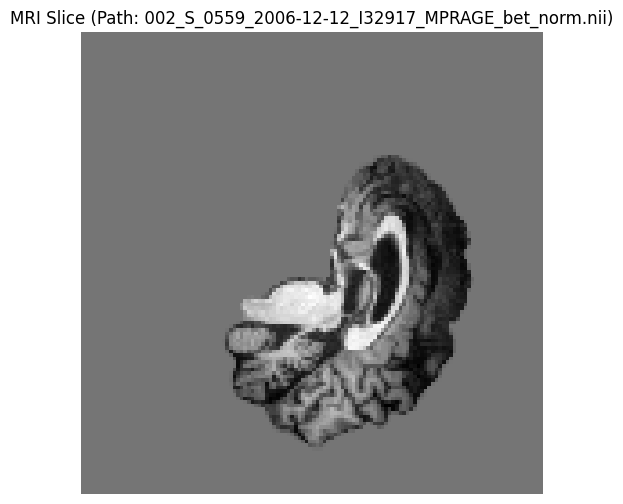

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (170, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.0936, Max value: 8.6917, Mean: -0.0000, Std: 0.9320


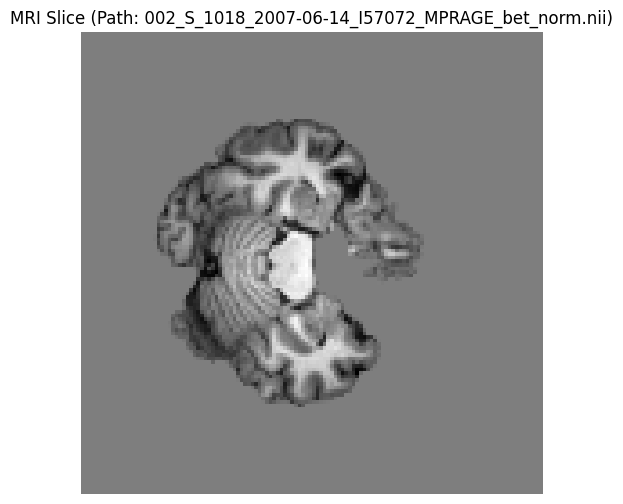

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 13.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (170, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -8.6066, Max value: 12.1110, Mean: 0.0001, Std: 0.9263


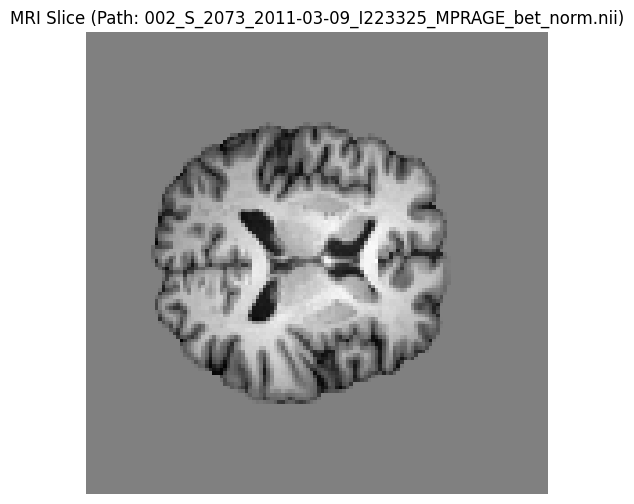

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 20.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (170, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.2423, Max value: 7.9063, Mean: 0.0001, Std: 0.9346


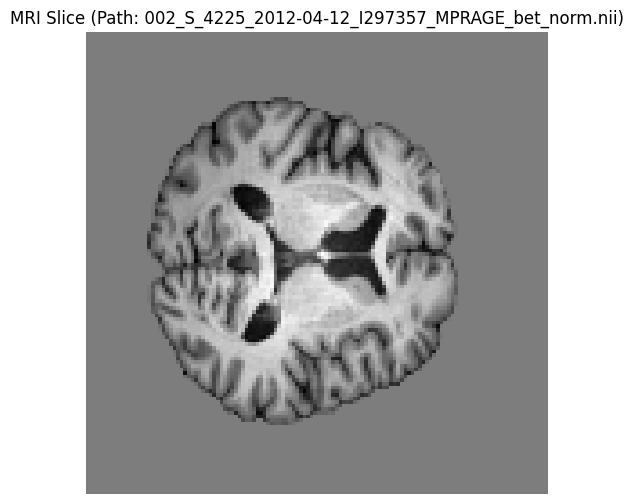

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 20.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (170, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.4518, Max value: 9.4322, Mean: 0.0000, Std: 0.9279


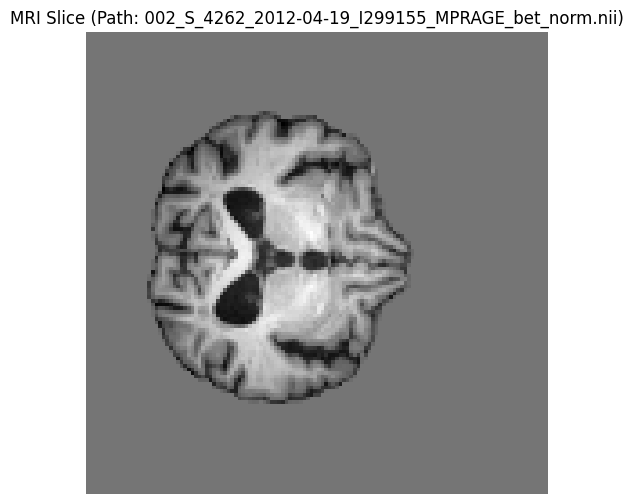

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.7730, Max value: 5.5388, Mean: 0.0000, Std: 0.9277


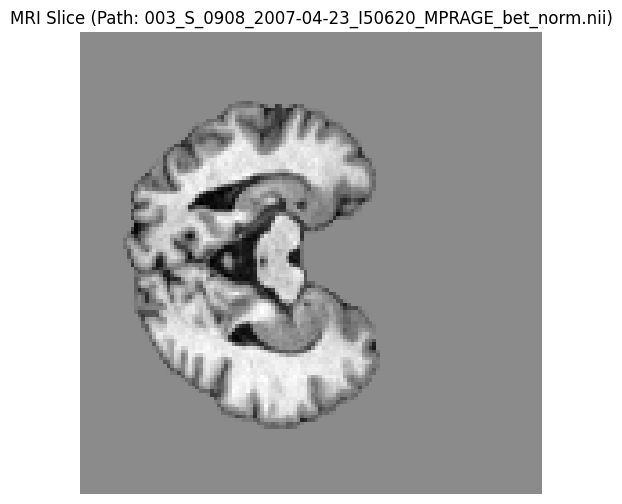

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -5.7438, Max value: 5.7918, Mean: -0.0000, Std: 0.9301


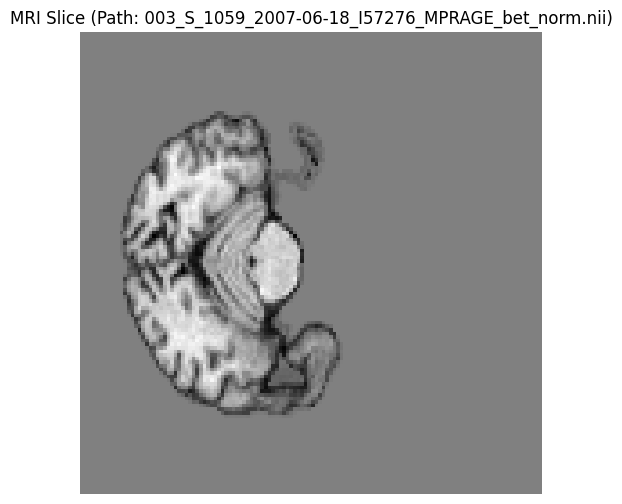

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.6206, Max value: 7.5449, Mean: 0.0000, Std: 0.9264


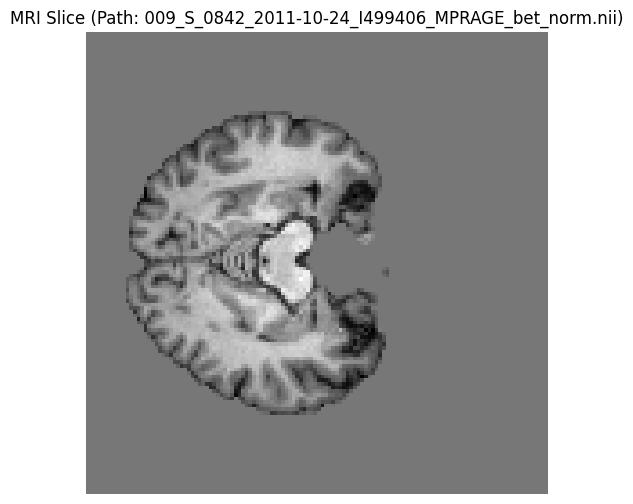

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.5250, Max value: 7.4305, Mean: 0.0000, Std: 0.9247


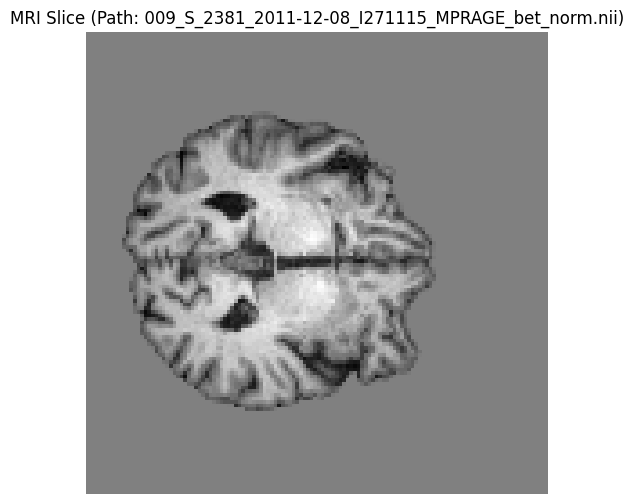

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -8.5859, Max value: 9.3681, Mean: 0.0000, Std: 0.9238


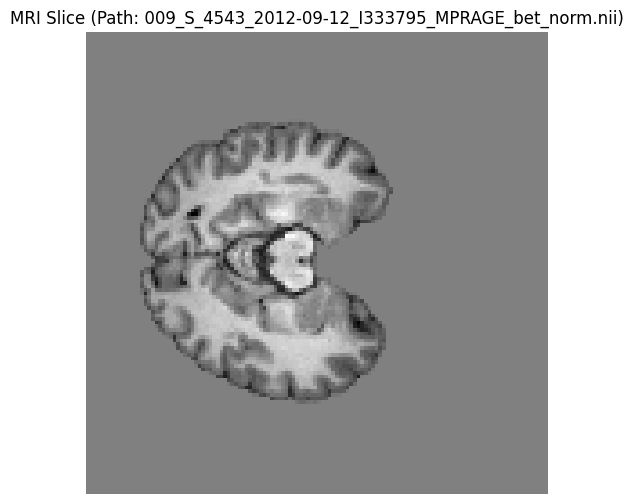

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.7592, Max value: 7.0064, Mean: -0.0001, Std: 0.9255


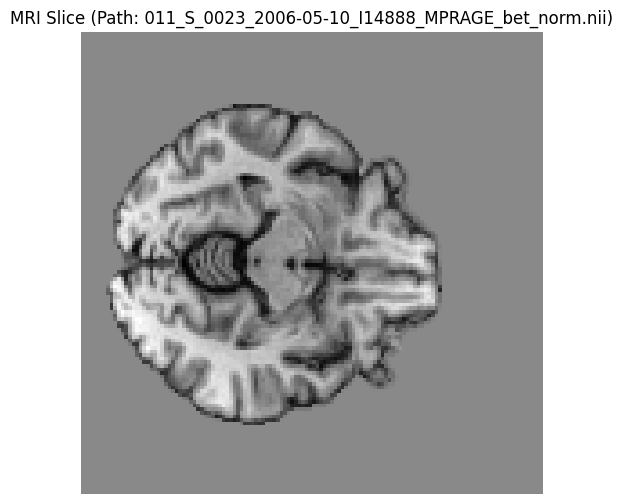

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 14.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -5.5393, Max value: 5.9527, Mean: -0.0000, Std: 0.9346


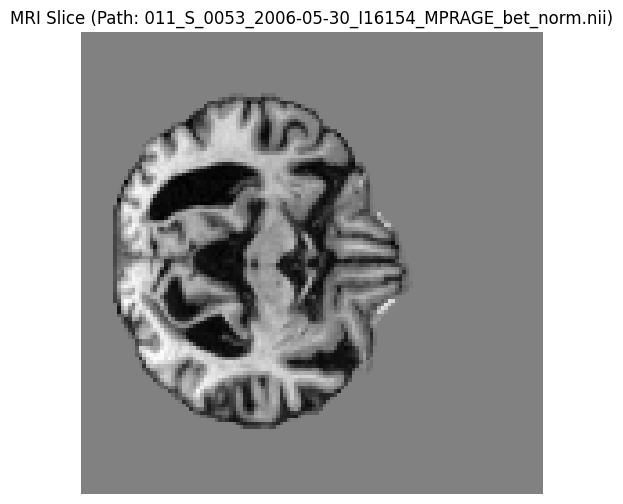

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 12.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -5.6257, Max value: 7.3866, Mean: 0.0000, Std: 0.9266


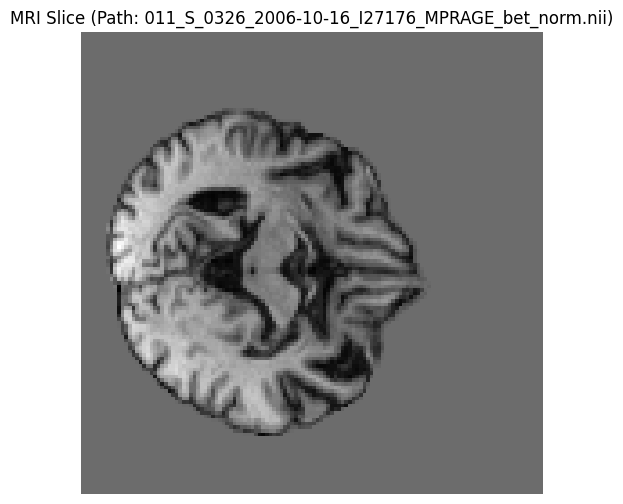

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -5.3785, Max value: 6.5739, Mean: 0.0000, Std: 0.9256


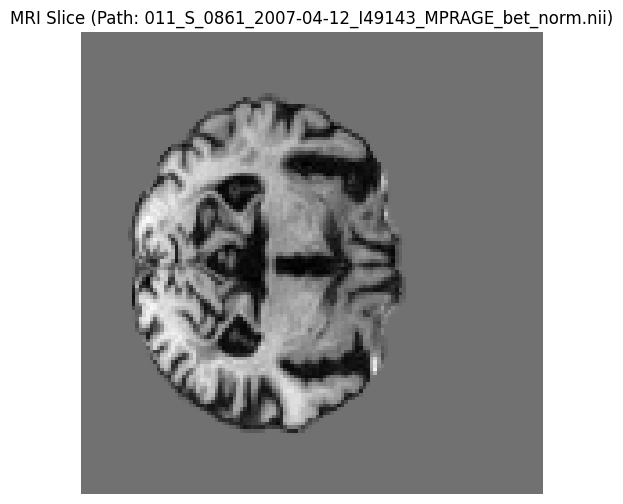

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.5442, Max value: 6.3943, Mean: 0.0000, Std: 0.9386


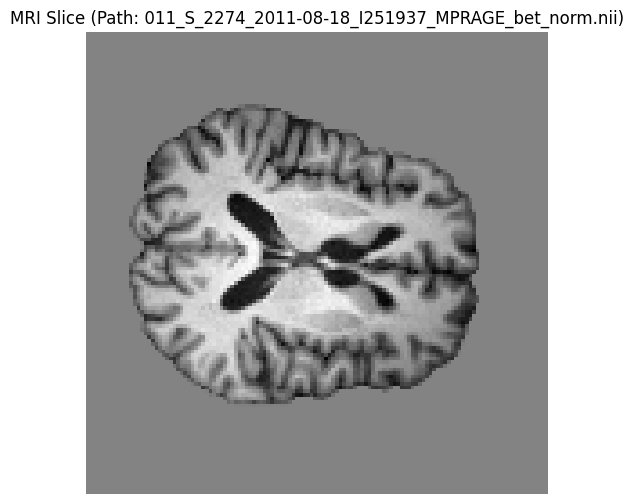

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.2539, Max value: 10.9049, Mean: 0.0001, Std: 0.9229


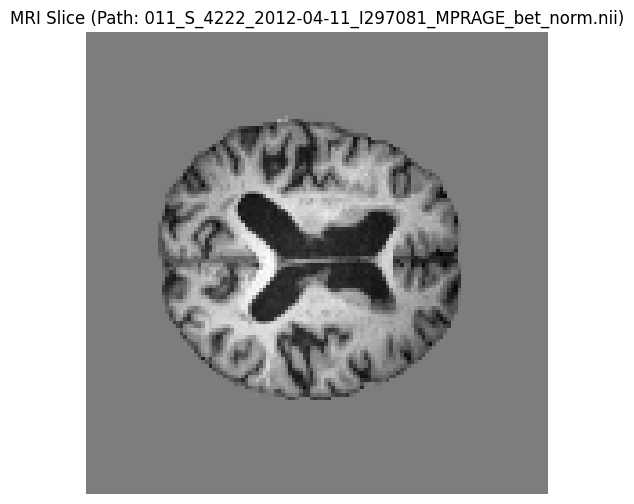

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.2803, Max value: 13.7883, Mean: -0.0001, Std: 0.9310


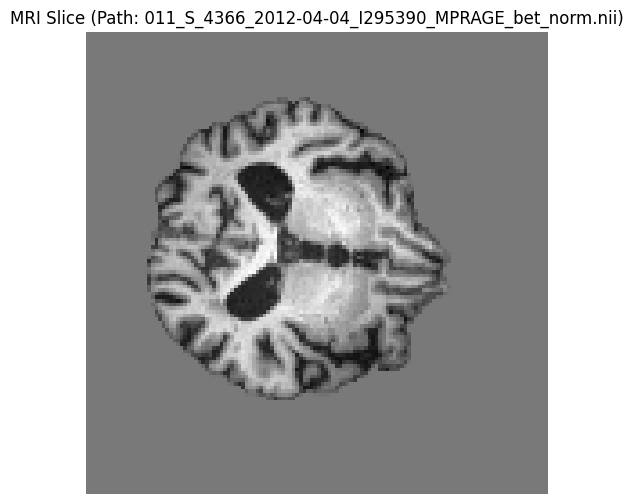

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -8.0633, Max value: 8.3794, Mean: -0.0000, Std: 0.9344


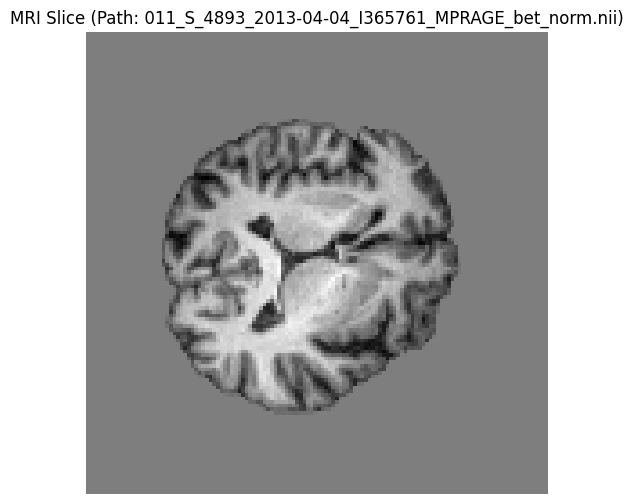

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 12.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.8837, Max value: 7.3002, Mean: 0.0000, Std: 0.9287


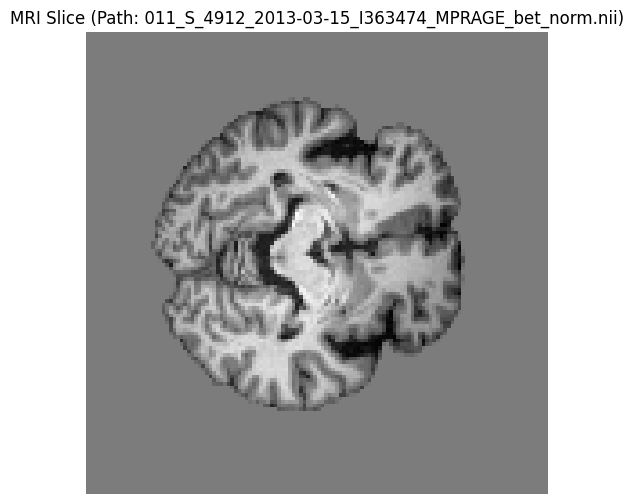

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (256, 256, 170)
Transposed shape: (170, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.0404, Max value: 11.6283, Mean: -0.0000, Std: 0.9369


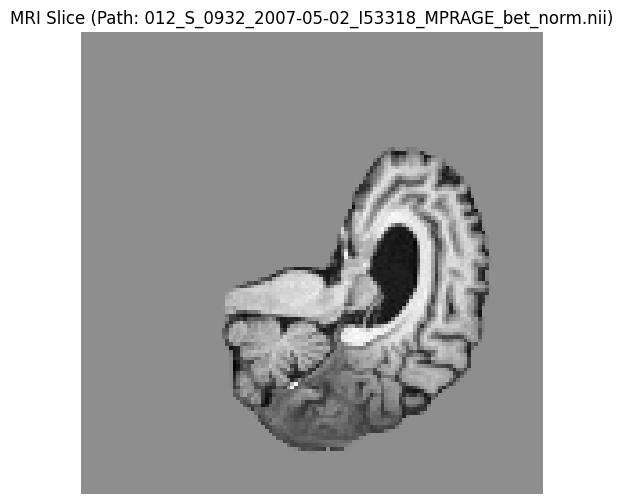

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (170, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.2524, Max value: 7.8841, Mean: 0.0002, Std: 0.9288


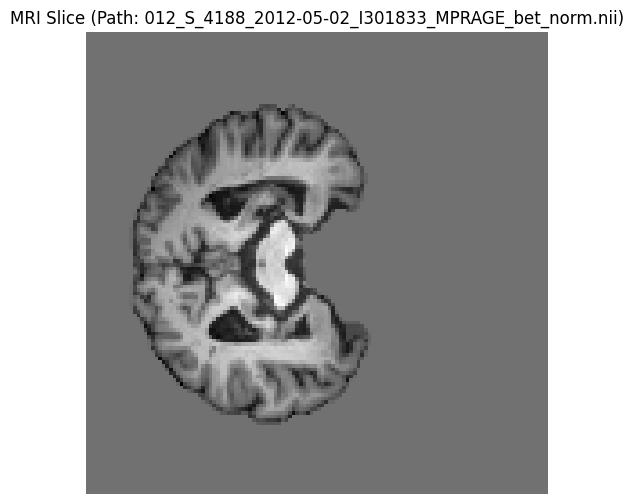

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 14.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (170, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.6103, Max value: 8.4813, Mean: 0.0001, Std: 0.9299


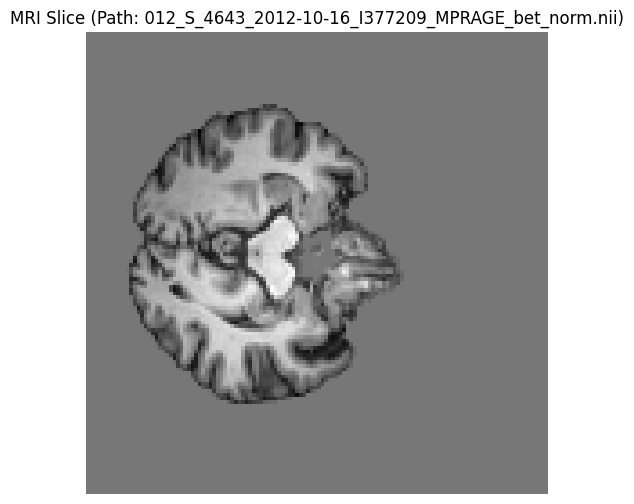

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -5.8648, Max value: 6.0120, Mean: -0.0001, Std: 0.9225


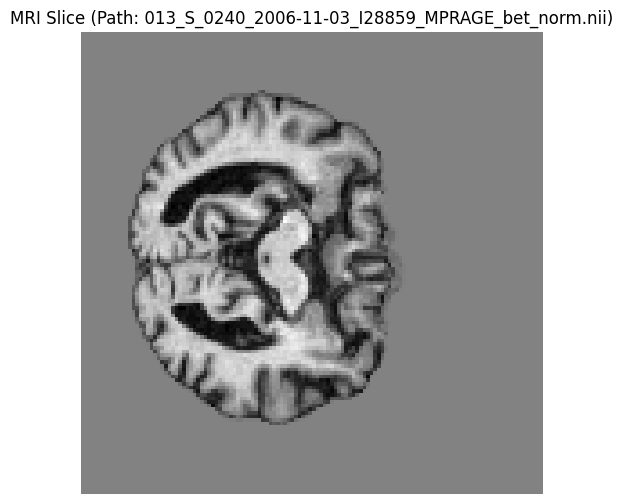

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -5.8240, Max value: 6.0750, Mean: -0.0001, Std: 0.9212


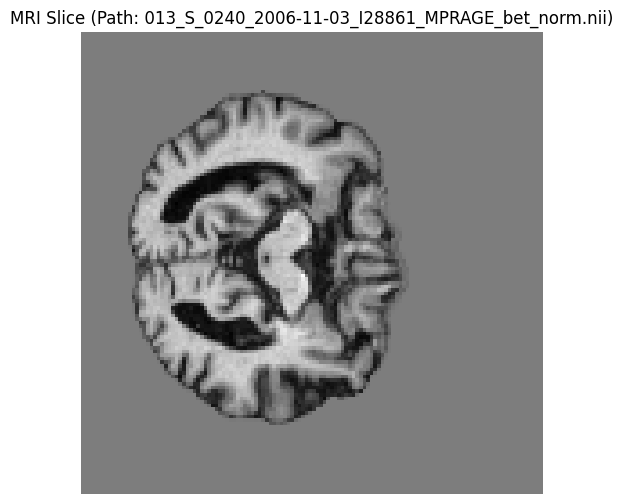

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.1917, Max value: 5.7109, Mean: 0.0000, Std: 0.9241


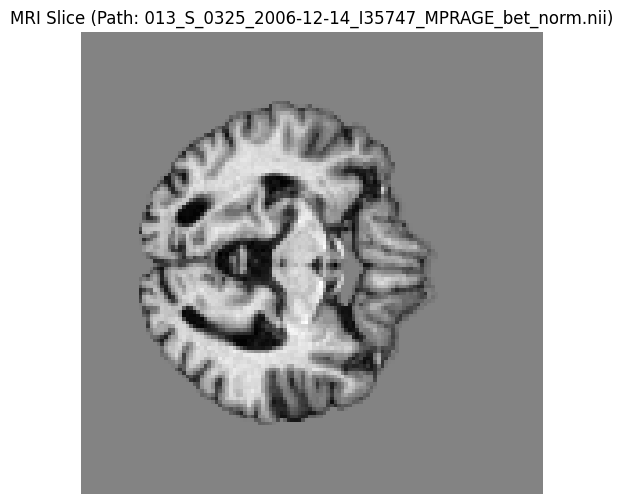

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.2857, Max value: 5.8238, Mean: -0.0001, Std: 0.9158


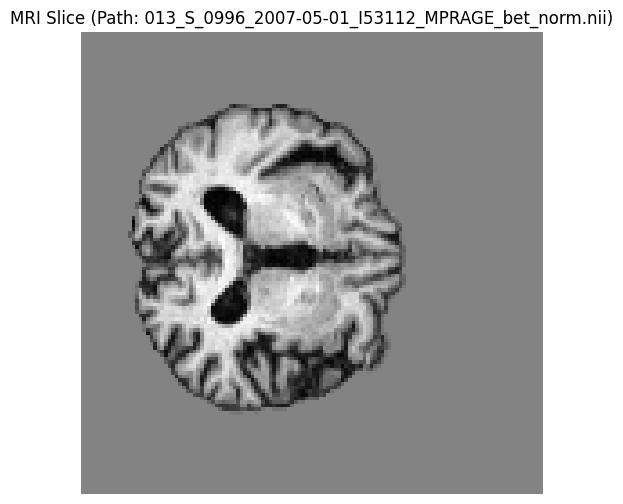

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.5787, Max value: 9.5490, Mean: -0.0001, Std: 0.9178


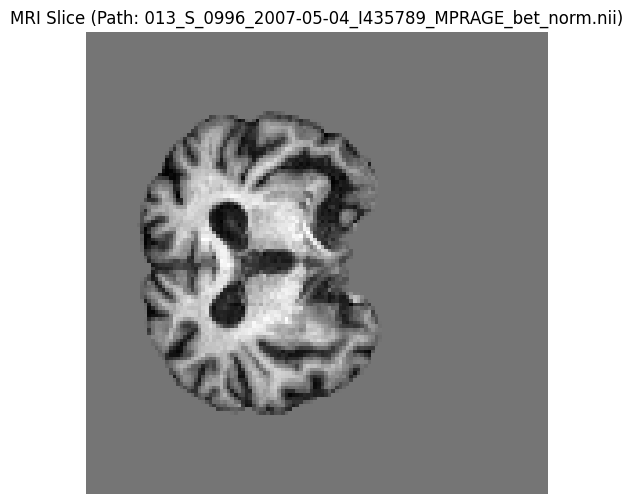

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.5230, Max value: 5.2432, Mean: 0.0001, Std: 0.9197


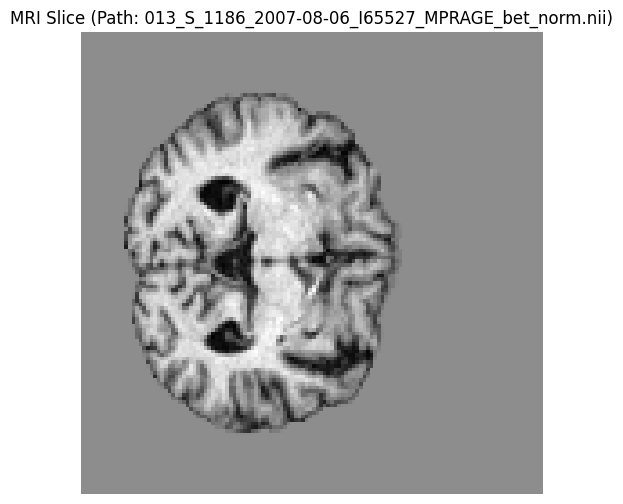

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 12.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (170, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -8.3393, Max value: 7.8229, Mean: 0.0001, Std: 0.9336


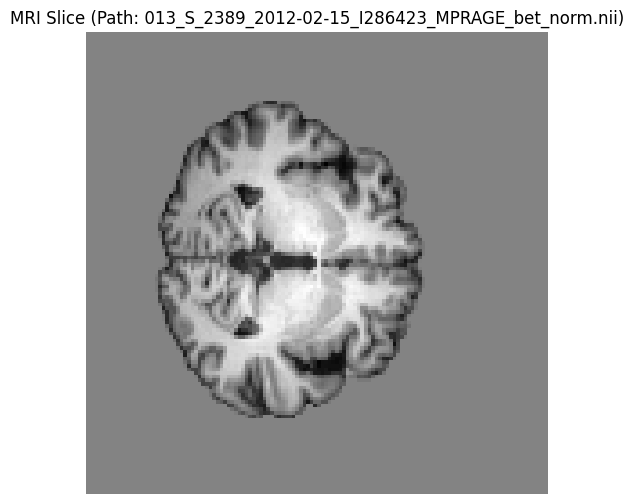

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 15.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (170, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -8.4696, Max value: 7.0310, Mean: 0.0001, Std: 0.9346


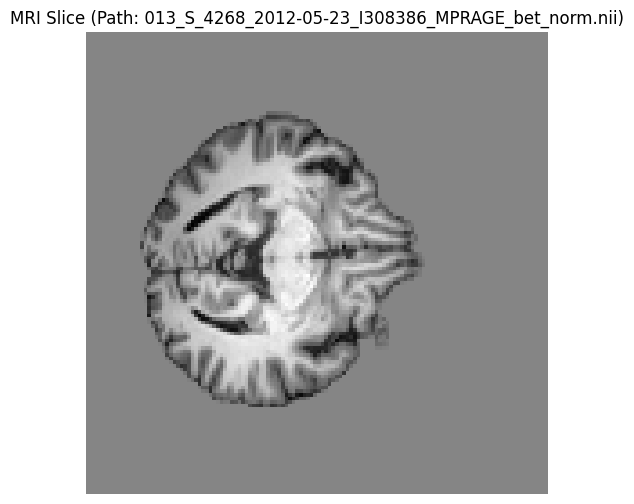

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 15.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -8.1882, Max value: 7.6809, Mean: -0.0001, Std: 0.9183


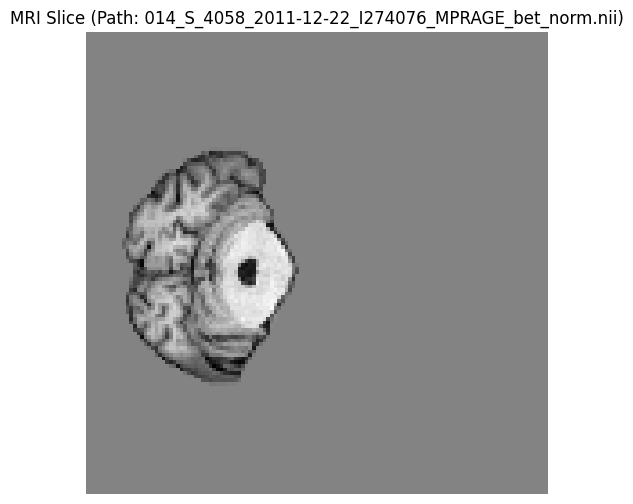

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.2937, Max value: 10.1699, Mean: 0.0000, Std: 0.9350


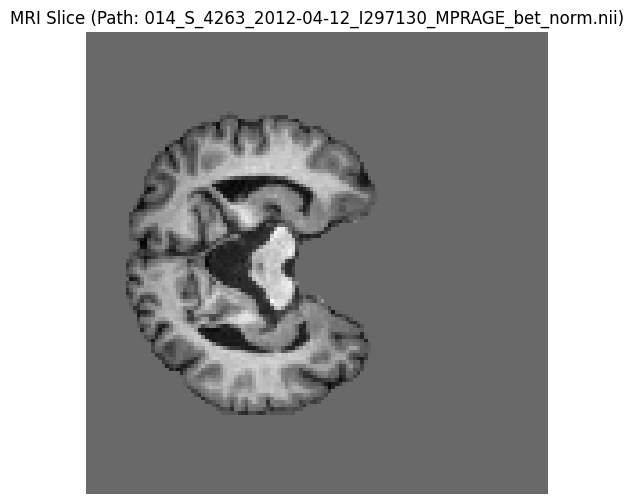

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 20.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.5480, Max value: 9.4718, Mean: 0.0002, Std: 0.9346


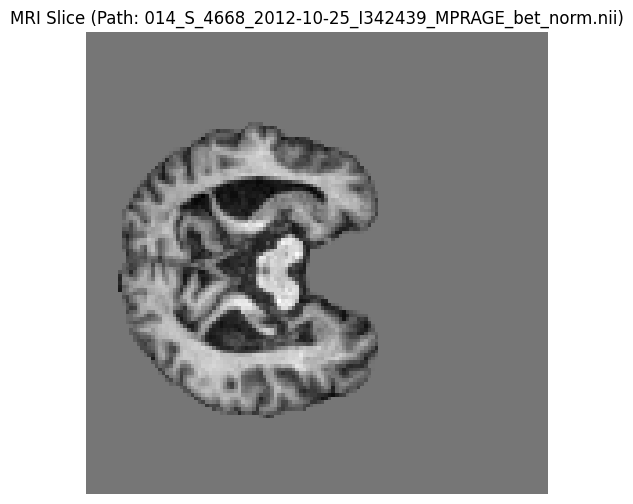

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 20.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.5314, Max value: 6.0225, Mean: 0.0000, Std: 0.9152


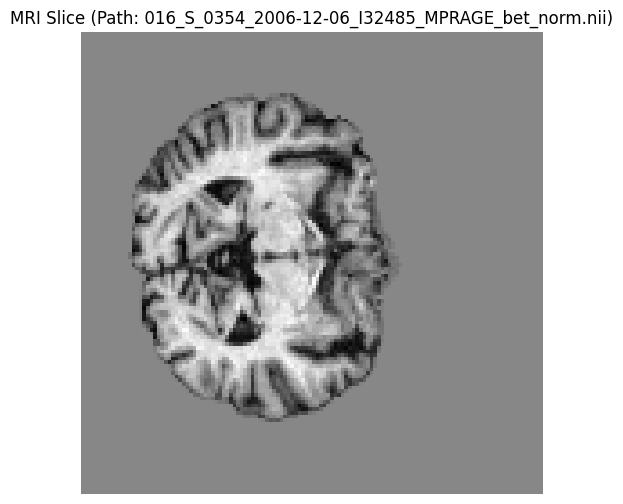

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -5.6032, Max value: 6.1821, Mean: -0.0001, Std: 0.9263


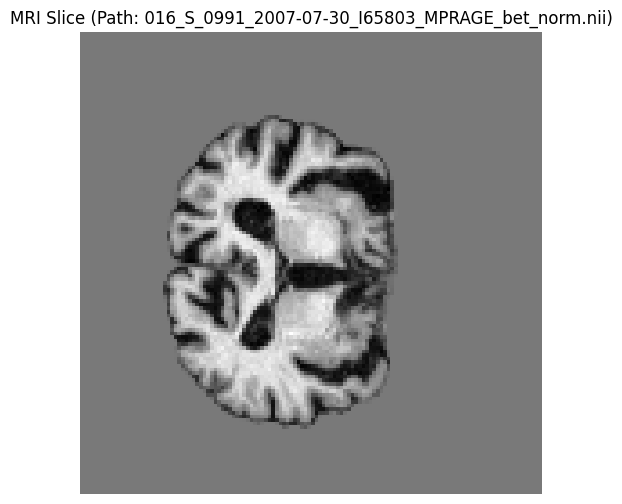

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 10.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.5448, Max value: 6.4403, Mean: -0.0002, Std: 0.9168


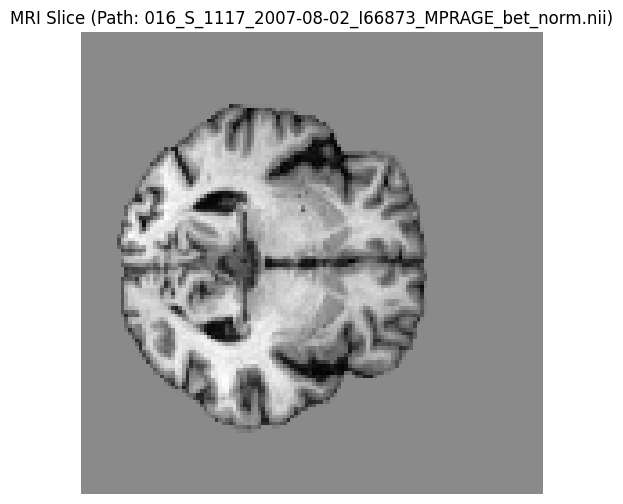

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.8979, Max value: 4.8786, Mean: -0.0002, Std: 0.9179


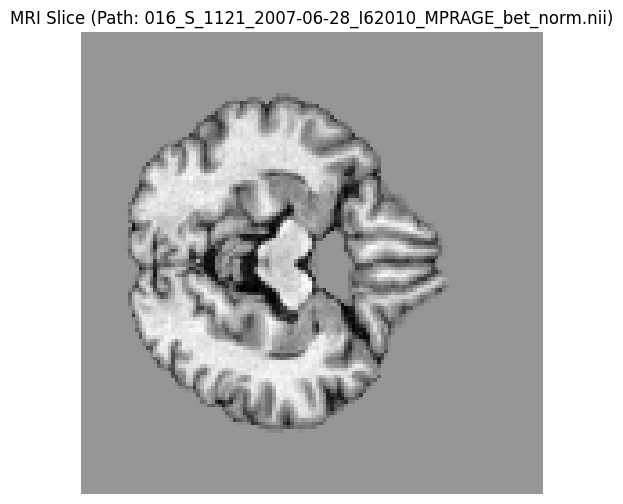

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (256, 256, 170)
Transposed shape: (170, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.9508, Max value: 7.7959, Mean: -0.0001, Std: 0.9343


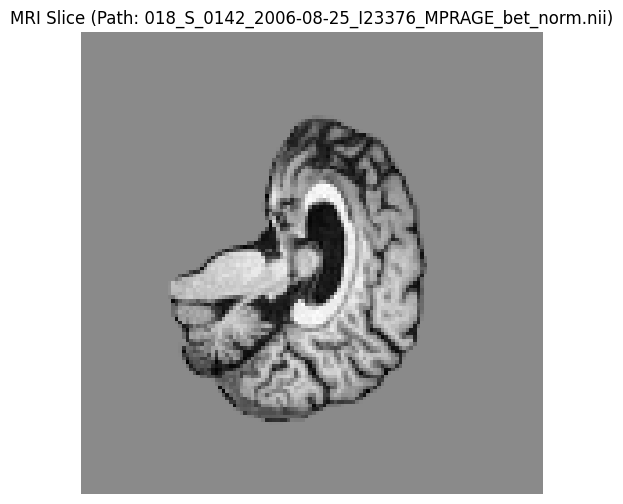

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 14.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (256, 256, 170)
Transposed shape: (170, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.1063, Max value: 6.8438, Mean: -0.0002, Std: 0.9401


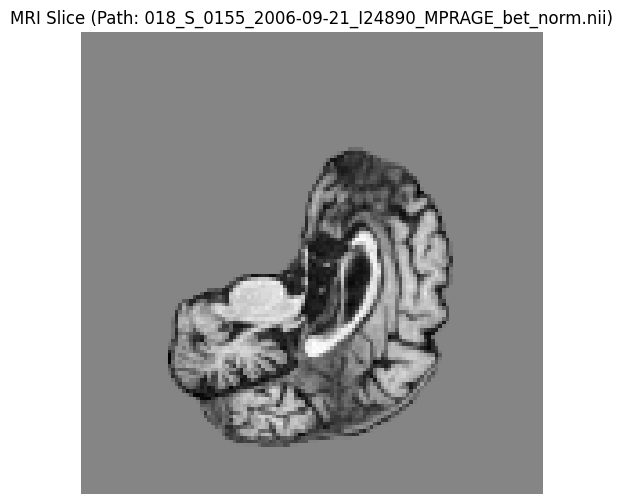

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (256, 256, 170)
Transposed shape: (170, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -5.8763, Max value: 6.3633, Mean: -0.0001, Std: 0.9393


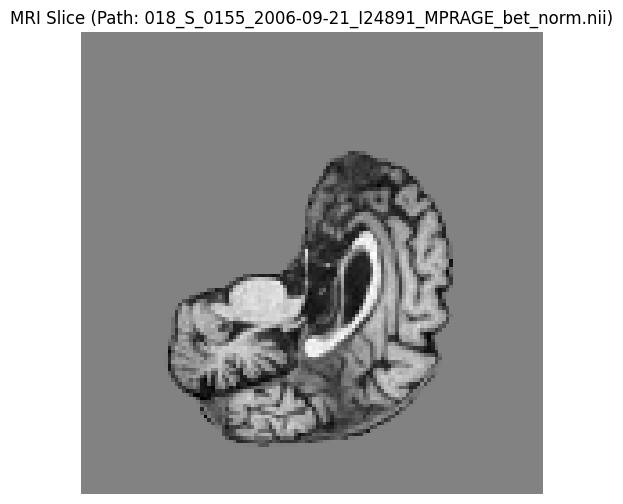

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (256, 256, 170)
Transposed shape: (170, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.5194, Max value: 9.9497, Mean: -0.0001, Std: 0.9339


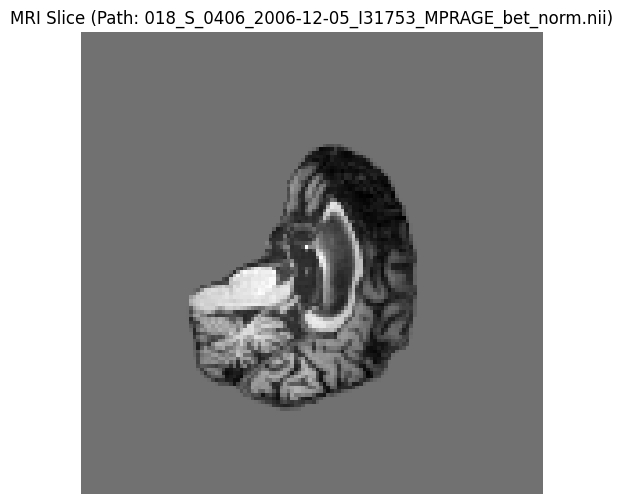

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 11.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (256, 256, 170)
Transposed shape: (170, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.0646, Max value: 9.7586, Mean: 0.0000, Std: 0.9362


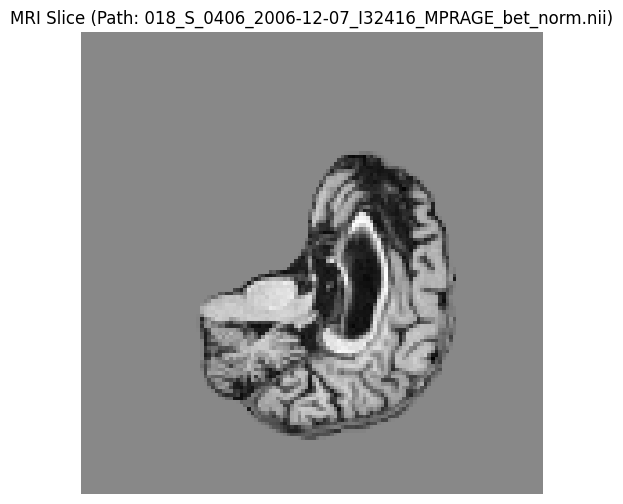

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 11.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (256, 256, 170)
Transposed shape: (170, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.9597, Max value: 12.7346, Mean: -0.0001, Std: 0.9247


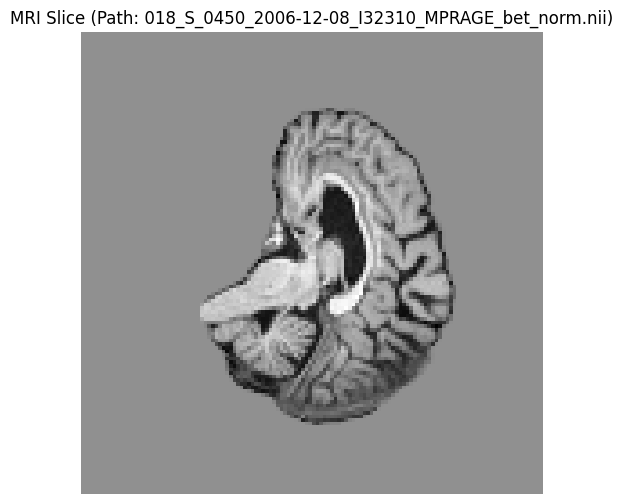

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 20.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (256, 256, 170)
Transposed shape: (170, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: 0.0000, Max value: 0.0000, Mean: 0.0000, Std: 0.0000


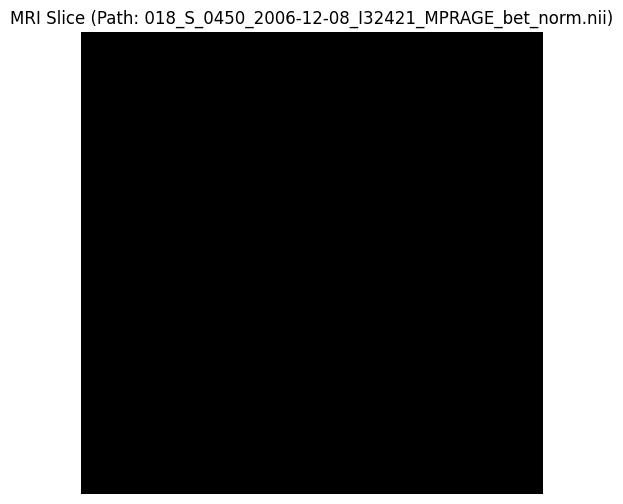

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 20.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (256, 256, 170)
Transposed shape: (170, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.4872, Max value: 9.8599, Mean: -0.0000, Std: 0.9344


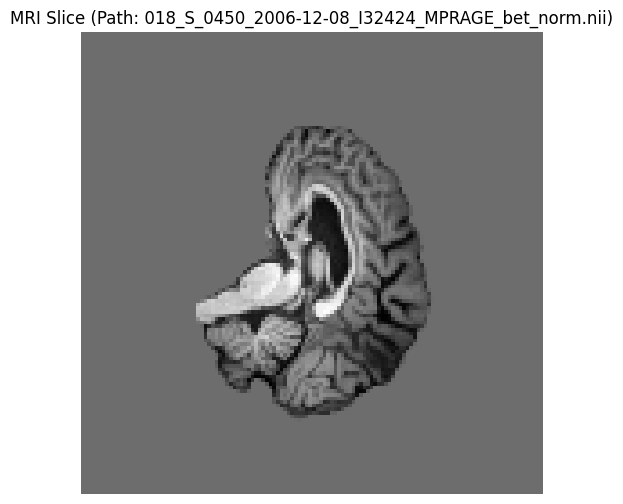

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 20.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (170, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.5724, Max value: 8.6322, Mean: -0.0001, Std: 0.9355


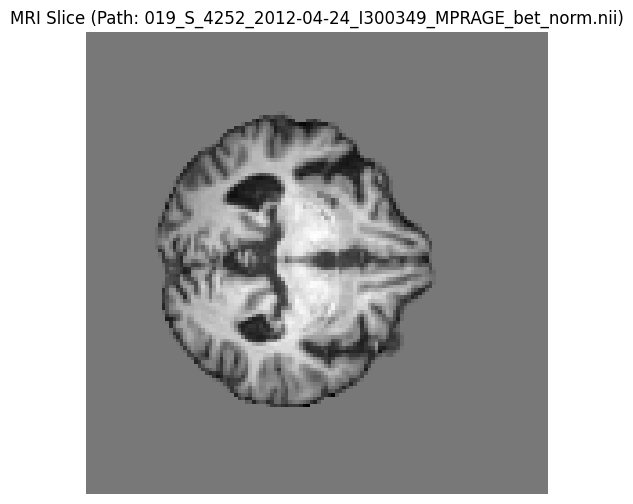

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (170, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -8.3248, Max value: 7.6480, Mean: 0.0000, Std: 0.9378


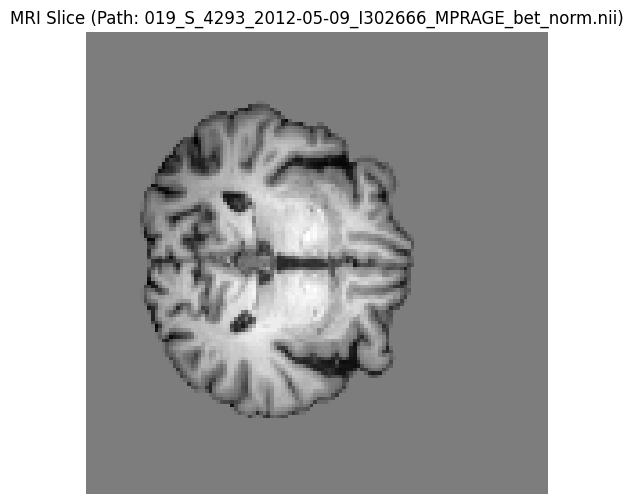

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 12.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (170, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -8.3753, Max value: 8.1168, Mean: 0.0000, Std: 0.9333


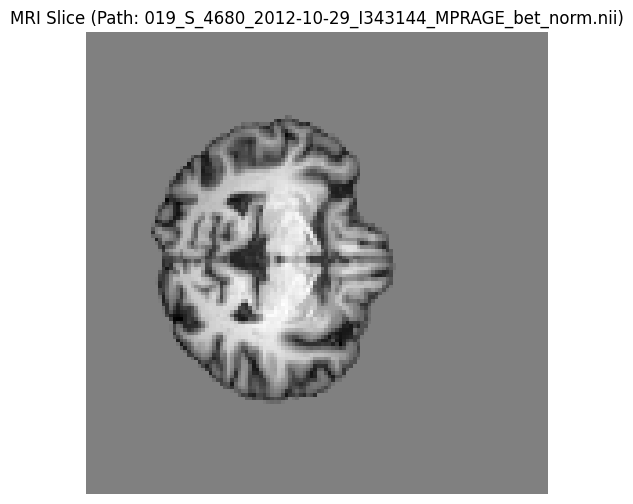

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 19.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (170, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.3975, Max value: 7.4001, Mean: 0.0000, Std: 0.9386


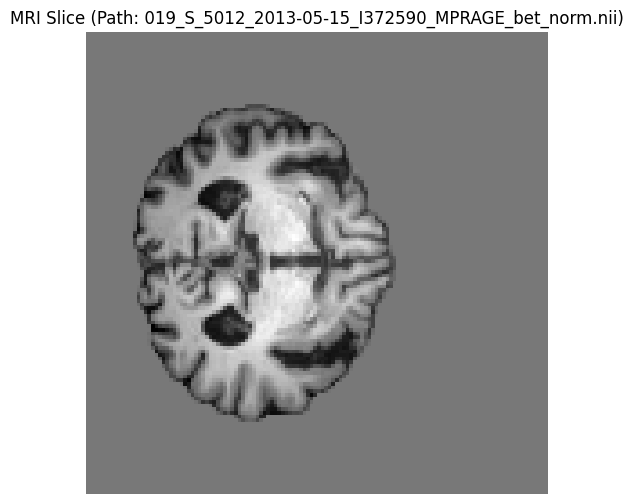

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -5.9243, Max value: 6.6693, Mean: -0.0001, Std: 0.9196


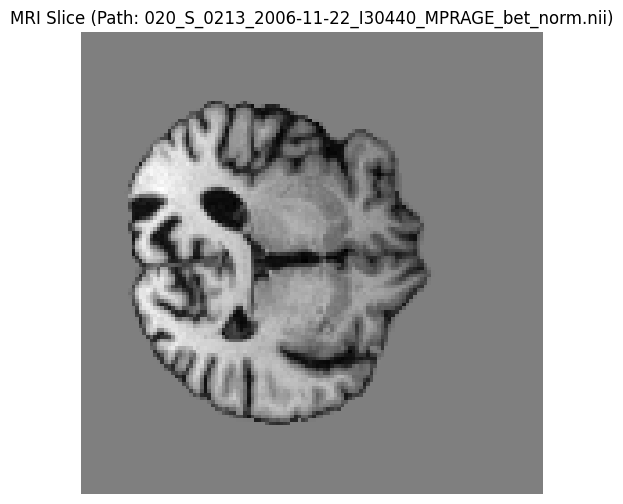

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.9170, Max value: 9.3280, Mean: -0.0001, Std: 0.9235


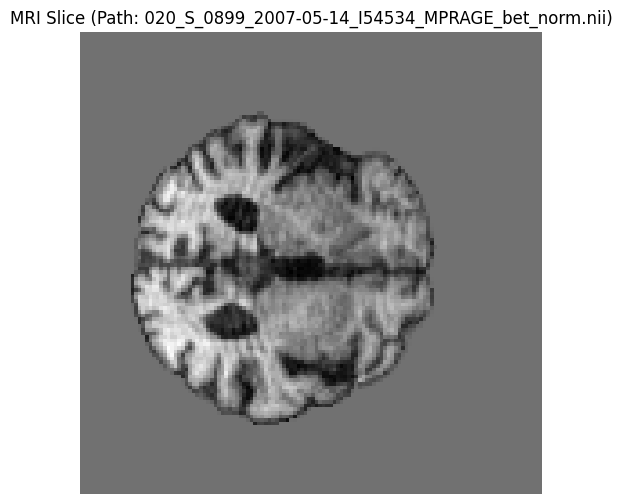

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.1864, Max value: 7.1780, Mean: -0.0001, Std: 0.9213


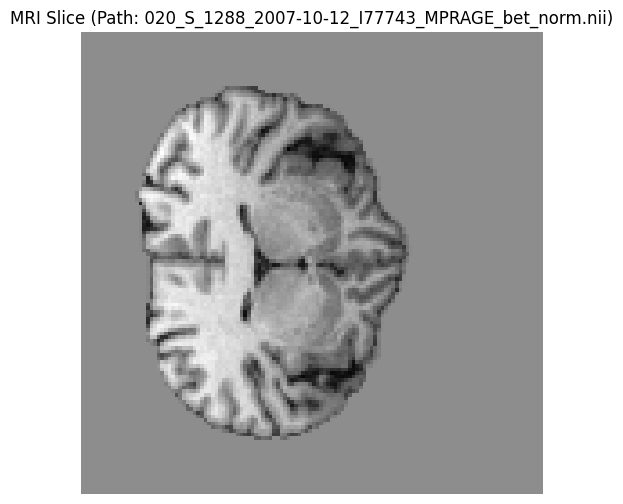

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 20.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.2436, Max value: 7.0098, Mean: -0.0000, Std: 0.9278


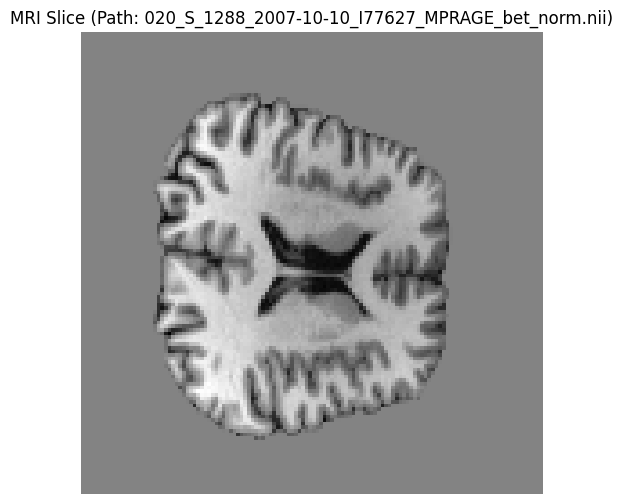

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 20.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -5.7179, Max value: 8.4968, Mean: 0.0001, Std: 0.9306


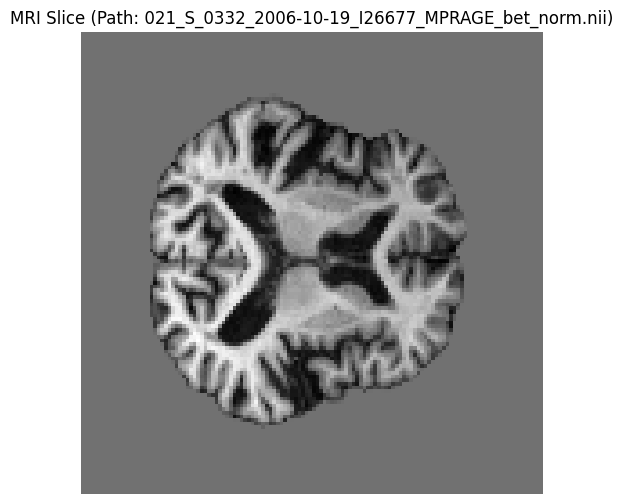

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -8.0804, Max value: 9.2231, Mean: 0.0000, Std: 0.9156


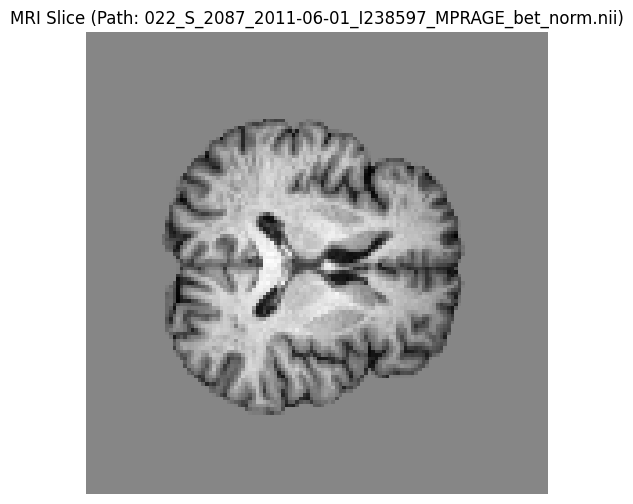

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.4717, Max value: 8.8388, Mean: 0.0001, Std: 0.9228


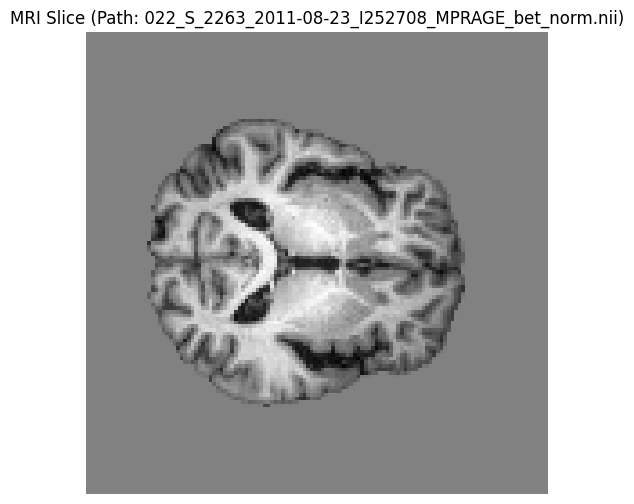

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.8920, Max value: 8.1187, Mean: 0.0002, Std: 0.9273


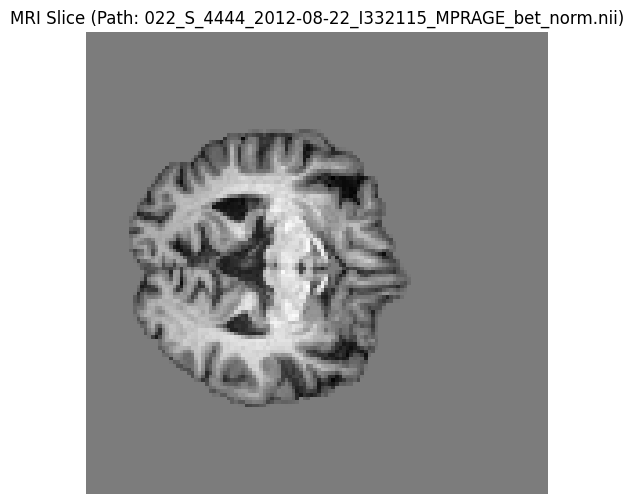

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.5403, Max value: 8.1995, Mean: 0.0001, Std: 0.9252


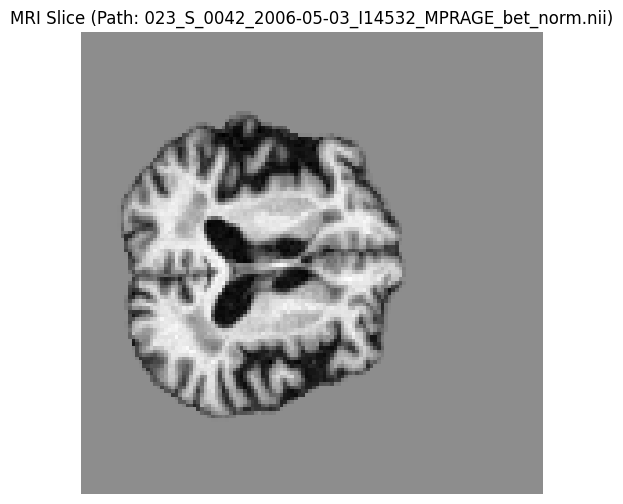

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.1250, Max value: 8.0870, Mean: 0.0000, Std: 0.9272


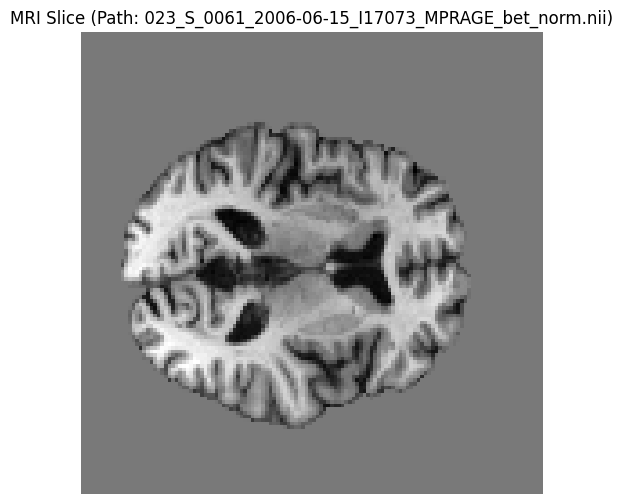

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 15.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.0217, Max value: 5.7339, Mean: 0.0002, Std: 0.9163


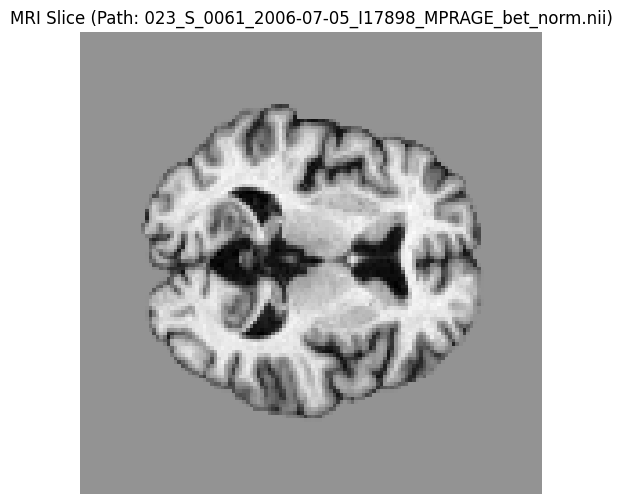

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 15.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.7203, Max value: 5.7228, Mean: 0.0001, Std: 0.9206


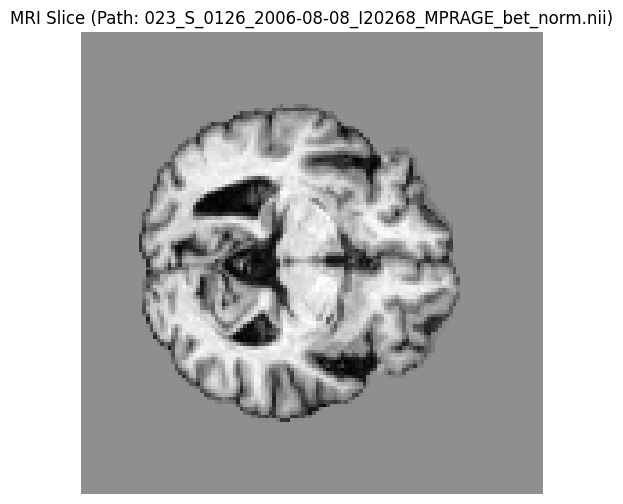

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 14.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.8897, Max value: 5.9145, Mean: -0.0001, Std: 0.9182


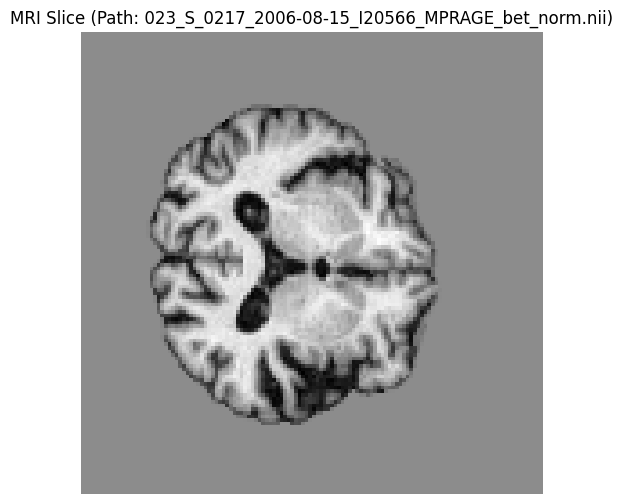

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.3351, Max value: 6.4448, Mean: -0.0002, Std: 0.9277


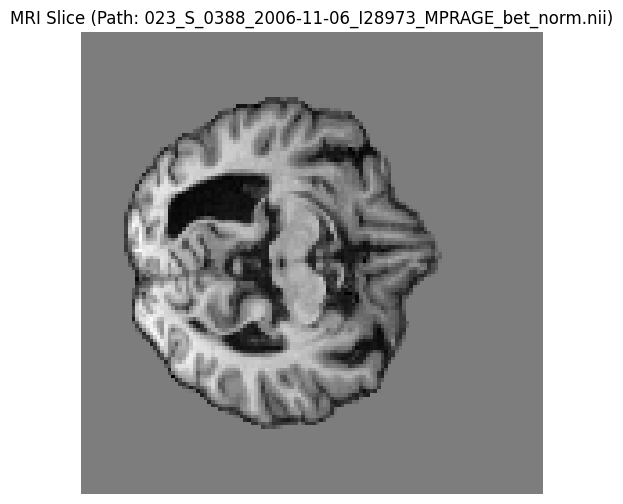

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 15.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -5.6321, Max value: 8.2000, Mean: -0.0000, Std: 0.9311


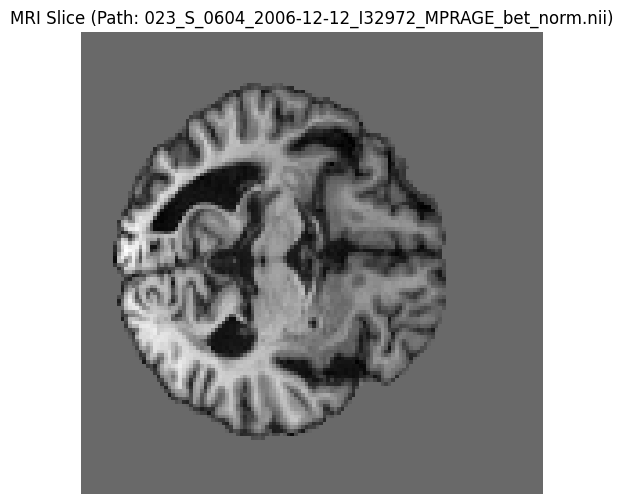

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 14.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.5636, Max value: 7.3857, Mean: -0.0000, Std: 0.9267


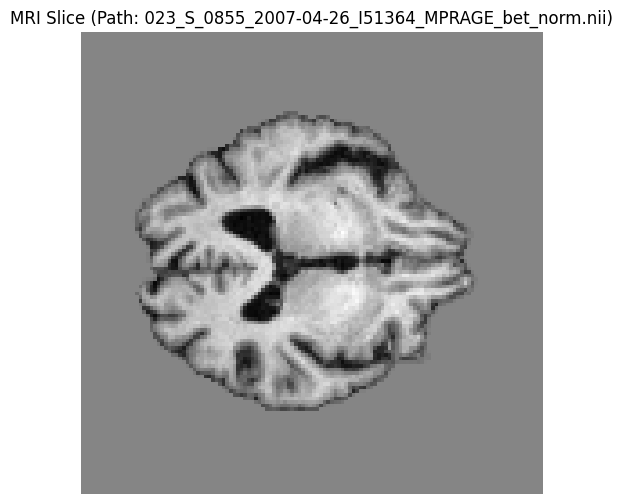

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 12.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.7436, Max value: 5.7716, Mean: -0.0001, Std: 0.9164


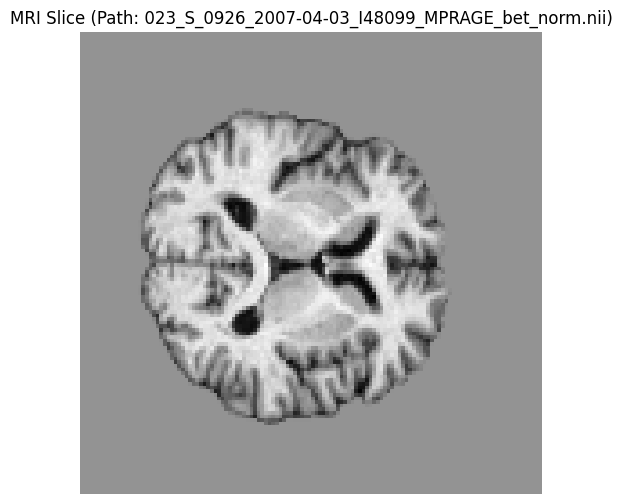

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.1689, Max value: 8.1226, Mean: -0.0000, Std: 0.9238


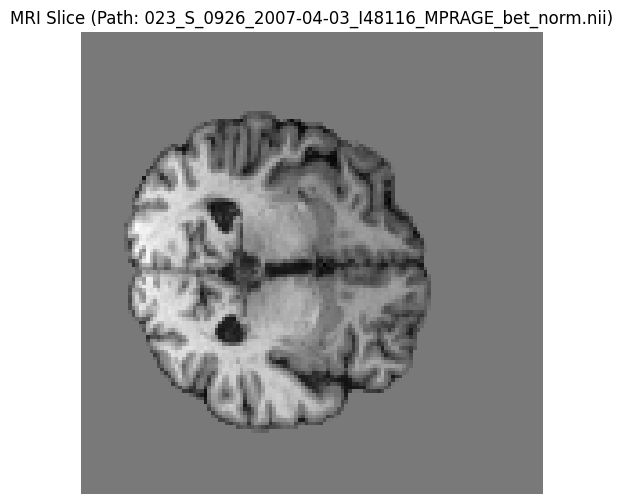

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.6289, Max value: 7.2621, Mean: -0.0000, Std: 0.9319


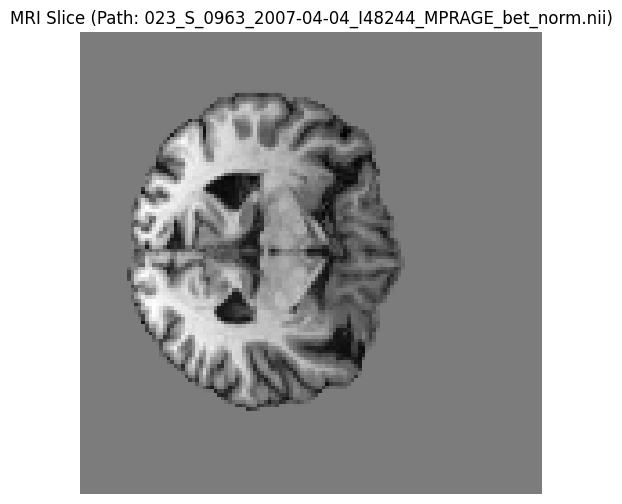

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.0660, Max value: 6.8349, Mean: -0.0000, Std: 0.9317


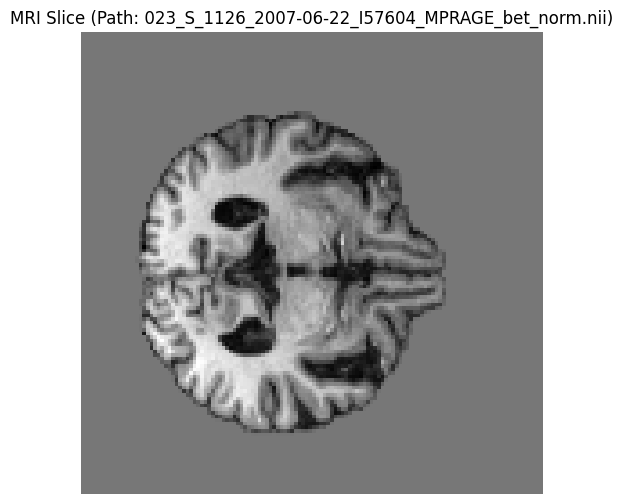

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -5.5314, Max value: 6.5855, Mean: 0.0001, Std: 0.9260


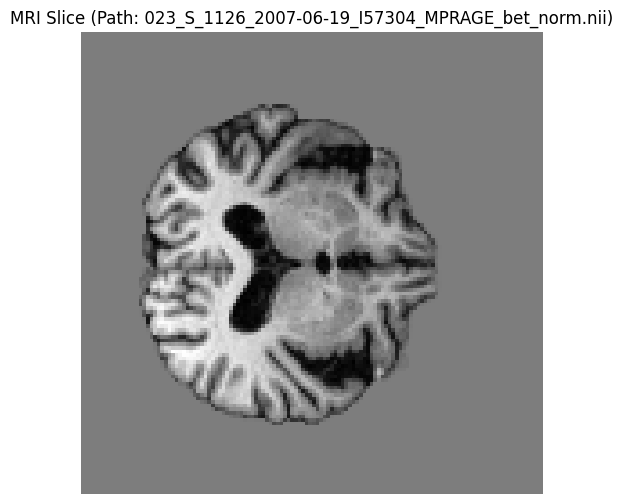

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.8305, Max value: 7.2068, Mean: -0.0001, Std: 0.9143


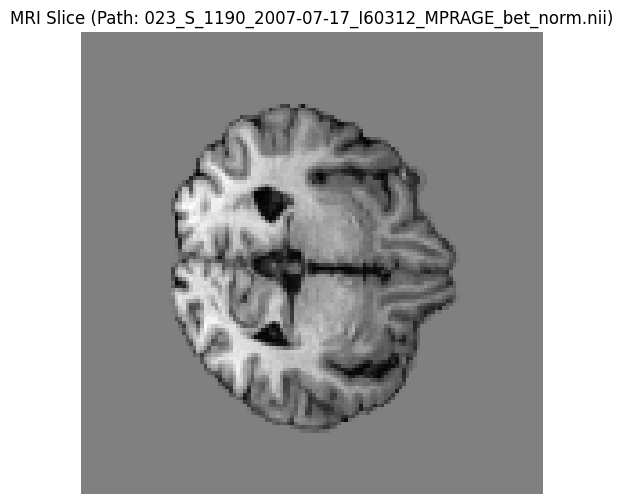

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 13.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.1838, Max value: 8.0978, Mean: -0.0001, Std: 0.9200


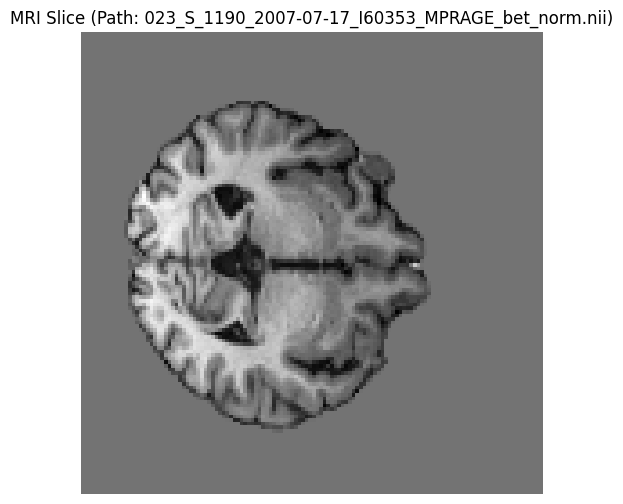

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 13.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.3584, Max value: 7.1182, Mean: -0.0000, Std: 0.9234


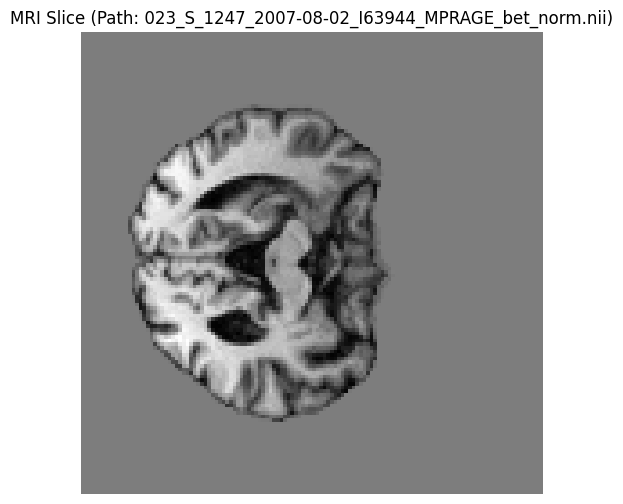

Demographic features shape: (1, 3)
Sample demographic data (first row): [0. 1. 9.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.9638, Max value: 8.8595, Mean: 0.0001, Std: 0.9252


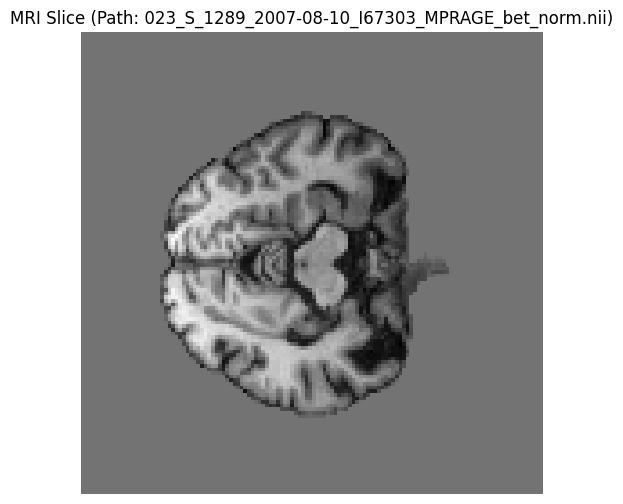

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 12.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.9493, Max value: 7.5514, Mean: -0.0000, Std: 0.9238


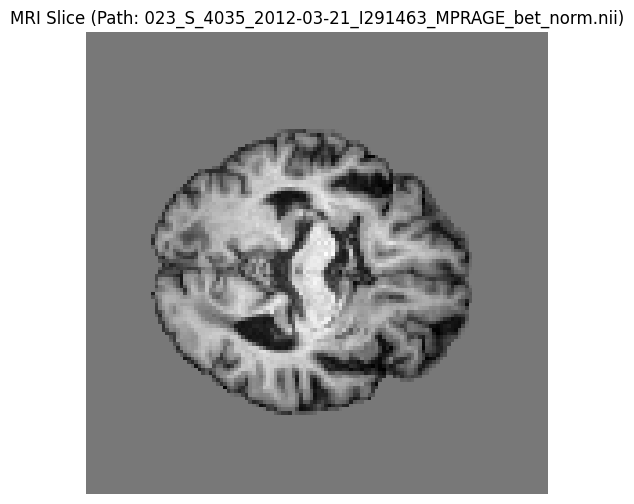

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.1634, Max value: 7.3081, Mean: -0.0001, Std: 0.9338


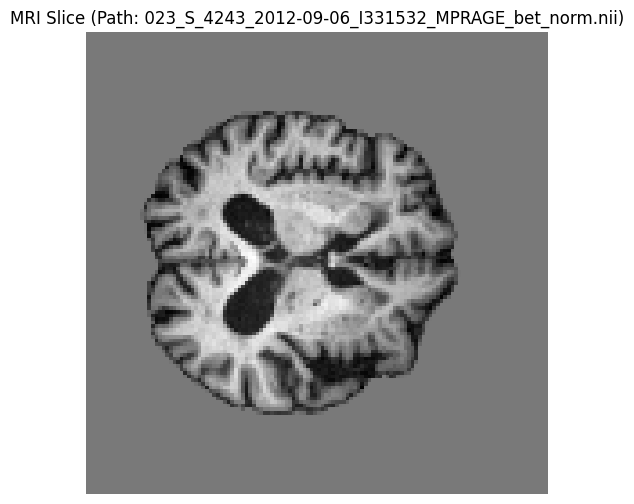

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.0341, Max value: 7.5589, Mean: -0.0001, Std: 0.9342


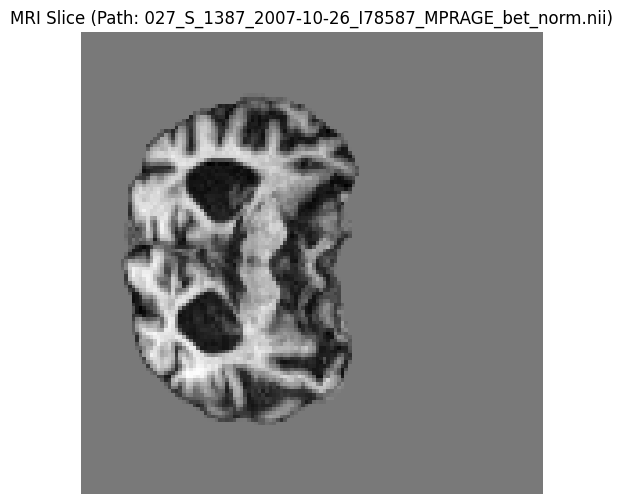

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 20.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.1016, Max value: 9.0968, Mean: 0.0002, Std: 0.9278


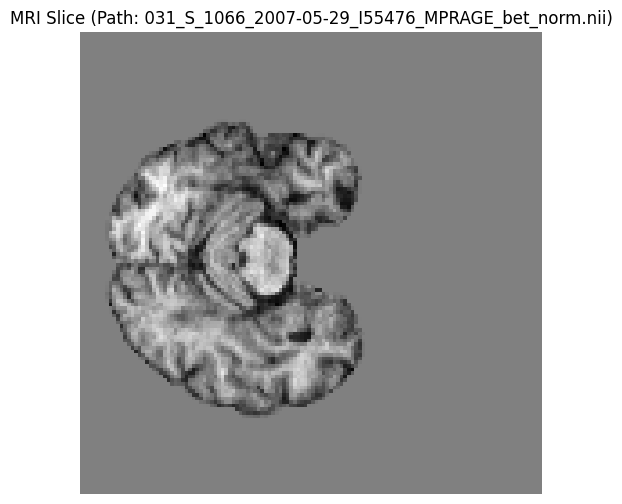

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 13.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (170, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.7844, Max value: 8.0218, Mean: -0.0001, Std: 0.9319


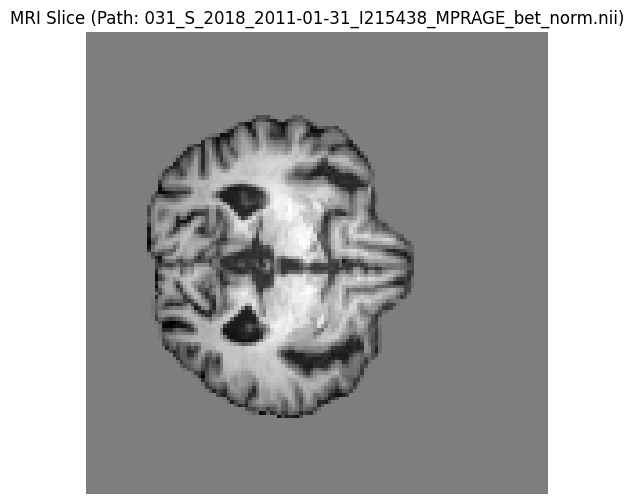

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (170, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.7785, Max value: 7.6666, Mean: -0.0000, Std: 0.9367


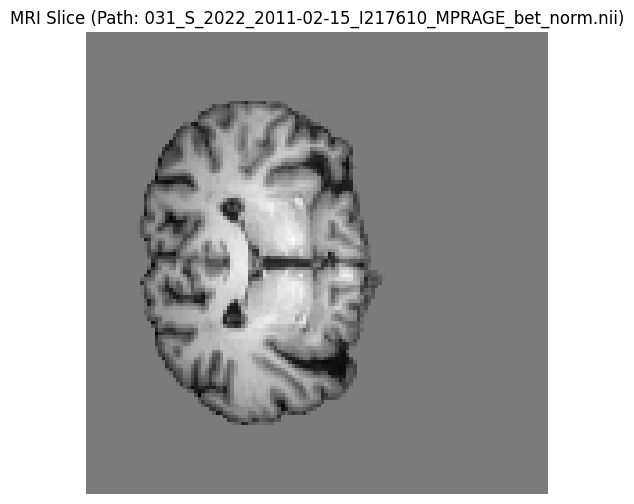

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (170, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.3265, Max value: 8.0798, Mean: 0.0001, Std: 0.9354


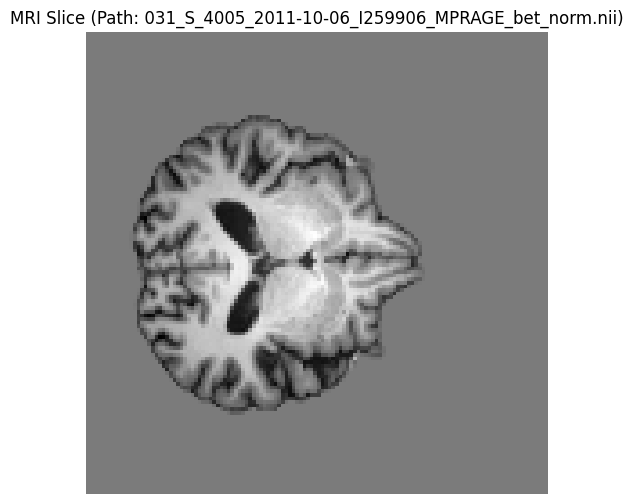

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (170, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -8.2369, Max value: 7.4951, Mean: -0.0000, Std: 0.9372


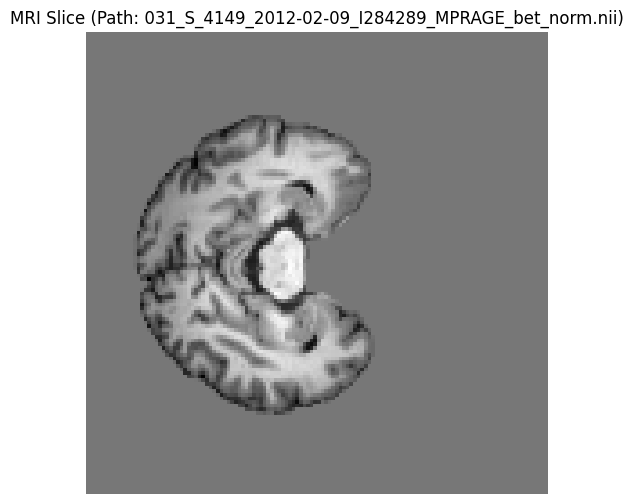

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 14.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (256, 256, 184)
Transposed shape: (184, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.1719, Max value: 5.0930, Mean: 0.0000, Std: 0.9330


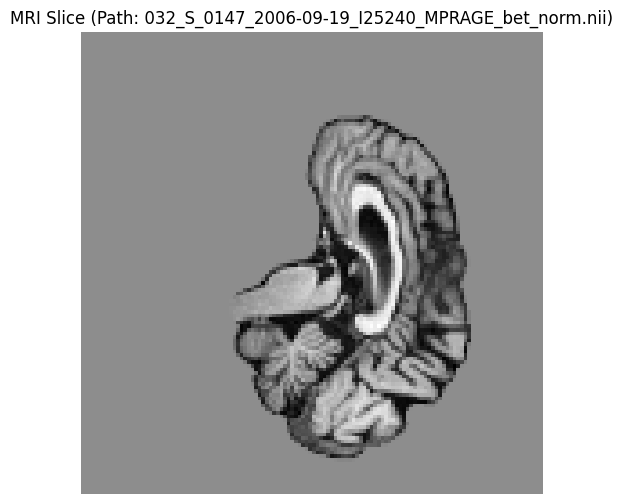

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (256, 256, 184)
Transposed shape: (184, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.2214, Max value: 7.1187, Mean: -0.0001, Std: 0.9370


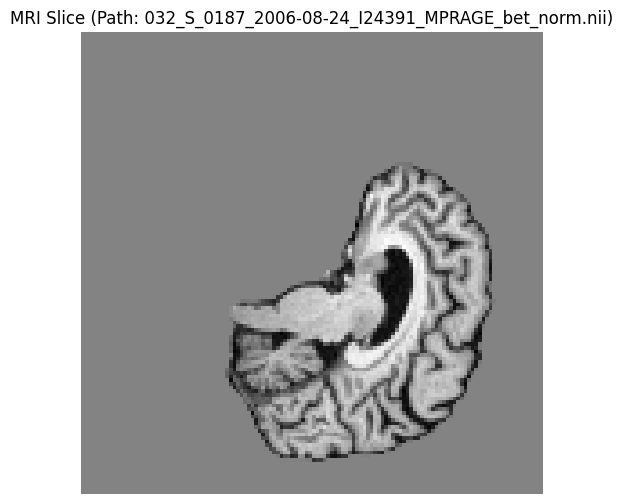

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (256, 256, 184)
Transposed shape: (184, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.3301, Max value: 7.0515, Mean: -0.0001, Std: 0.9368


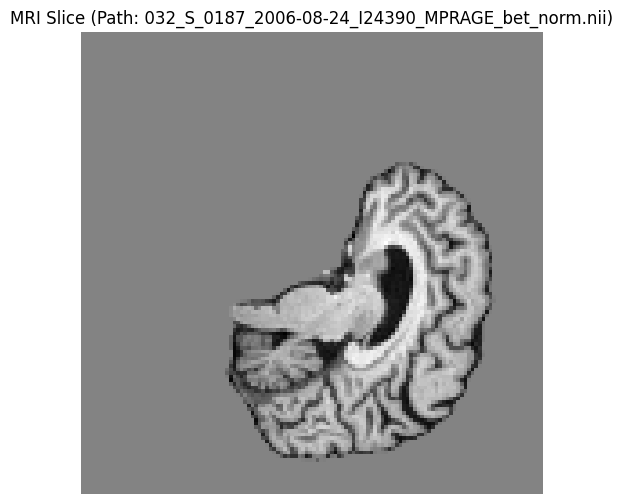

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.1603, Max value: 6.4439, Mean: 0.0000, Std: 0.9250


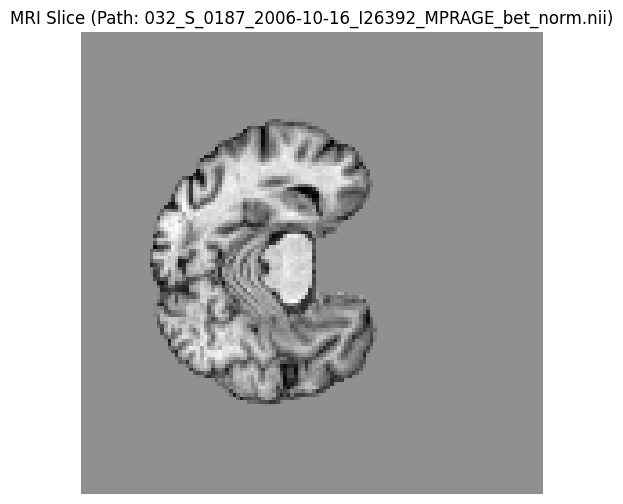

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (256, 256, 184)
Transposed shape: (184, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.7781, Max value: 6.4392, Mean: 0.0000, Std: 0.9302


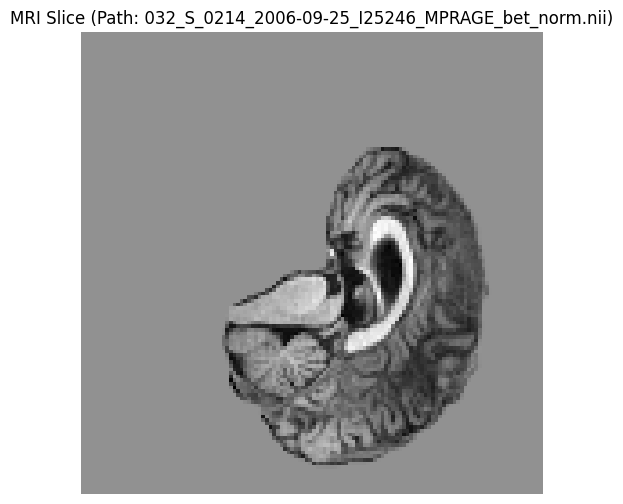

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (256, 256, 184)
Transposed shape: (184, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.7055, Max value: 5.8863, Mean: -0.0000, Std: 0.9381


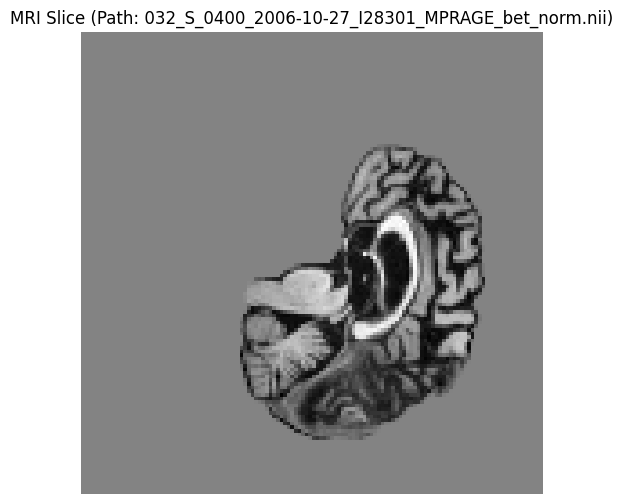

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (256, 256, 184)
Transposed shape: (184, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.4123, Max value: 6.9113, Mean: 0.0001, Std: 0.9397


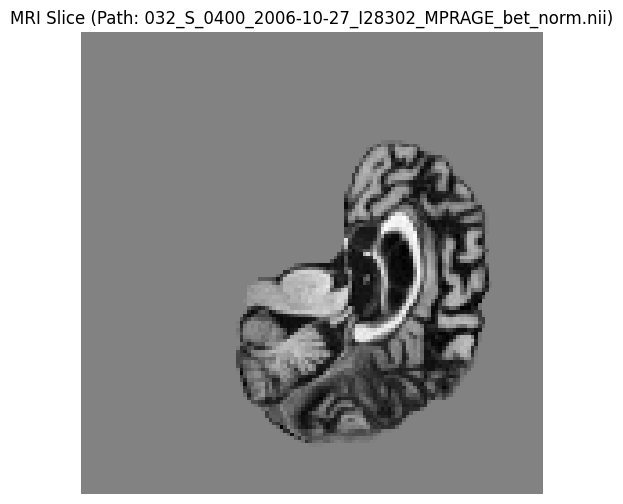

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (256, 256, 184)
Transposed shape: (184, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.0980, Max value: 6.5081, Mean: 0.0000, Std: 0.9402


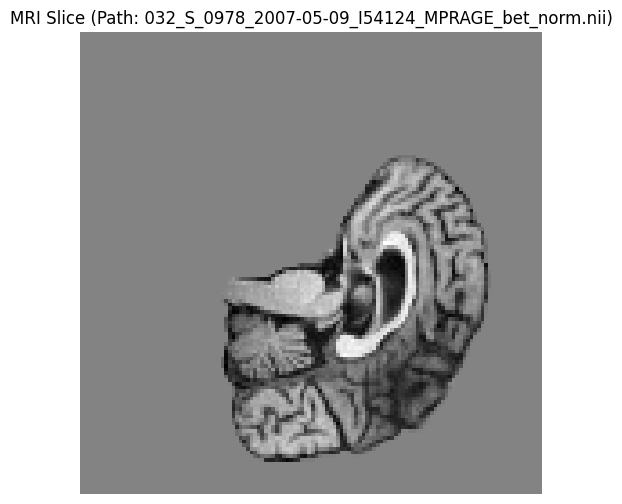

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 12.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (256, 256, 184)
Transposed shape: (184, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.8451, Max value: 11.2432, Mean: -0.0001, Std: 0.9387


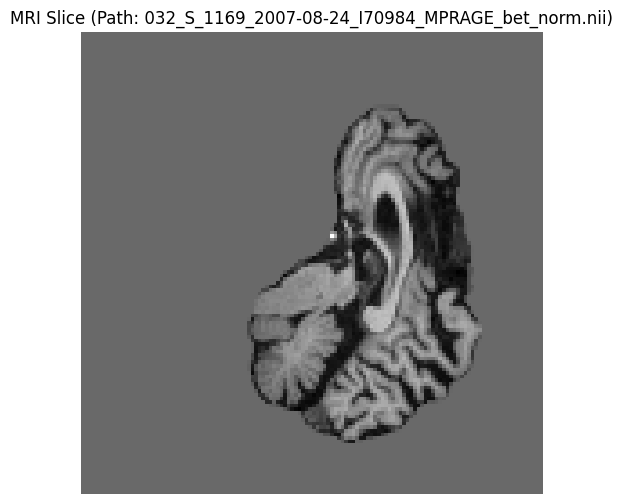

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (256, 256, 184)
Transposed shape: (184, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.6769, Max value: 10.7853, Mean: -0.0001, Std: 0.9410


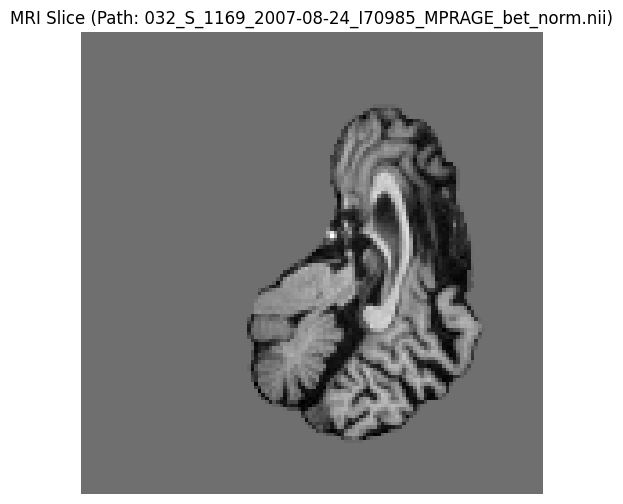

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.3598, Max value: 7.2973, Mean: 0.0001, Std: 0.9207


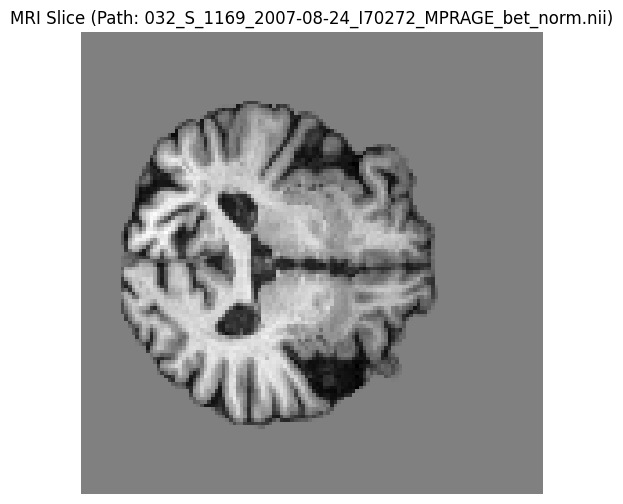

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -9.0168, Max value: 7.6600, Mean: 0.0000, Std: 0.9213


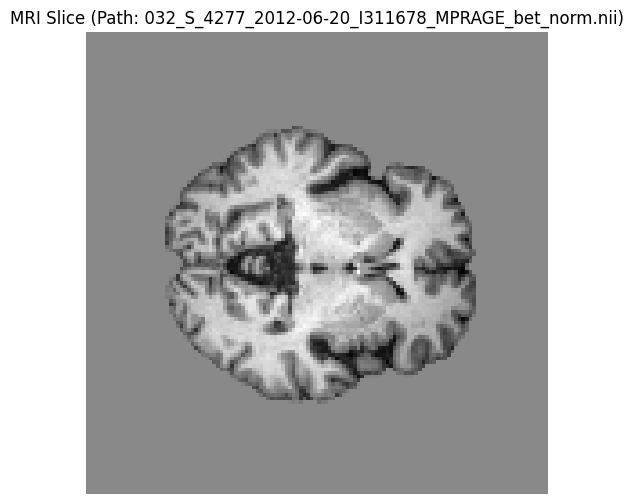

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 248, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.0138, Max value: 7.6943, Mean: 0.0000, Std: 0.9338


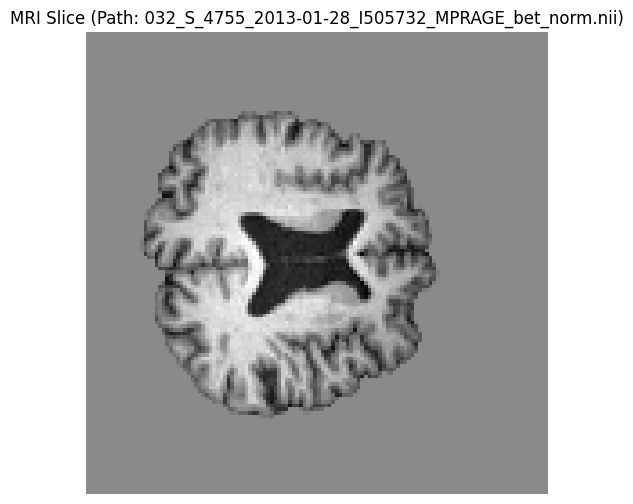

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.0577, Max value: 13.3846, Mean: -0.0002, Std: 0.9356


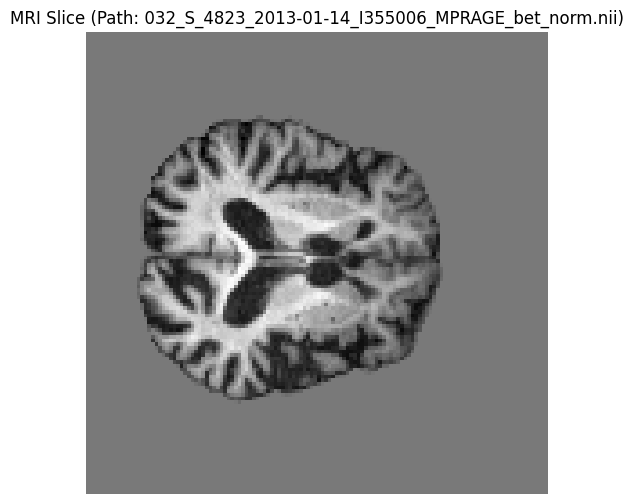

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.6998, Max value: 9.1525, Mean: -0.0000, Std: 0.9315


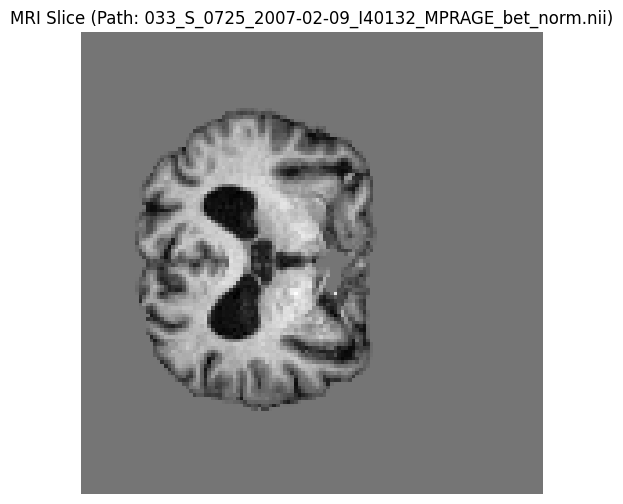

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 20.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.4395, Max value: 10.8222, Mean: -0.0001, Std: 0.9267


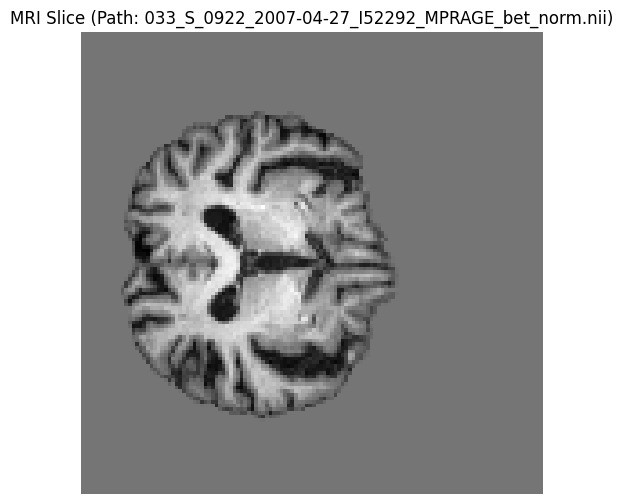

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 12.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.7346, Max value: 7.7521, Mean: -0.0002, Std: 0.9210


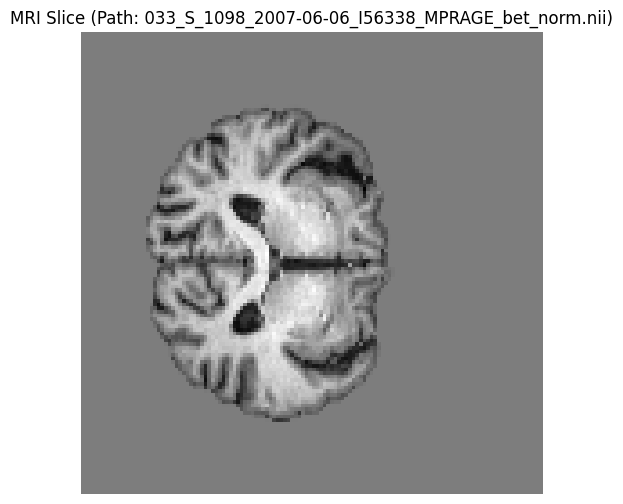

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 15.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.0426, Max value: 6.3945, Mean: -0.0002, Std: 0.9241


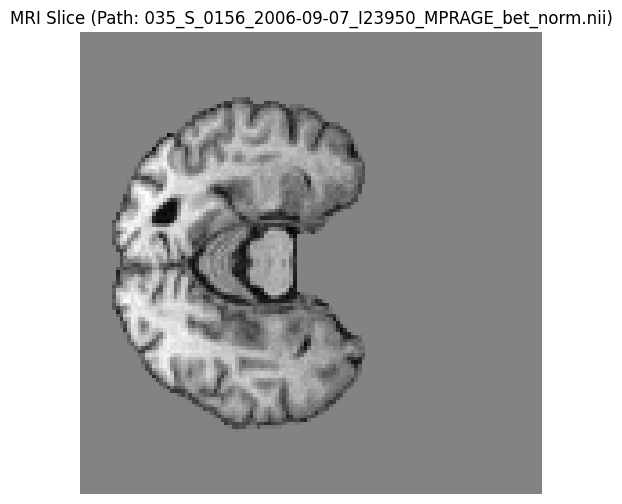

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 17.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.0985, Max value: 6.9863, Mean: 0.0000, Std: 0.9240


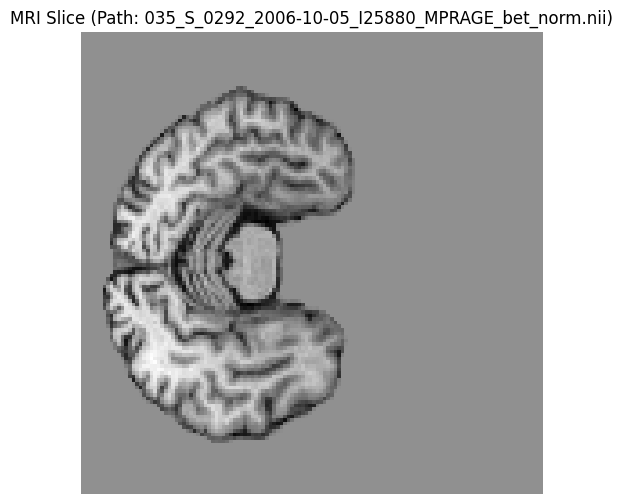

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.0055, Max value: 7.5871, Mean: -0.0001, Std: 0.9156


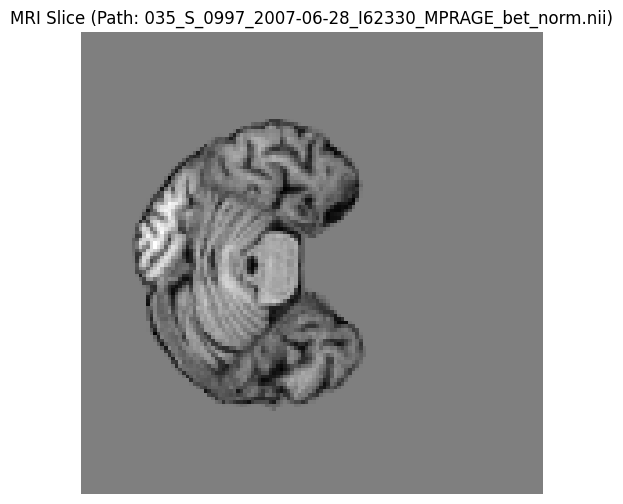

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 20.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -8.1816, Max value: 7.6748, Mean: -0.0001, Std: 0.9249


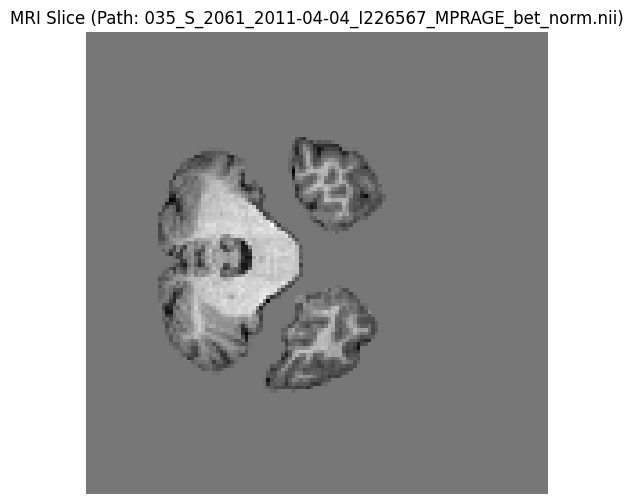

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -8.5004, Max value: 8.4026, Mean: -0.0000, Std: 0.9302


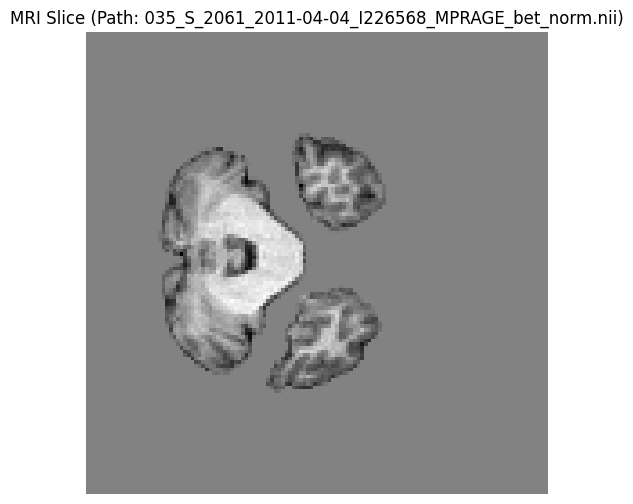

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -8.6599, Max value: 7.7031, Mean: 0.0001, Std: 0.9230


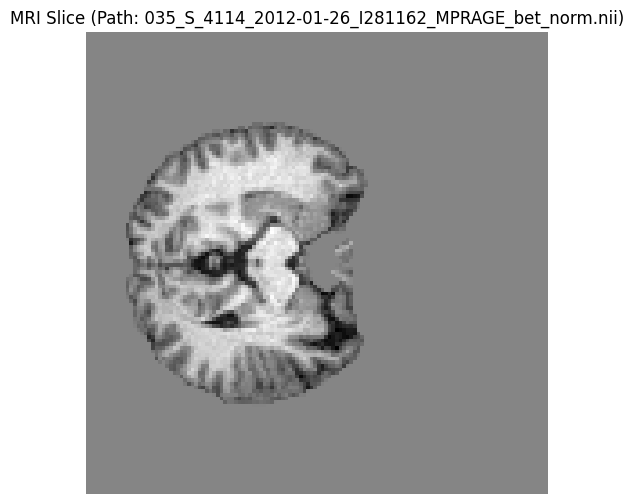

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 14.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.4620, Max value: 7.8531, Mean: -0.0001, Std: 0.9321


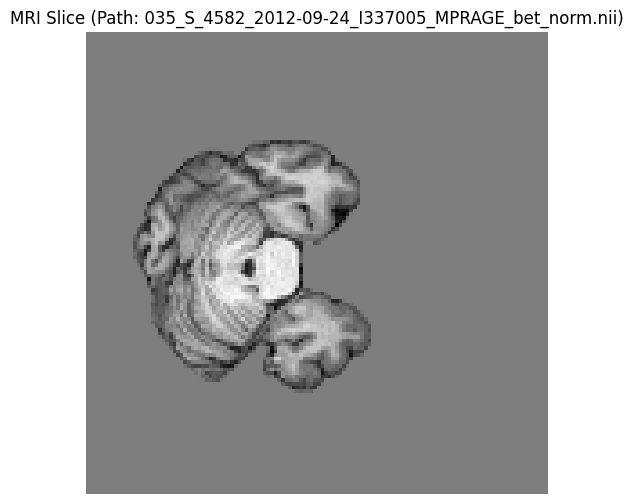

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.7151, Max value: 6.3787, Mean: 0.0001, Std: 0.9242


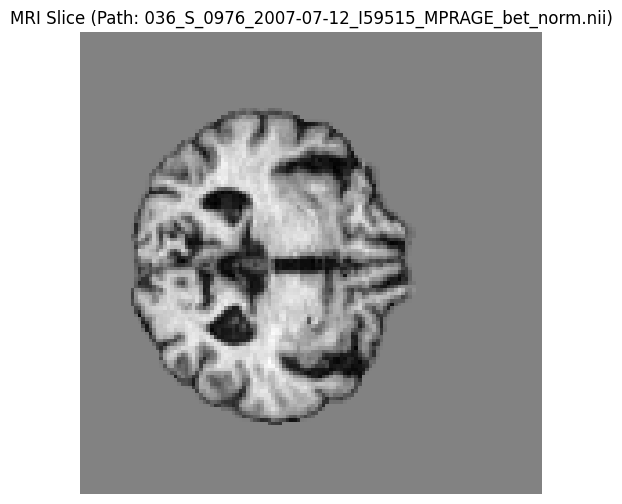

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 15.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.1693, Max value: 5.0779, Mean: -0.0001, Std: 0.9215


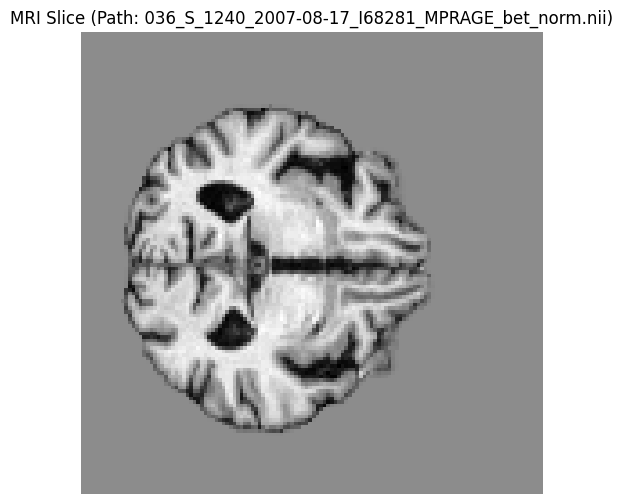

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -8.0310, Max value: 8.0019, Mean: -0.0000, Std: 0.9314


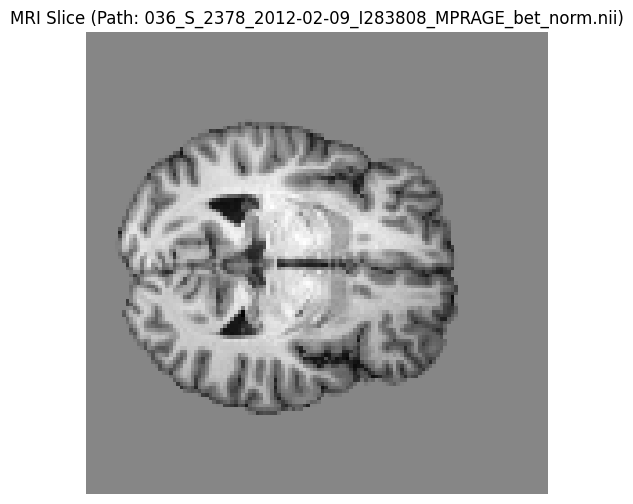

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 19.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.8796, Max value: 8.4731, Mean: 0.0000, Std: 0.9272


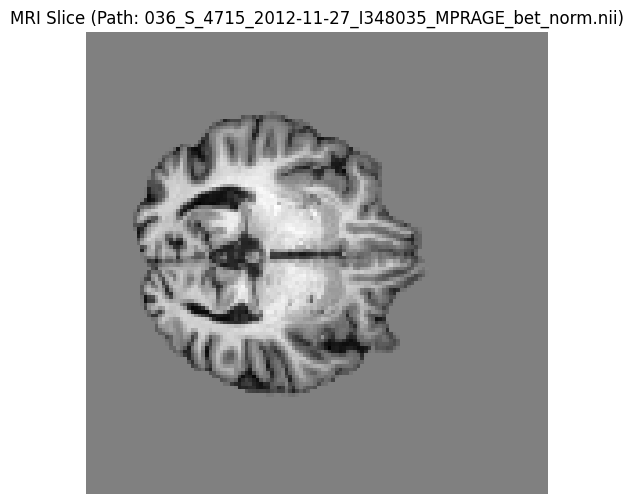

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.0712, Max value: 15.2704, Mean: 0.0000, Std: 0.9343


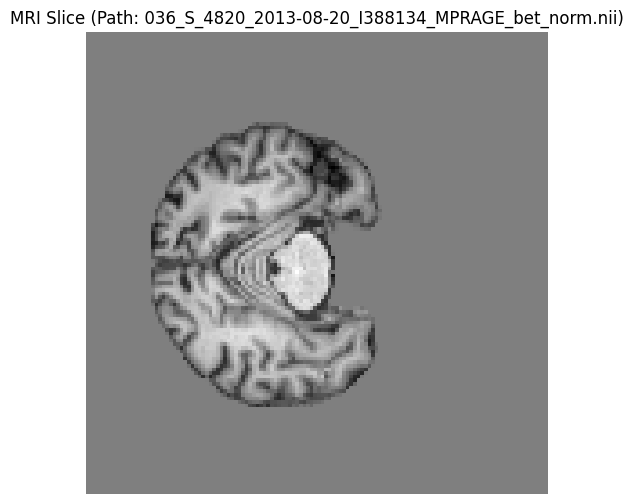

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 14.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.2259, Max value: 18.8875, Mean: -0.0000, Std: 0.9433


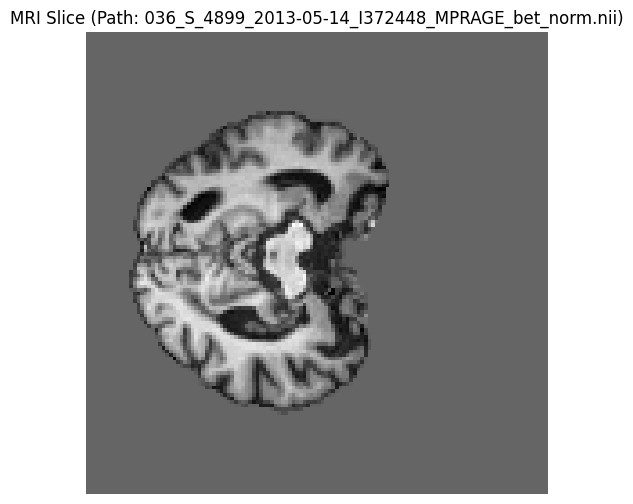

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.2280, Max value: 8.4046, Mean: 0.0000, Std: 0.9291


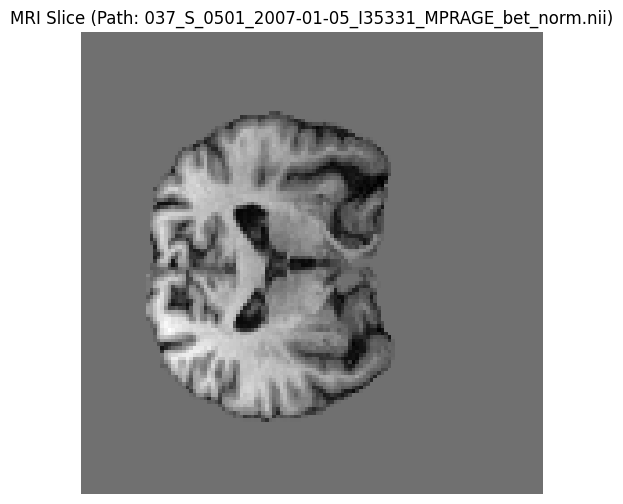

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 13.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.3311, Max value: 10.8906, Mean: -0.0000, Std: 0.9256


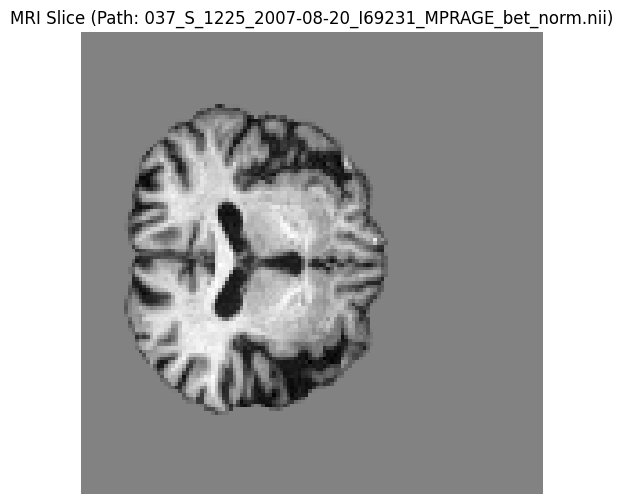

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 20.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.0368, Max value: 15.3333, Mean: 0.0000, Std: 0.9282


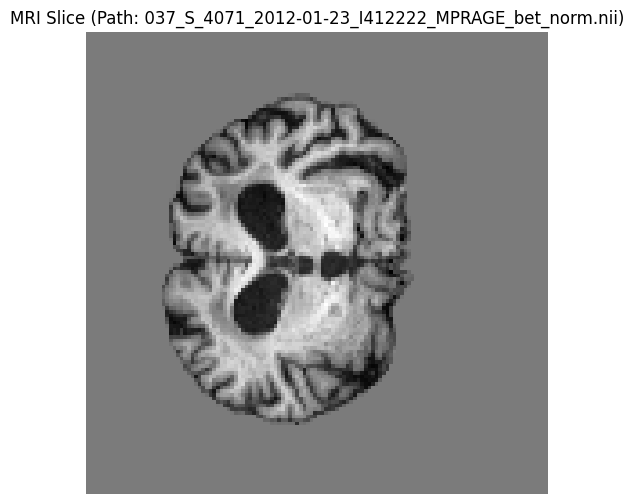

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 13.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.7718, Max value: 8.8733, Mean: 0.0000, Std: 0.9342


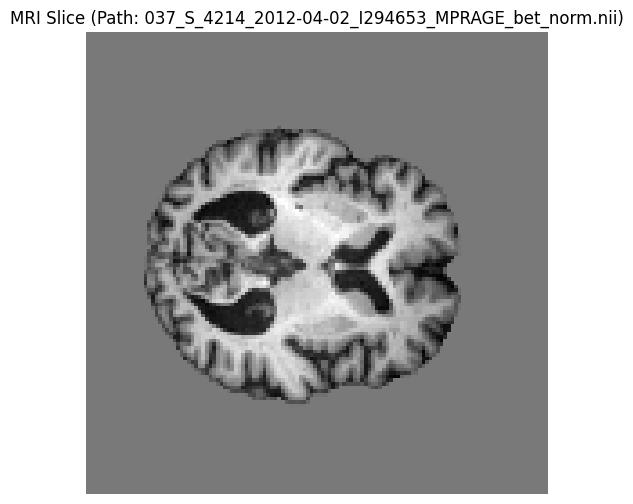

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 20.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -8.4287, Max value: 8.1660, Mean: 0.0001, Std: 0.9258


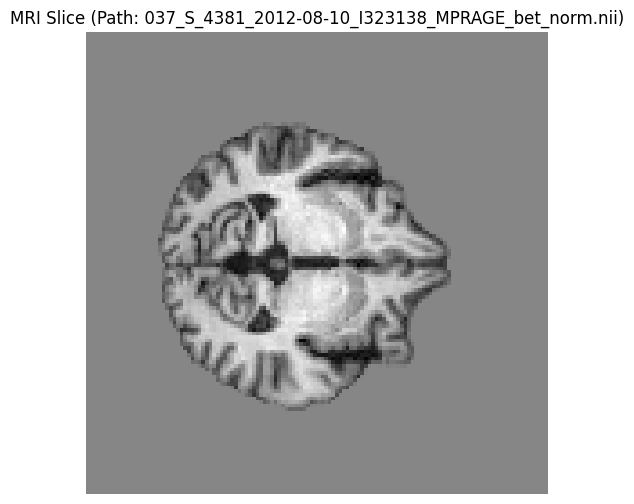

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 17.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -8.4938, Max value: 9.2419, Mean: 0.0001, Std: 0.9292


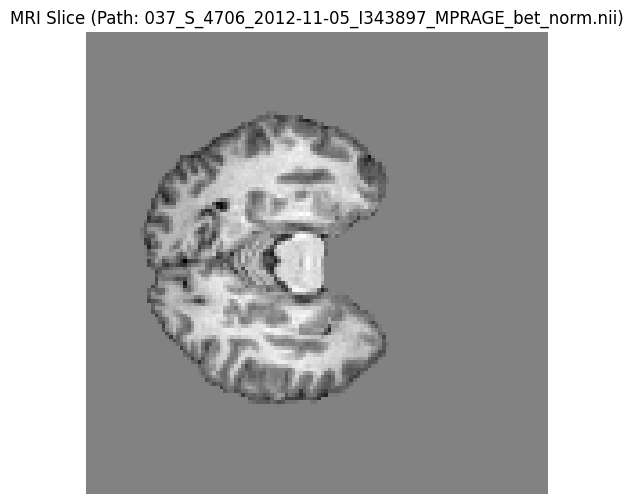

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 14.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.9773, Max value: 8.9566, Mean: -0.0001, Std: 0.9275


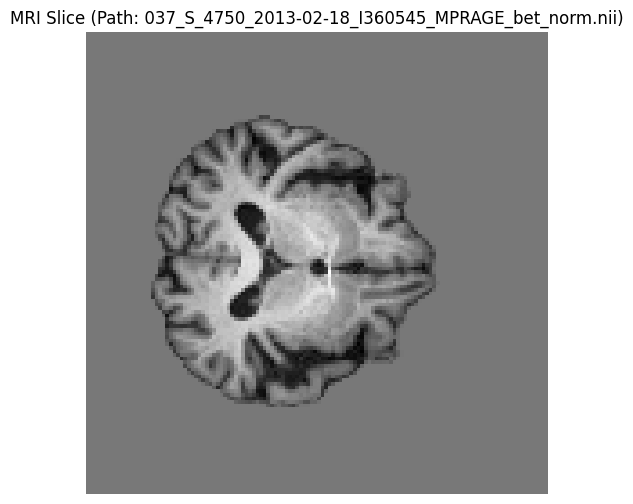

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.5960, Max value: 7.2077, Mean: 0.0000, Std: 0.9231


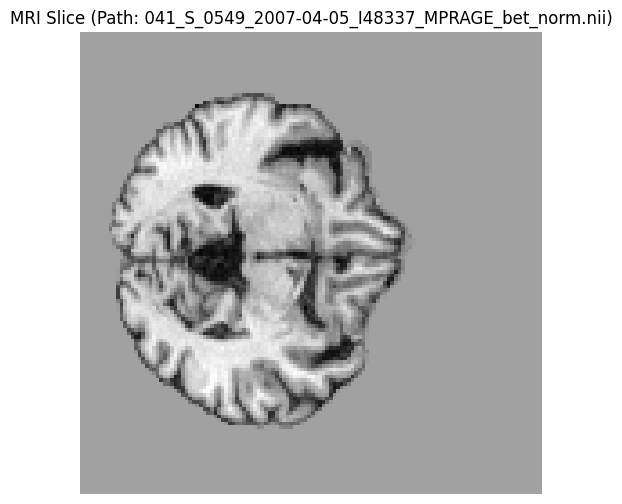

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 14.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -5.4641, Max value: 8.0049, Mean: -0.0001, Std: 0.9325


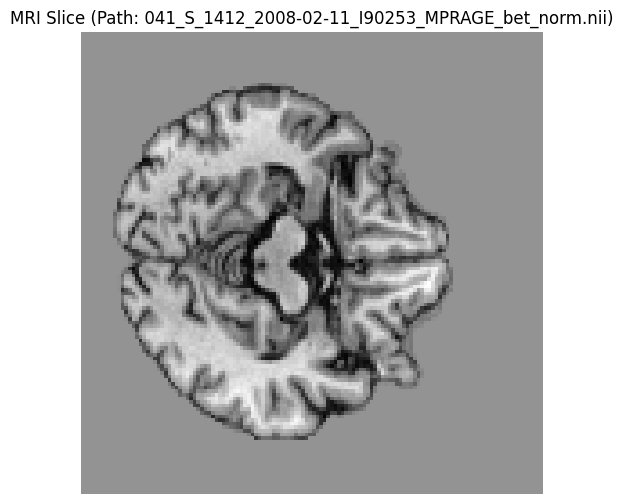

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.0403, Max value: 7.4419, Mean: -0.0001, Std: 0.9280


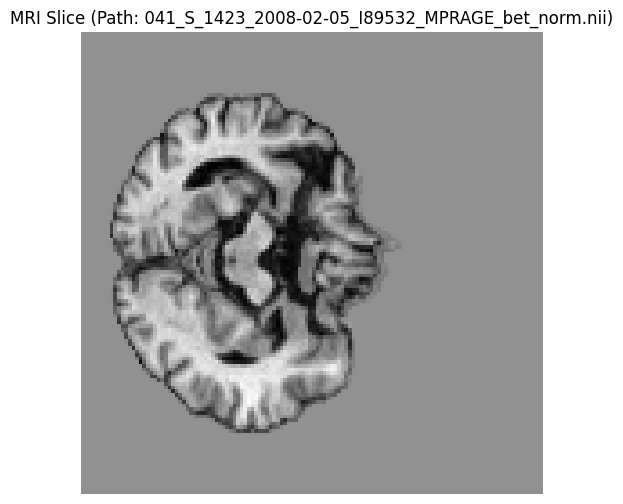

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 19.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.0419, Max value: 5.9184, Mean: -0.0001, Std: 0.9162


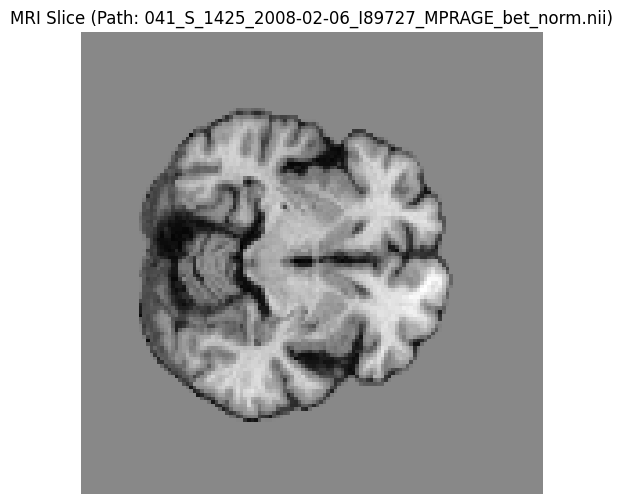

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.7824, Max value: 7.8937, Mean: -0.0001, Std: 0.9238


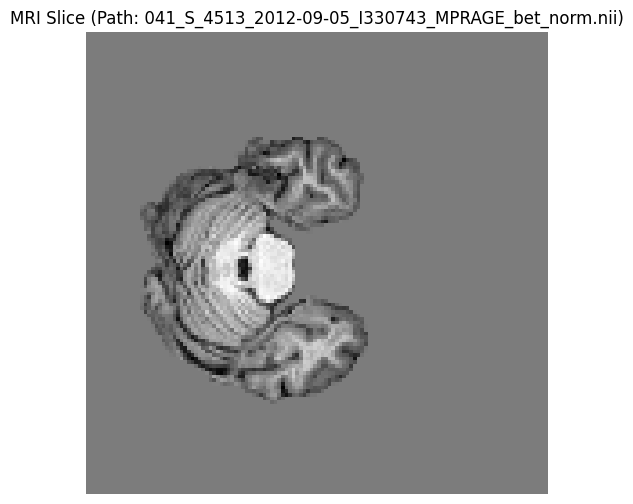

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 19.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.7813, Max value: 7.8364, Mean: -0.0000, Std: 0.9235


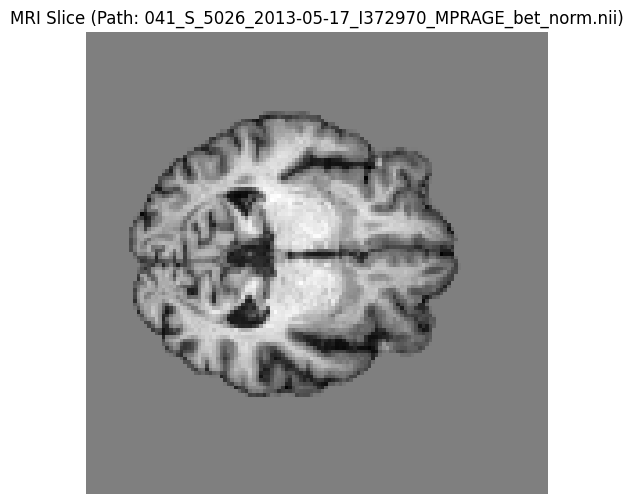

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.7693, Max value: 7.4439, Mean: 0.0000, Std: 0.9285


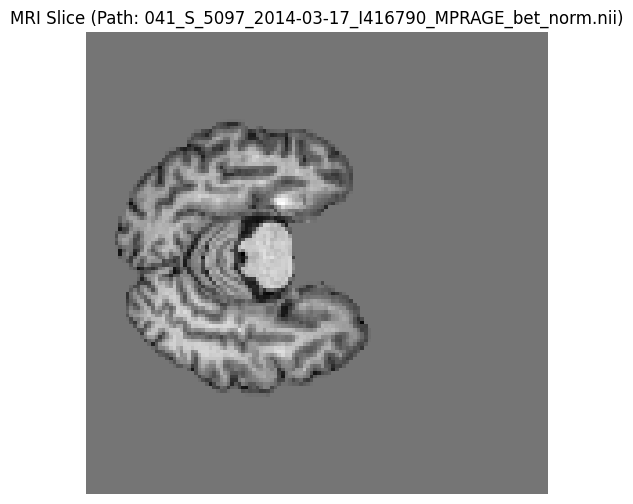

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.0995, Max value: 7.5701, Mean: -0.0000, Std: 0.9293


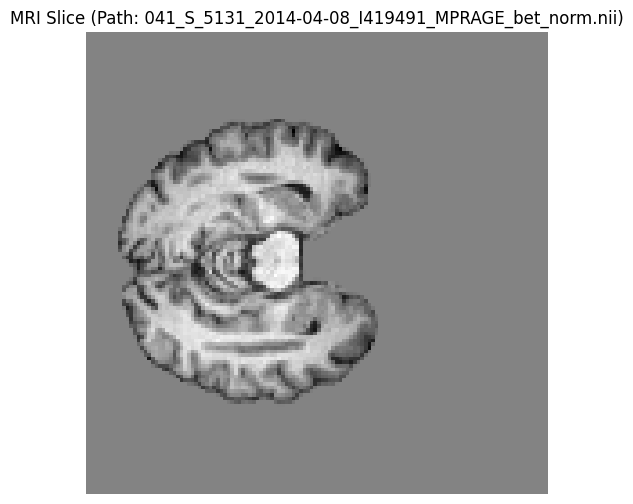

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 14.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.3677, Max value: 6.7557, Mean: -0.0000, Std: 0.9202


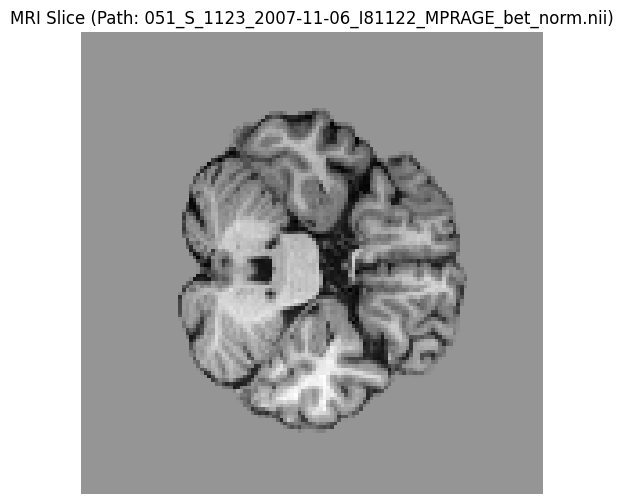

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.9790, Max value: 7.8211, Mean: 0.0001, Std: 0.9283


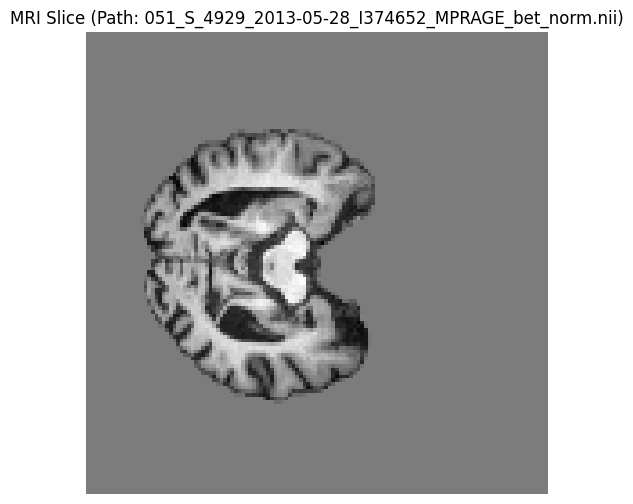

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 15.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (170, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -8.2710, Max value: 8.2870, Mean: -0.0000, Std: 0.9413


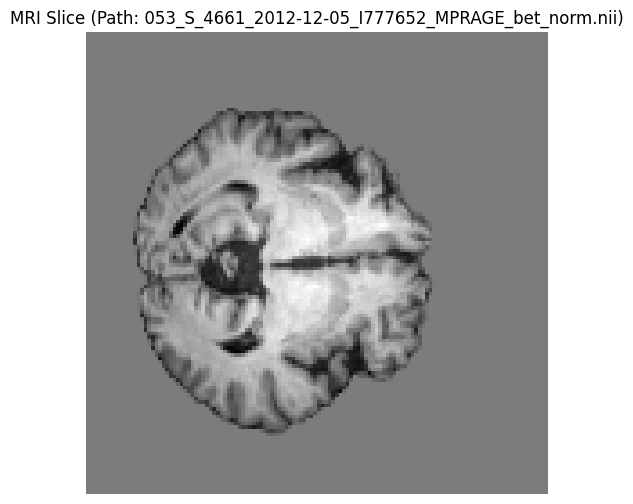

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (170, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -8.8391, Max value: 8.5242, Mean: -0.0001, Std: 0.9417


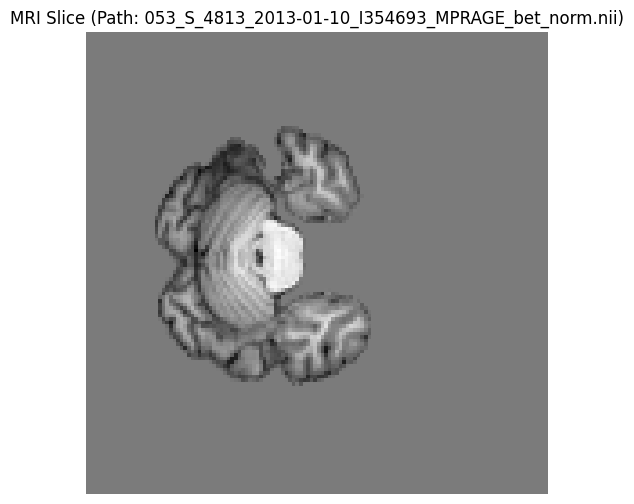

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -5.3100, Max value: 7.8475, Mean: 0.0000, Std: 0.9252


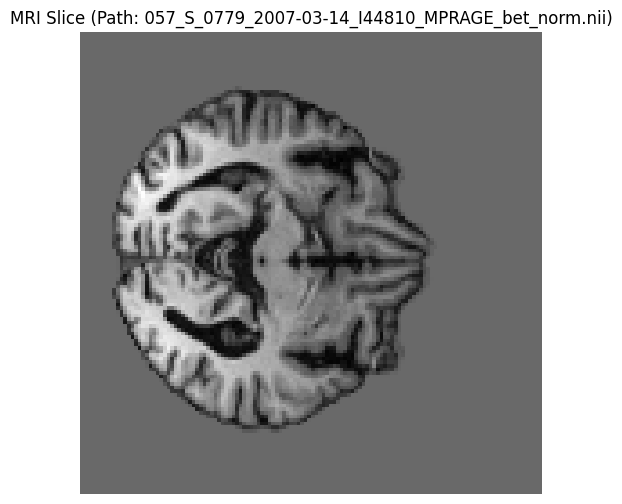

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 13.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.7645, Max value: 8.4818, Mean: -0.0000, Std: 0.9196


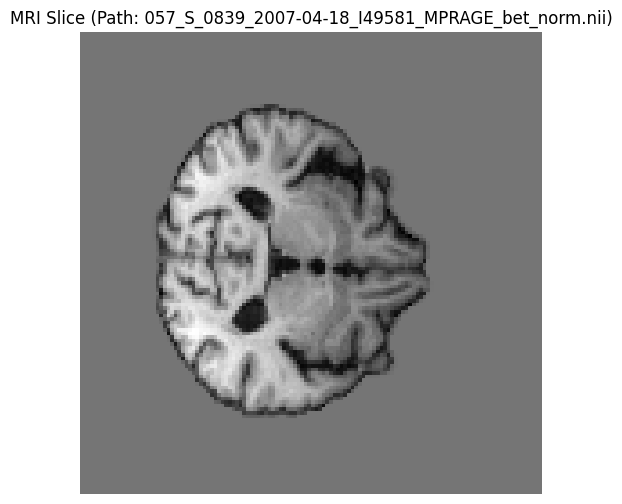

Demographic features shape: (1, 3)
Sample demographic data (first row): [0. 1. 9.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -5.1489, Max value: 7.8952, Mean: 0.0000, Std: 0.9288


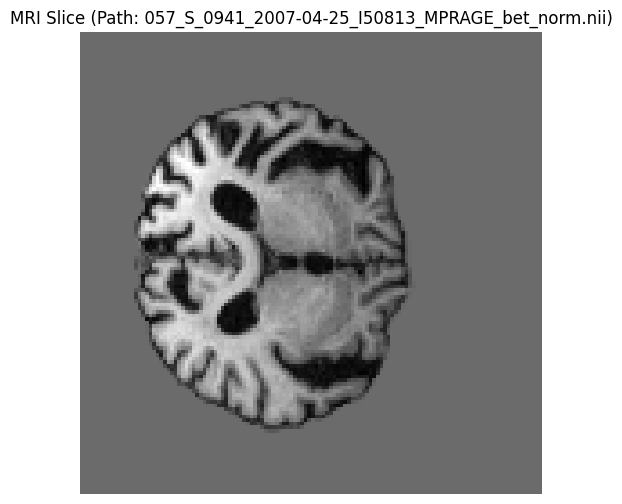

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 14.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.1393, Max value: 7.1358, Mean: -0.0001, Std: 0.9272


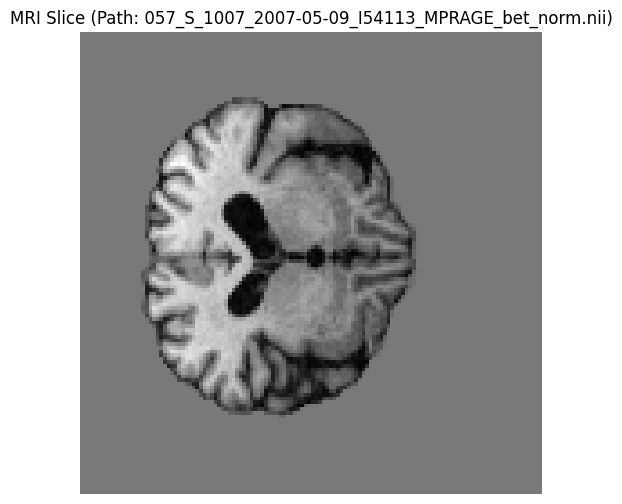

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 17.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.7438, Max value: 8.9784, Mean: -0.0001, Std: 0.9272


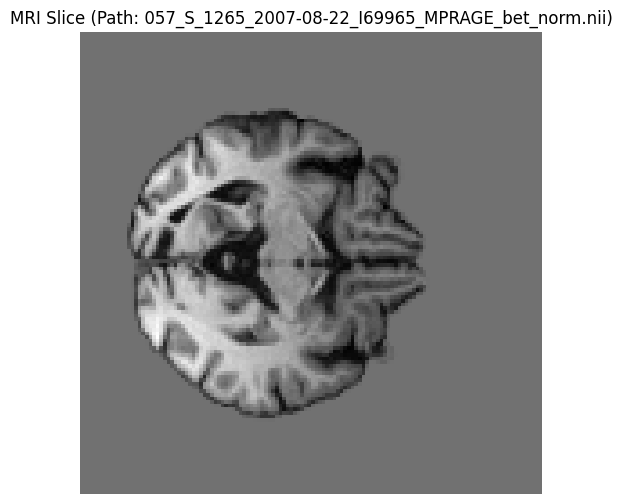

Demographic features shape: (1, 3)
Sample demographic data (first row): [0. 1. 8.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -5.4776, Max value: 7.3020, Mean: 0.0000, Std: 0.9248


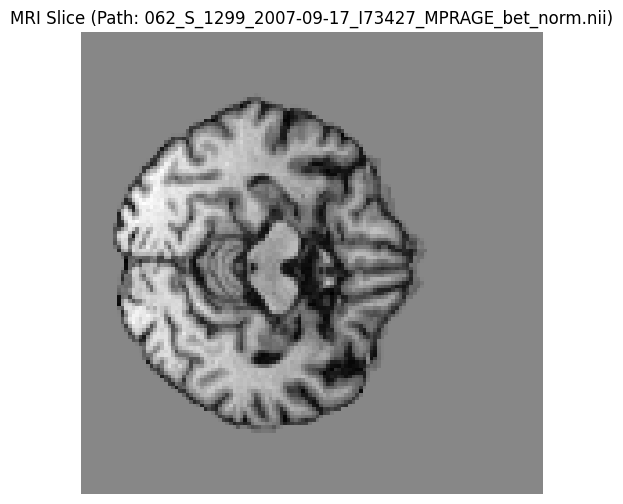

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 14.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.1229, Max value: 6.1143, Mean: 0.0000, Std: 0.9239


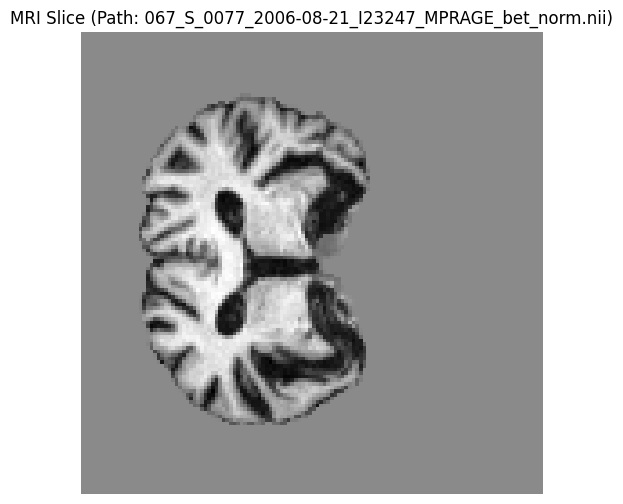

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.0717, Max value: 7.3202, Mean: 0.0000, Std: 0.9333


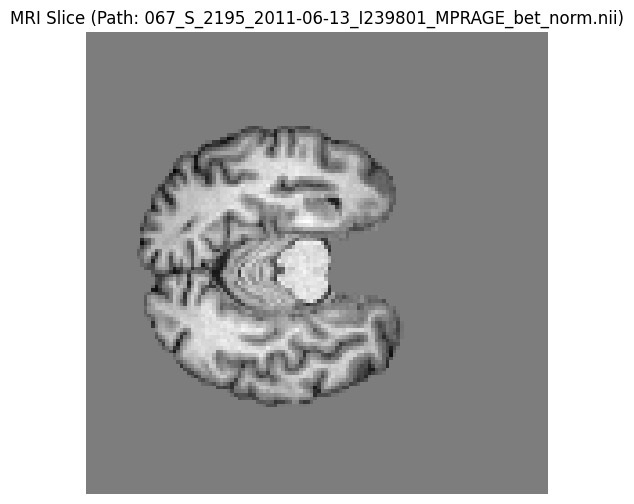

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 13.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.9273, Max value: 8.3332, Mean: 0.0001, Std: 0.9256


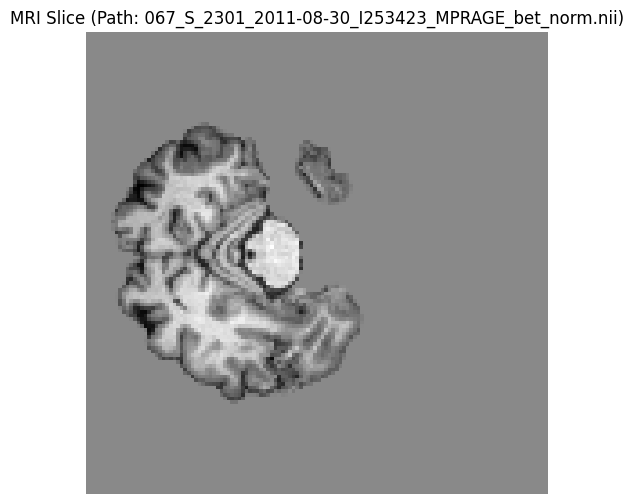

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 19.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.7091, Max value: 7.4652, Mean: -0.0000, Std: 0.9289


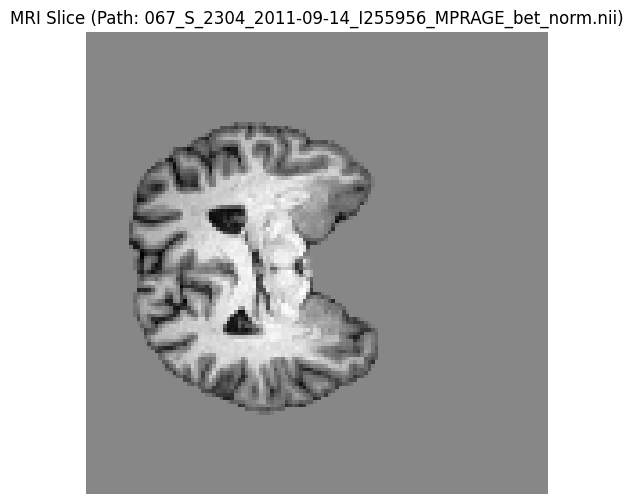

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 17.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -9.2734, Max value: 7.9425, Mean: -0.0000, Std: 0.9190


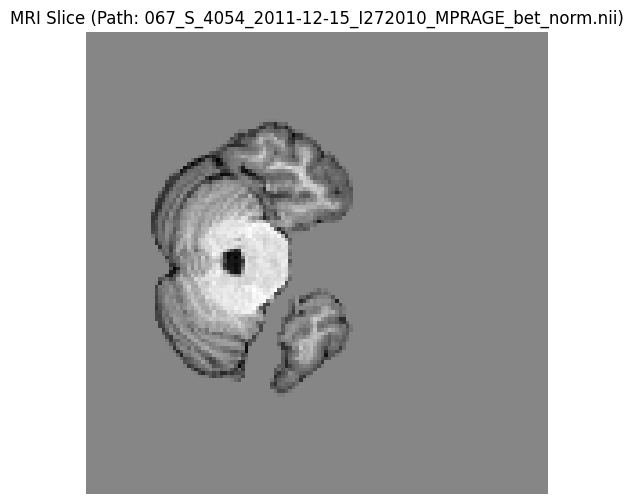

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 19.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.8315, Max value: 7.0203, Mean: 0.0001, Std: 0.9293


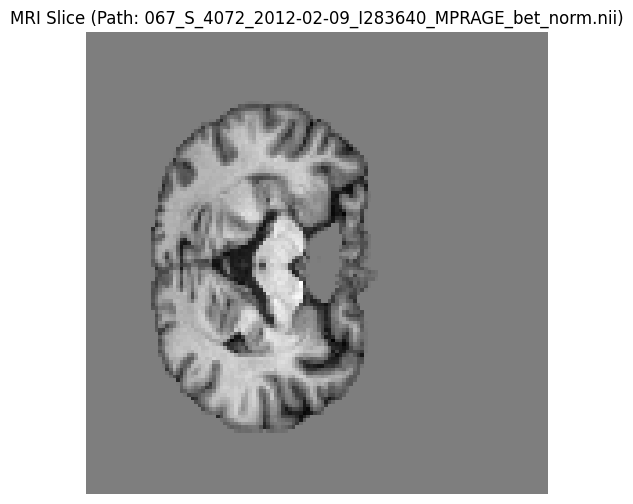

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.1920, Max value: 7.6164, Mean: 0.0000, Std: 0.9276


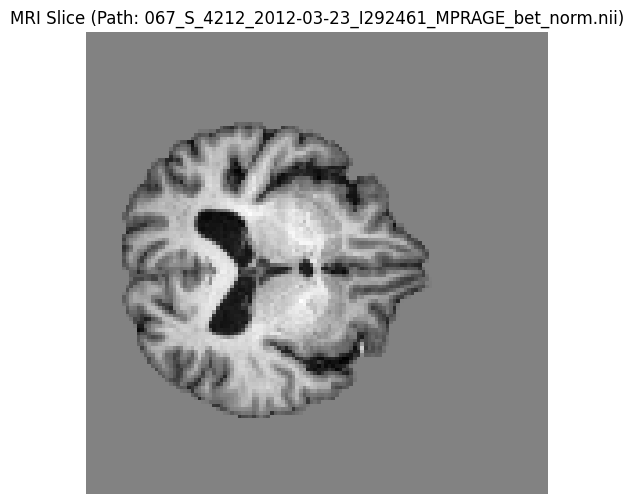

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 20.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -8.0677, Max value: 7.8243, Mean: 0.0000, Std: 0.9299


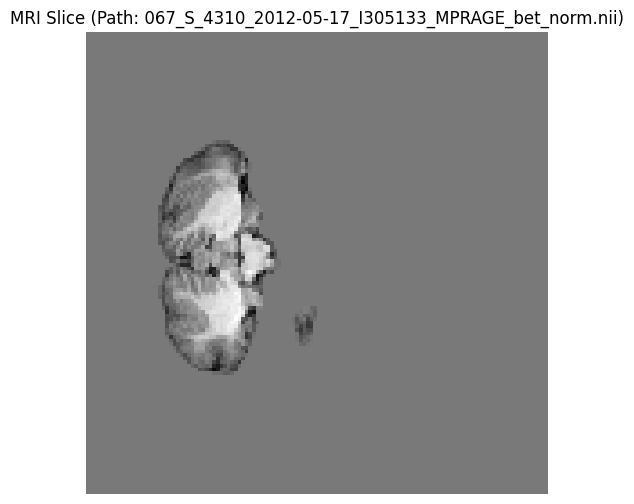

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 17.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.9757, Max value: 8.8507, Mean: 0.0001, Std: 0.9327


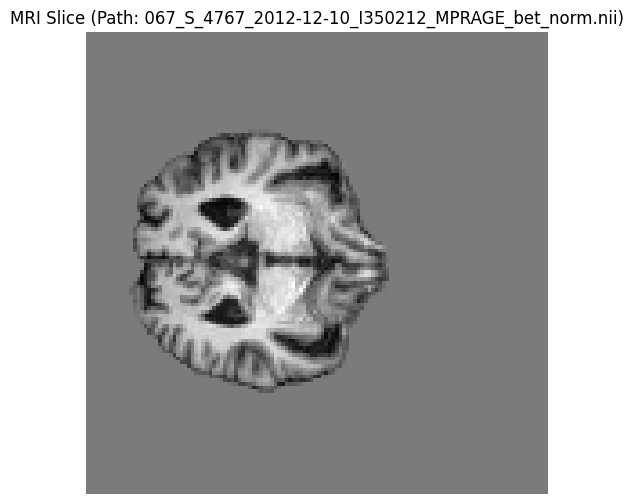

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.8147, Max value: 7.1906, Mean: -0.0000, Std: 0.9293


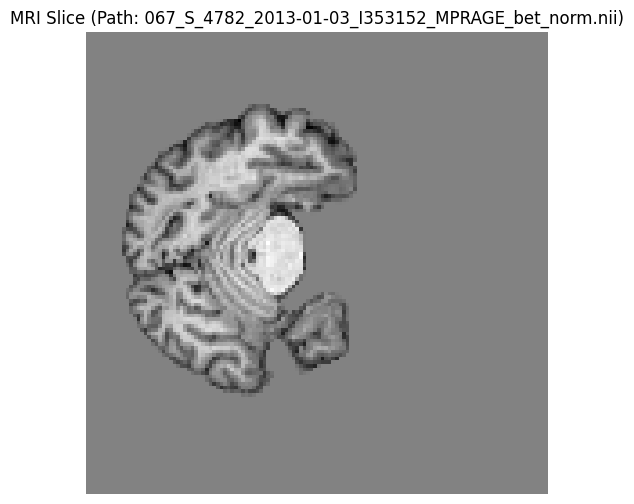

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.3096, Max value: 7.3293, Mean: -0.0001, Std: 0.9296


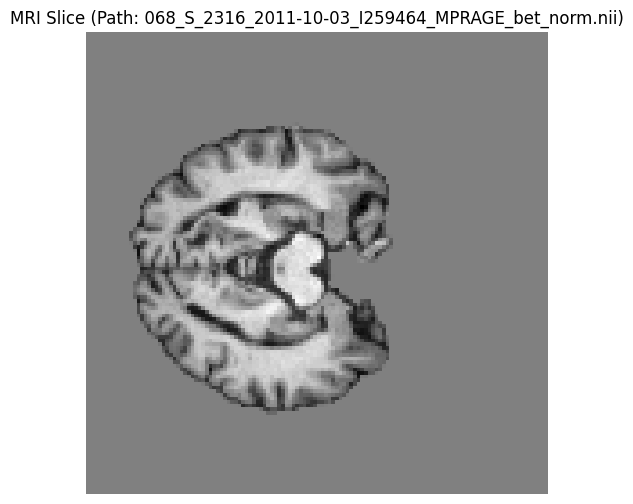

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 12.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.5267, Max value: 12.3113, Mean: 0.0000, Std: 0.9280


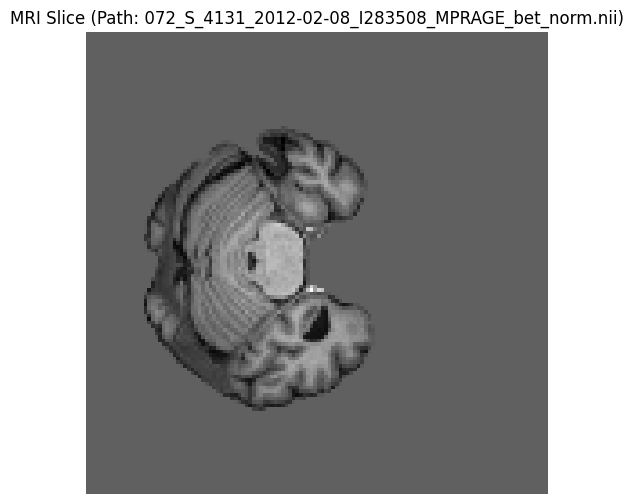

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.1011, Max value: 7.3682, Mean: 0.0000, Std: 0.9206


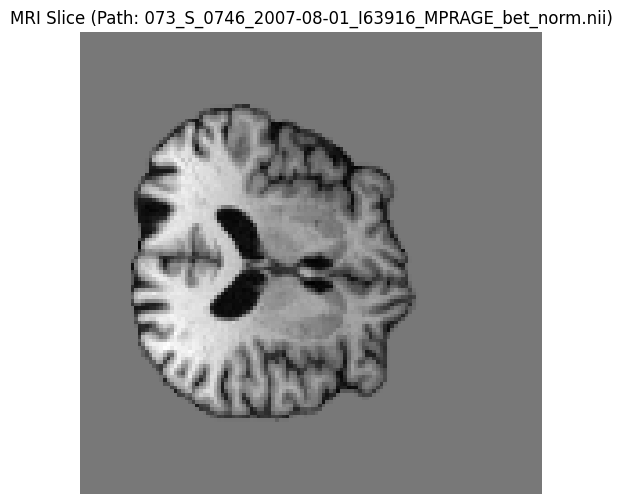

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.7258, Max value: 11.3431, Mean: -0.0001, Std: 0.9287


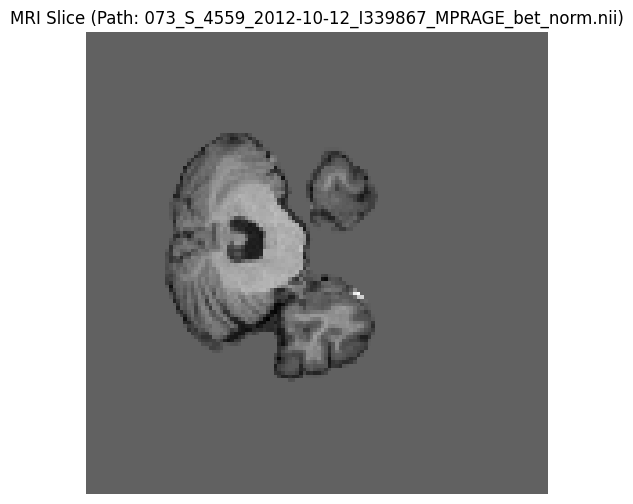

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 20.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -4.7884, Max value: 6.5020, Mean: -0.0000, Std: 0.9239


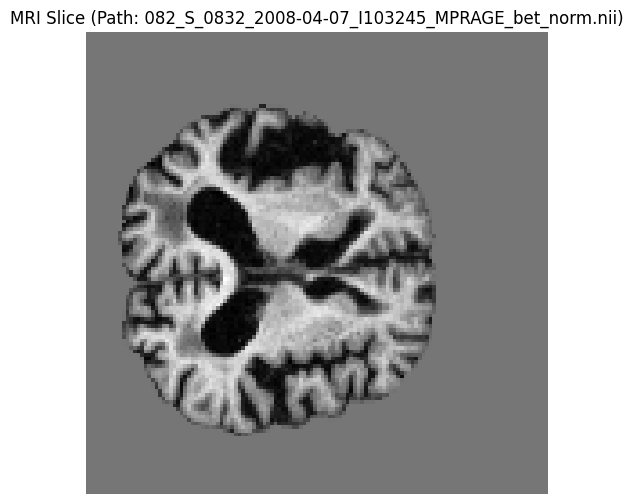

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 19.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.6967, Max value: 9.2722, Mean: 0.0002, Std: 0.9258


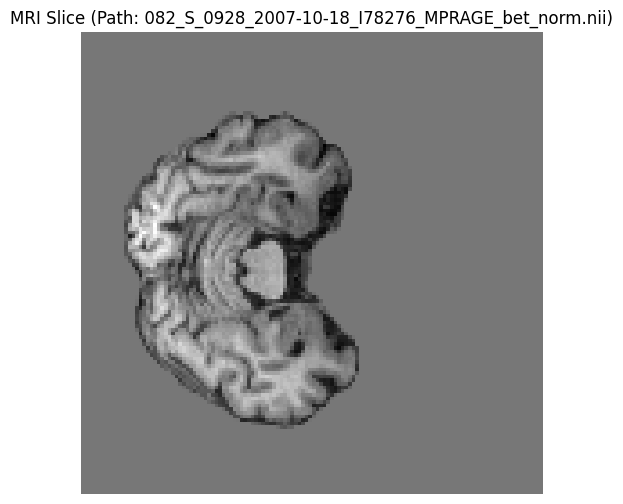

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 20.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -5.8544, Max value: 5.2594, Mean: 0.0001, Std: 0.9313


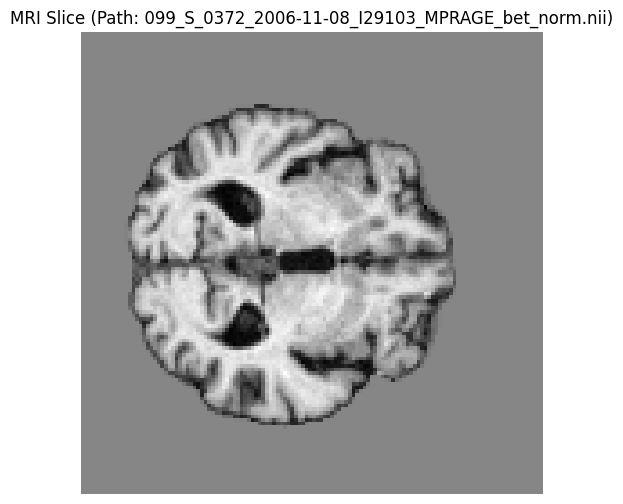

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 20.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.1774, Max value: 12.2186, Mean: 0.0003, Std: 0.9210


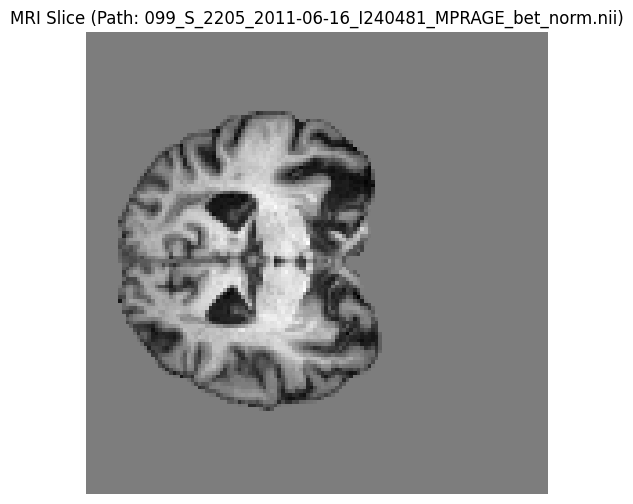

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 12.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.3417, Max value: 5.6920, Mean: 0.0000, Std: 0.9230


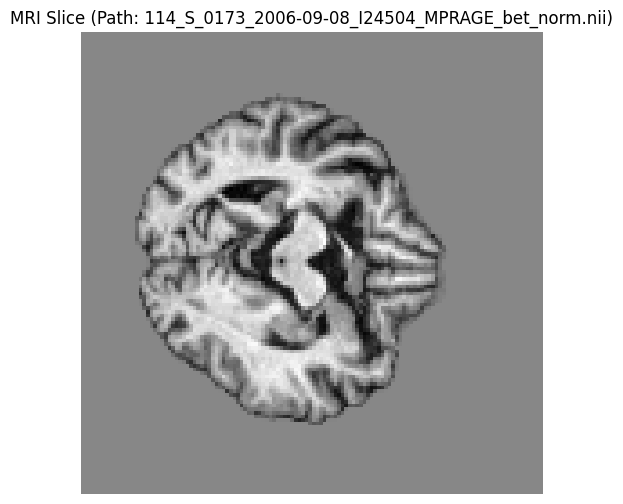

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -5.2870, Max value: 5.2299, Mean: 0.0002, Std: 0.9310


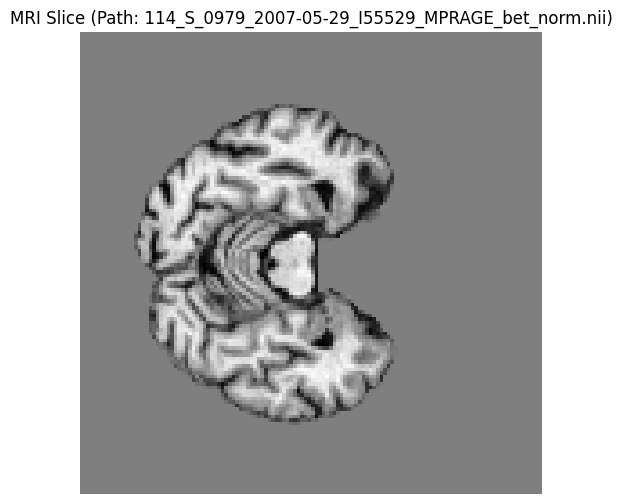

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.3984, Max value: 6.7764, Mean: 0.0001, Std: 0.9226


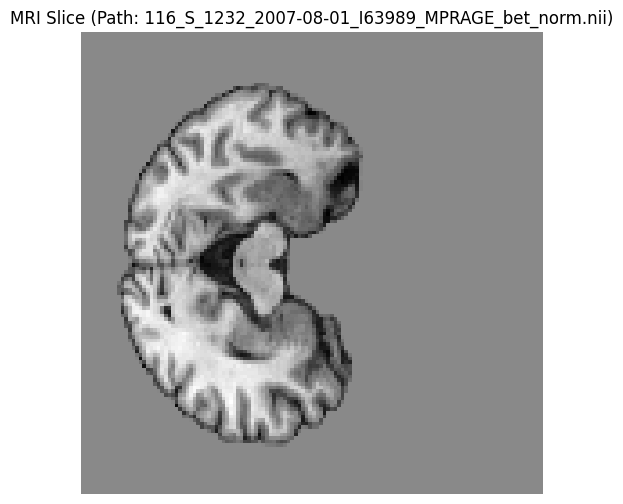

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 14.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.2848, Max value: 8.3792, Mean: 0.0001, Std: 0.9316


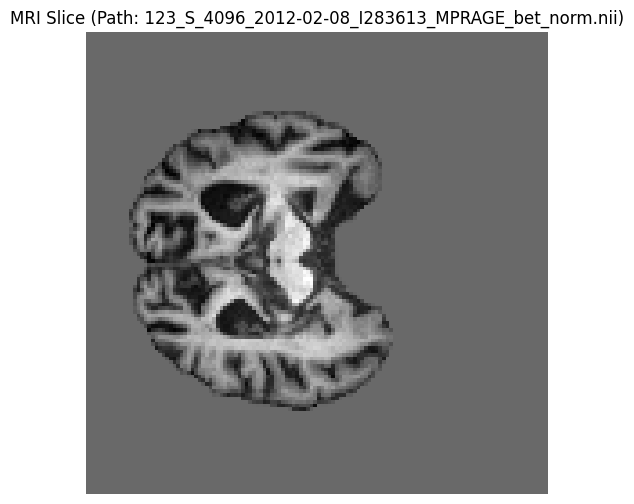

Demographic features shape: (1, 3)
Sample demographic data (first row): [0. 0. 9.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.8779, Max value: 7.8312, Mean: -0.0001, Std: 0.9241


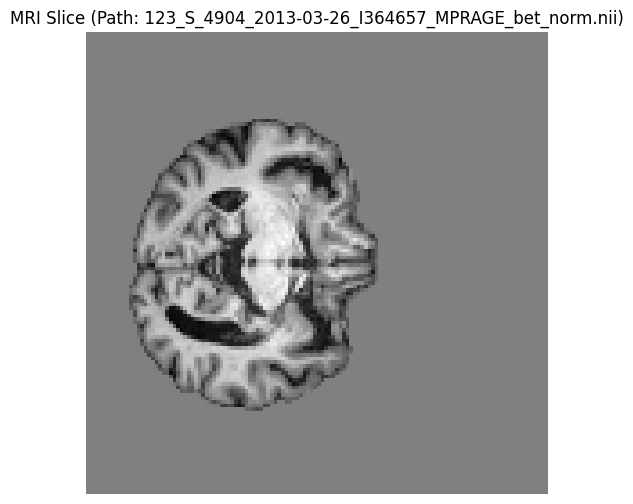

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 12.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.2487, Max value: 6.4031, Mean: -0.0001, Std: 0.9281


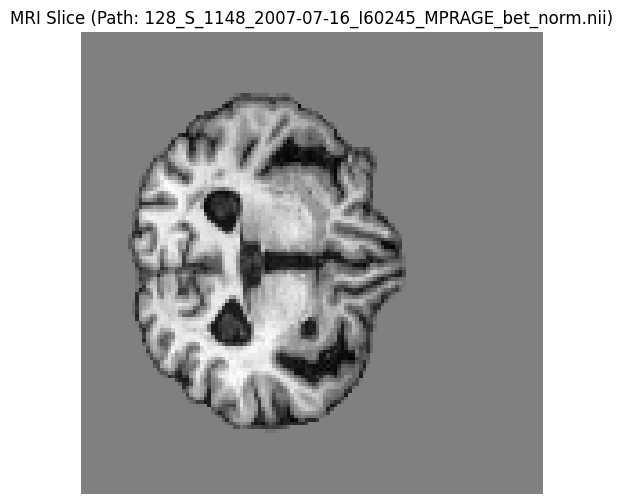

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 14.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -8.0561, Max value: 7.9139, Mean: 0.0001, Std: 0.9286


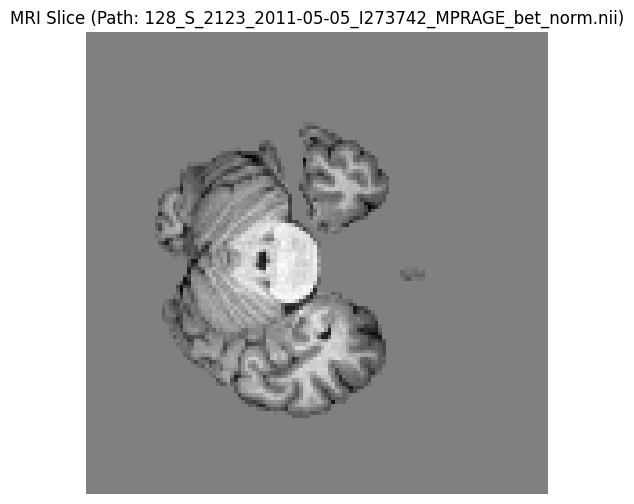

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.0812, Max value: 10.0310, Mean: 0.0001, Std: 0.9333


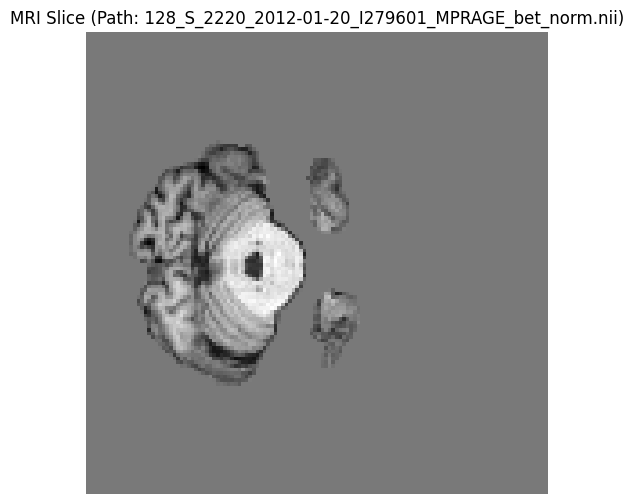

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 20.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.2262, Max value: 11.9569, Mean: 0.0000, Std: 0.9363


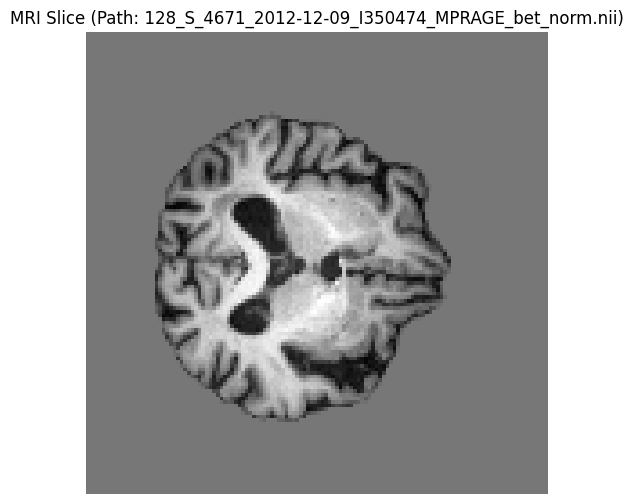

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 15.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (170, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -9.1222, Max value: 8.0928, Mean: 0.0001, Std: 0.9291


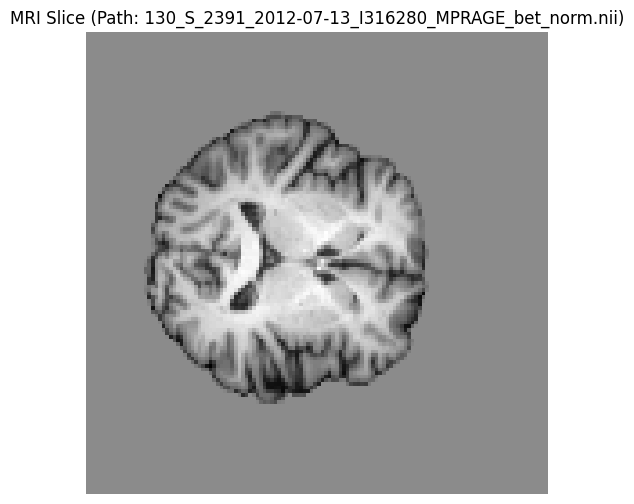

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 12.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (170, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -8.2274, Max value: 10.3315, Mean: 0.0001, Std: 0.9328


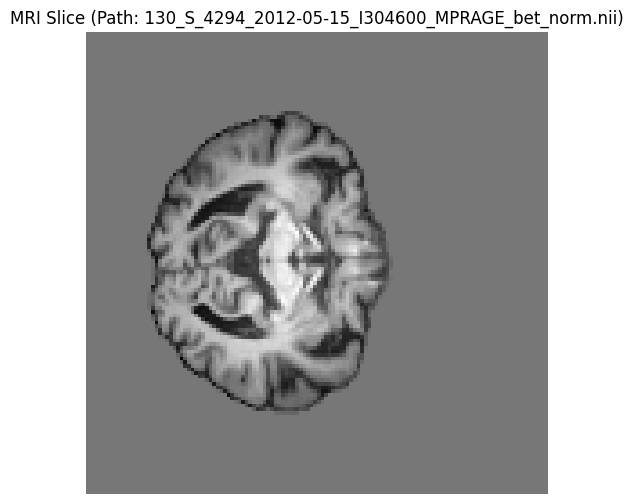

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (170, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.3388, Max value: 7.7290, Mean: 0.0001, Std: 0.9368


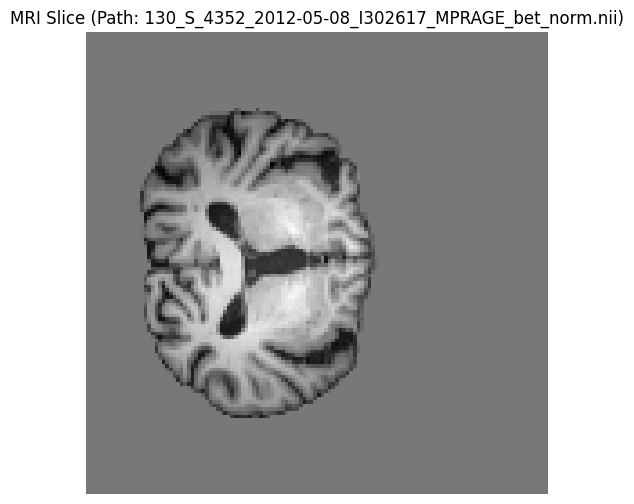

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (170, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -9.5651, Max value: 9.7159, Mean: 0.0001, Std: 0.9324


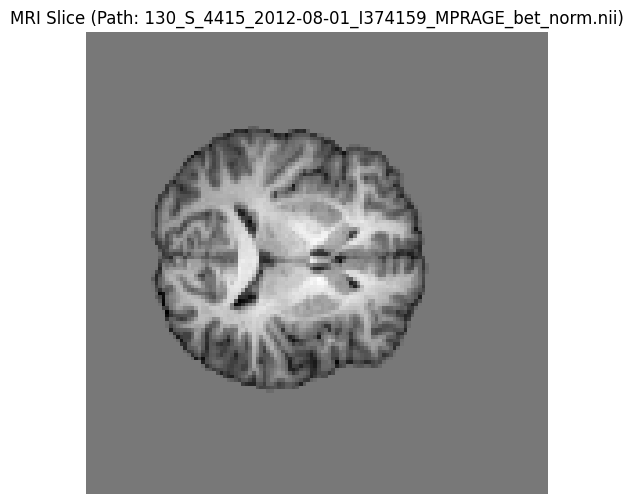

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 13.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (170, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.1957, Max value: 17.2416, Mean: 0.0001, Std: 0.9331


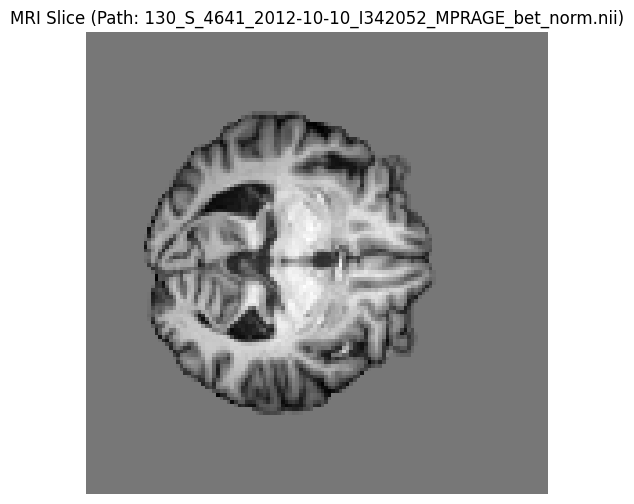

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 20.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (170, 256, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -8.1736, Max value: 8.5724, Mean: -0.0001, Std: 0.9282


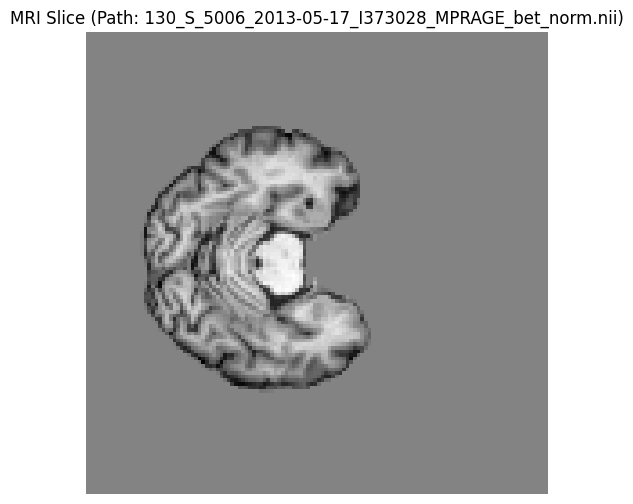

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 14.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.3444, Max value: 30.7634, Mean: 0.0000, Std: 0.9242


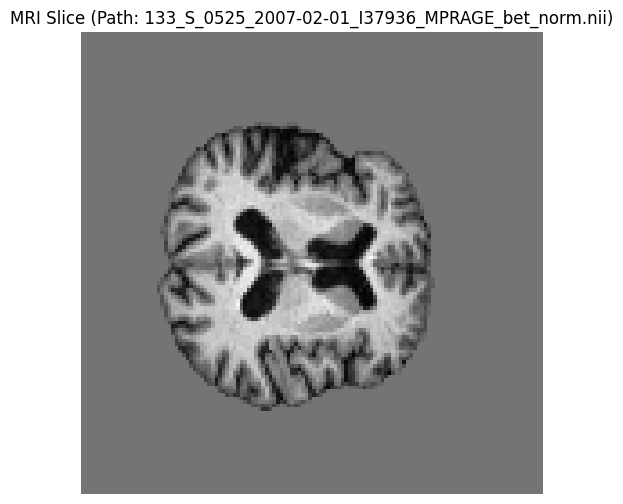

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.8383, Max value: 7.0246, Mean: -0.0000, Std: 0.9279


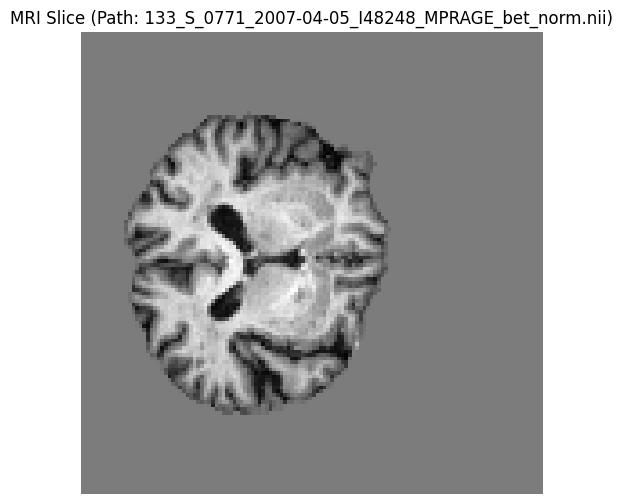

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 19.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.7406, Max value: 12.1780, Mean: 0.0000, Std: 0.9254


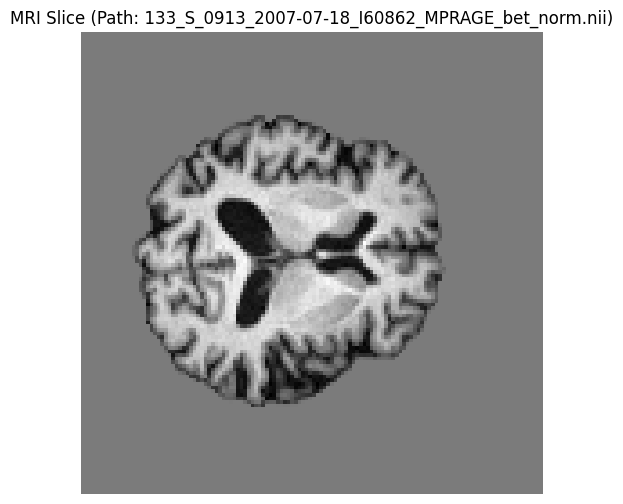

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 15.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.5986, Max value: 12.4761, Mean: 0.0000, Std: 0.9254


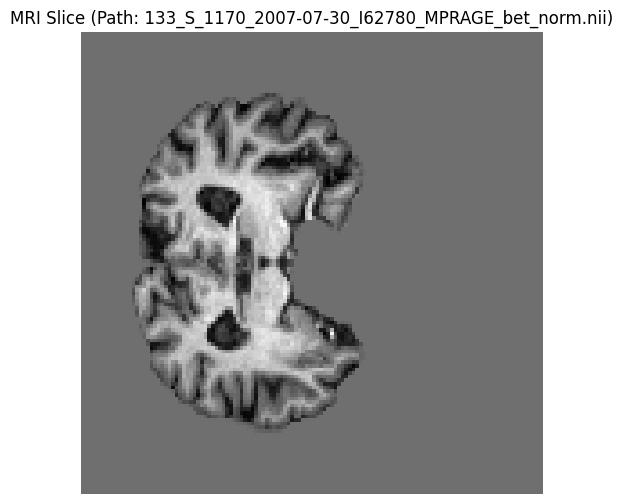

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 13.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.2705, Max value: 7.9621, Mean: 0.0001, Std: 0.9320


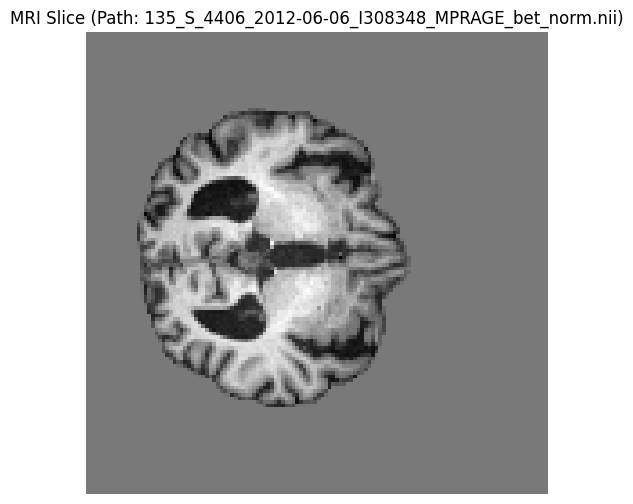

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 19.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -8.6513, Max value: 7.9721, Mean: 0.0001, Std: 0.9218


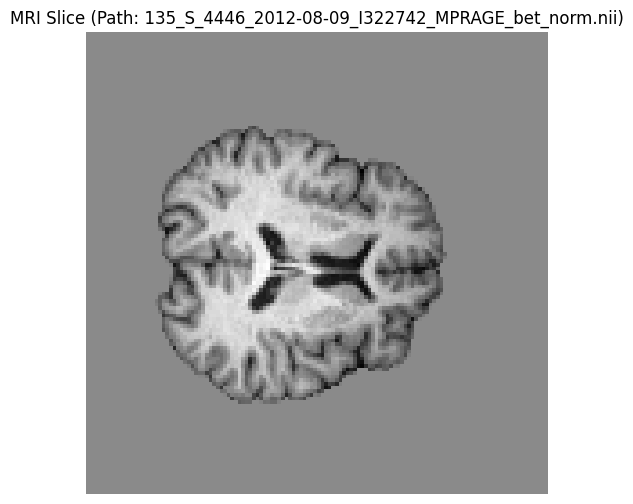

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 15.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.3910, Max value: 8.2294, Mean: 0.0000, Std: 0.9320


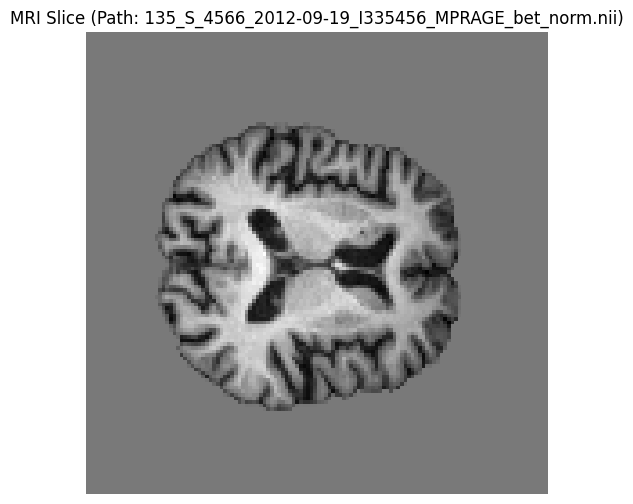

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 12.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.9723, Max value: 6.6789, Mean: 0.0000, Std: 0.9344


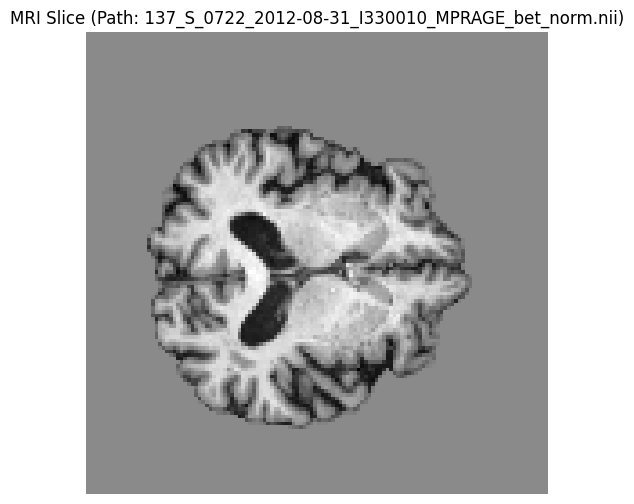

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 12.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.1442, Max value: 7.9451, Mean: -0.0001, Std: 0.9301


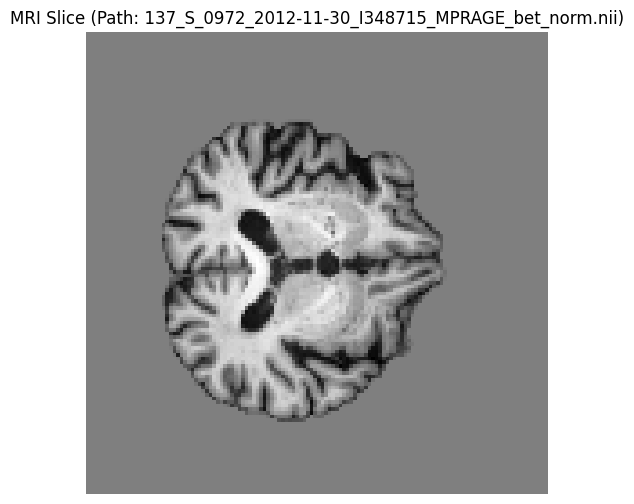

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.3183, Max value: 26.5782, Mean: 0.0002, Std: 0.9259


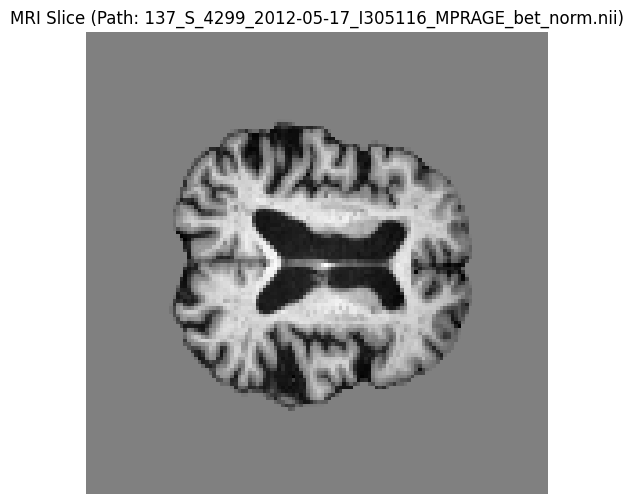

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 12.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.1392, Max value: 7.1344, Mean: 0.0000, Std: 0.9293


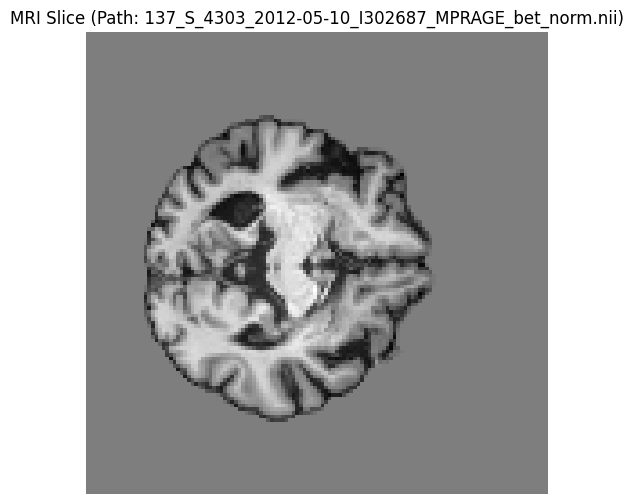

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 20.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.3489, Max value: 7.8936, Mean: 0.0000, Std: 0.9334


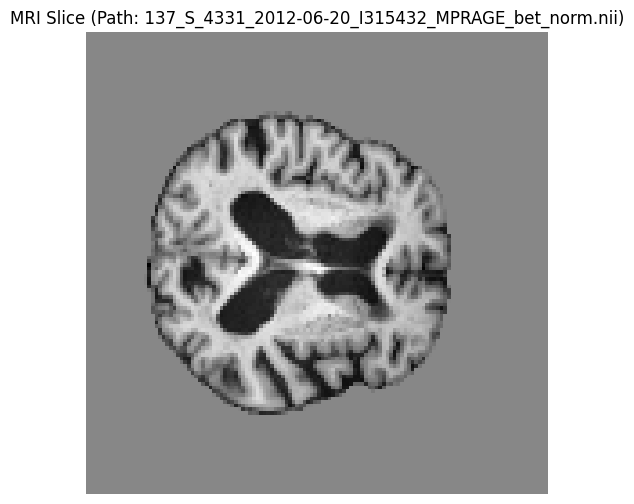

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 15.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.0505, Max value: 7.3320, Mean: -0.0001, Std: 0.9322


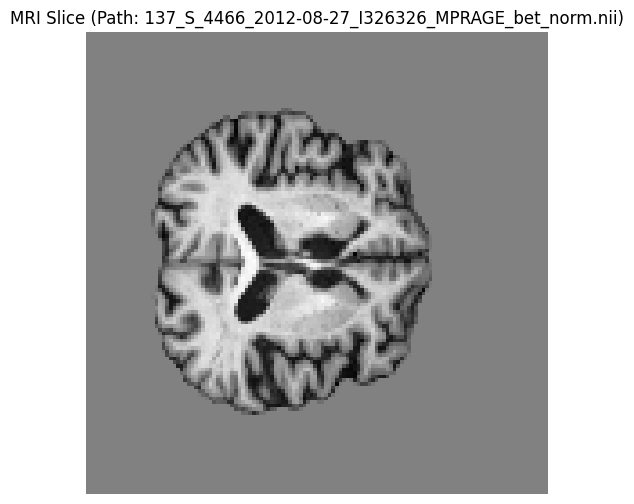

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -5.8161, Max value: 8.4129, Mean: 0.0000, Std: 0.9558


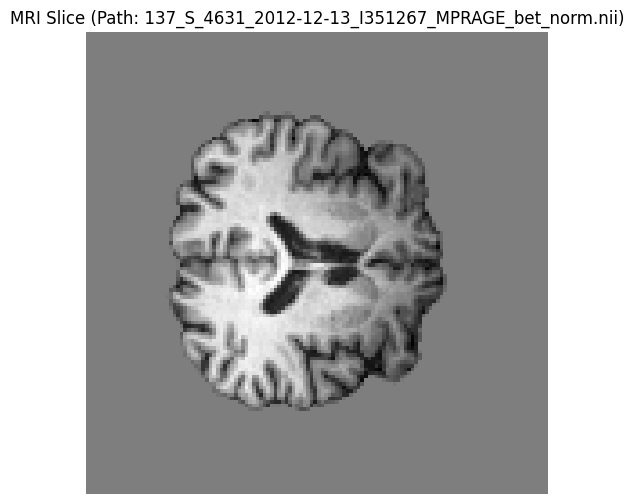

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 20.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.4818, Max value: 7.3661, Mean: -0.0001, Std: 0.9289


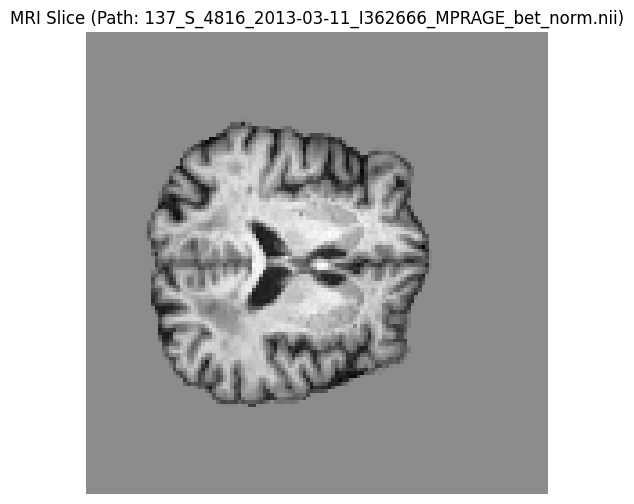

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.6805, Max value: 5.8658, Mean: 0.0001, Std: 0.9191


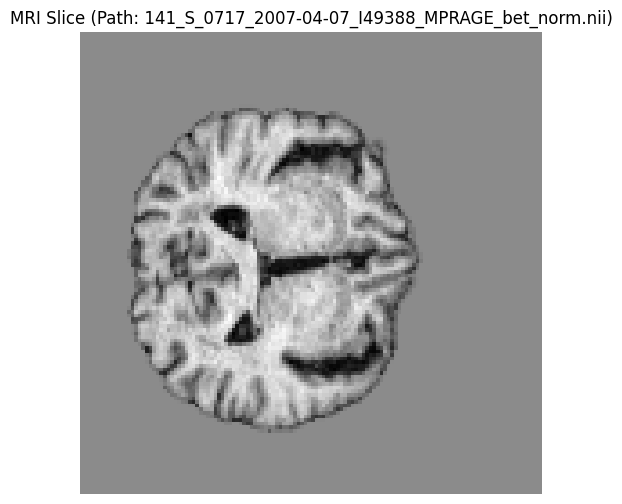

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 12.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -5.9988, Max value: 6.4068, Mean: 0.0000, Std: 0.9282


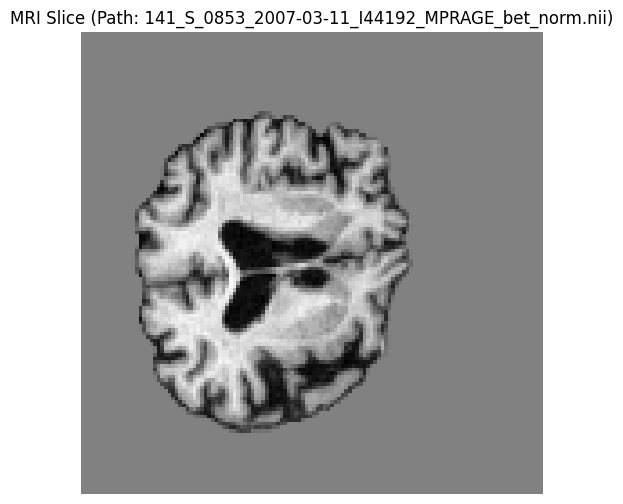

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.1230, Max value: 5.8523, Mean: -0.0001, Std: 0.9208


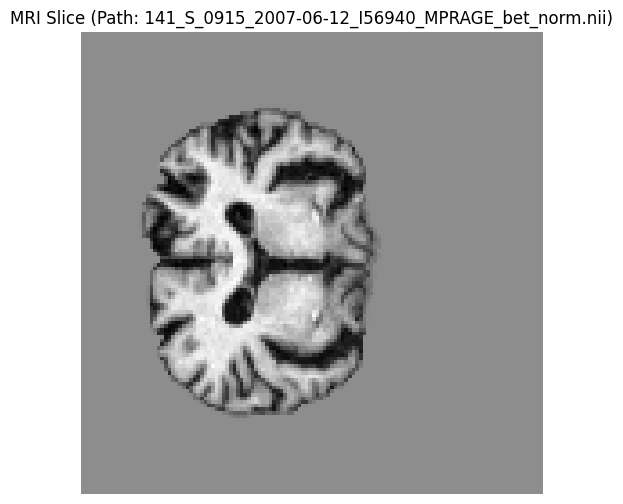

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 14.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.0001, Max value: 5.2456, Mean: 0.0000, Std: 0.9239


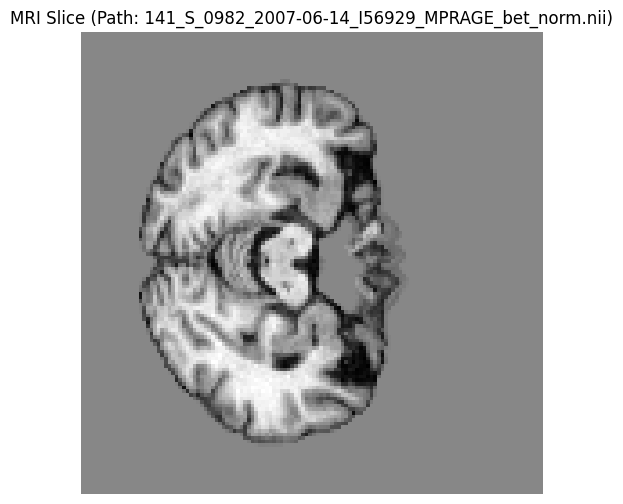

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -7.0954, Max value: 7.8885, Mean: 0.0001, Std: 0.9269


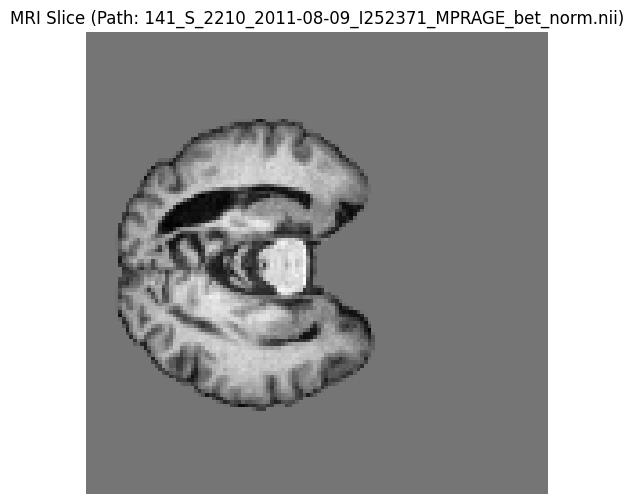

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 12.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -8.4776, Max value: 15.4967, Mean: 0.0000, Std: 0.9174


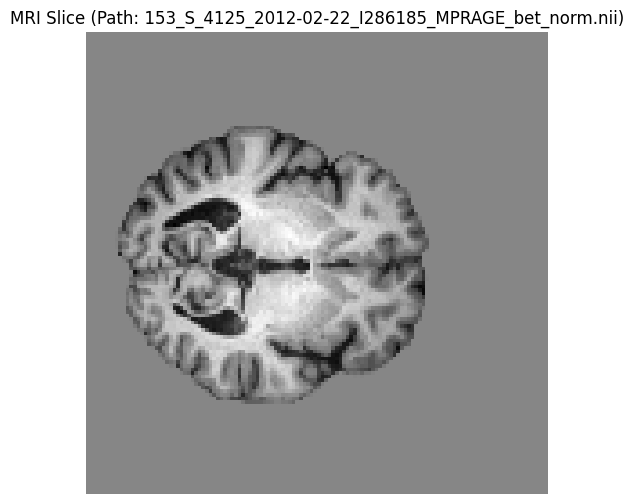

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  1. 12.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.4652, Max value: 8.8817, Mean: 0.0000, Std: 0.9277


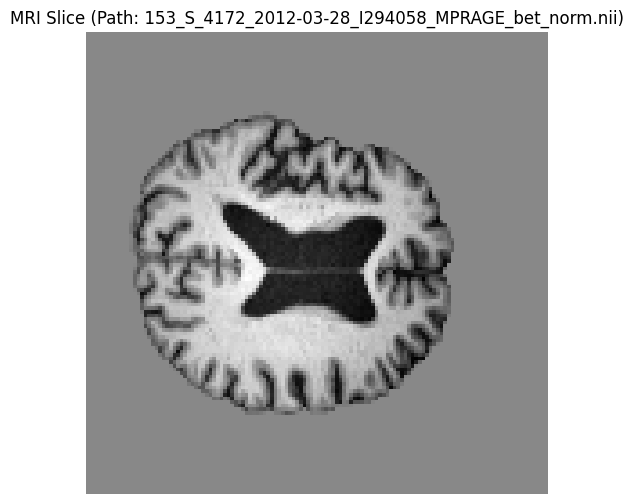

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -6.0498, Max value: 5.4576, Mean: -0.0000, Std: 0.9251


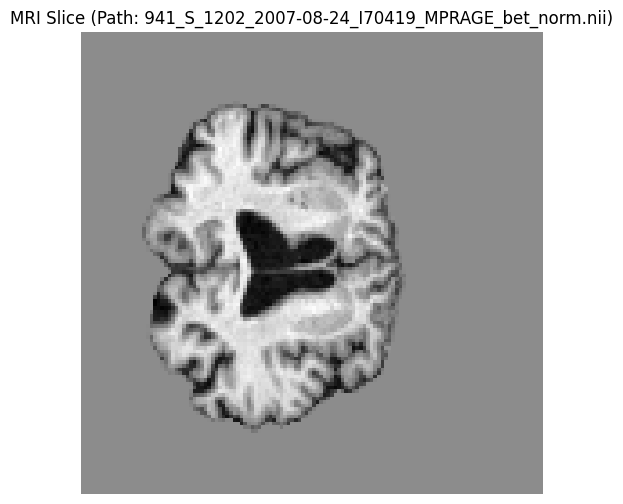

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 18.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -5.5463, Max value: 5.0947, Mean: -0.0003, Std: 0.9285


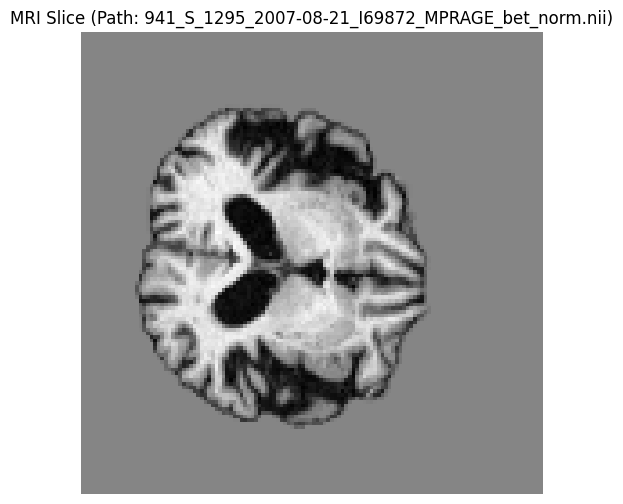

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 16.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (160, 192, 192)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -5.3915, Max value: 7.7033, Mean: 0.0001, Std: 0.9304


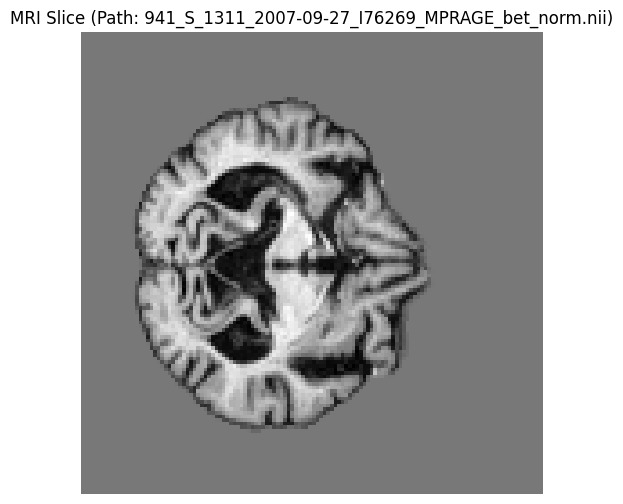

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 12.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Original MRI shape: (176, 240, 256)
MRI shape after preprocessing: (128, 128, 128, 1)
Min value: -8.3399, Max value: 7.2757, Mean: 0.0000, Std: 0.9251


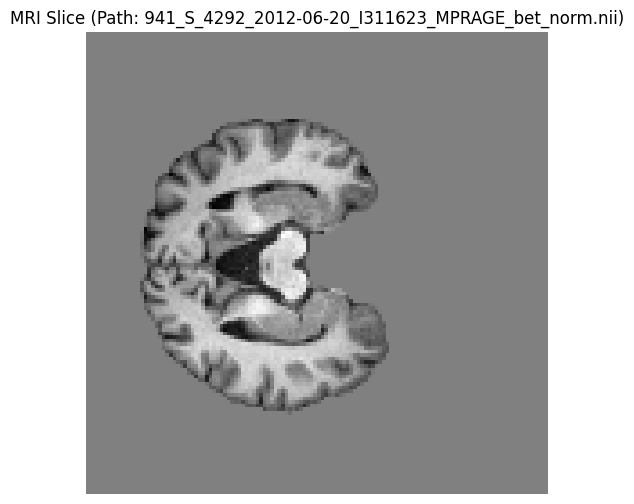

Demographic features shape: (1, 3)
Sample demographic data (first row): [ 0.  0. 15.]
Age stats: Min=0.0000, Max=0.0000, Mean=0.0000
Loaded CSV: /kaggle/input/dataset/merged_data_updated.csv
Total rows in CSV: 797
Baseline rows: 196
Valid samples after processing: 196
Skipped due to no MRI: 0
Skipped due to preprocessing errors: 0
Class distribution baseline: {'CN': 42, 'MCI': 128, 'AD': 26}
Class distribution 6m: {'CN': 38, 'MCI': 133, 'AD': 25}
Class distribution 12m: {'CN': 33, 'MCI': 136, 'AD': 27}
Training set: 136 samples, MRI shape: (136, 128, 128, 128, 1), Demo shape: (136, 3)
Validation set: 20 samples
Test set: 40 samples
Label shape (baseline, train): (136, 3)
Sample MRI (first): shape=(128, 128, 128, 1)
Sample demo (first): [ 0.  1. 20.]
Sample label baseline (first): [0. 1. 0.]
Sample label 6m (first): [0. 1. 0.]
Sample label 12m (first): [0. 1. 0.]
ResNet3D model summary:


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ mri_input (InputLayer)    │ (None, 128, 128, 128,  │              0 │ -                      │
│                           │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_2 (Cast)             │ (None, 128, 128, 128,  │              0 │ mri_input[0][0]        │
│                           │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_90 (Conv3D)        │ (None, 64, 64, 64, 64) │         22,016 │ cast_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_5           │ (None, 32, 32, 32, 64) │              0 │ conv3d_90[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_91 (Conv3D)        │ (None, 32, 32, 32, 64) │        110,656 │ max_pooling3d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_92 (Conv3D)        │ (None, 32, 32, 32, 64) │        110,656 │ conv3d_91[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_30 (Add)              │ (None, 32, 32, 32, 64) │              0 │ max_pooling3d_5[0][0], │
│                           │                        │                │ conv3d_92[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_30 (ReLU)           │ (None, 32, 32, 32, 64) │              0 │ add_30[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_93 (Conv3D)        │ (None, 16, 16, 16, 64) │        110,656 │ re_lu_30[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_95 (Conv3D)        │ (None, 16, 16, 16, 64) │          4,160 │ re_lu_30[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_94 (Conv3D)        │ (None, 16, 16, 16, 64) │        110,656 │ conv3d_93[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_31 (Add)              │ (None, 16, 16, 16, 64) │              0 │ conv3d_95[0][0],       │
│                           │                        │                │ conv3d_94[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_31 (ReLU)           │ (None, 16, 16, 16, 64) │              0 │ add_31[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_96 (Conv3D)        │ (None, 16, 16, 16,     │        221,312 │ re_lu_31[0][0]         │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_98 (Conv3D)        │ (None, 16, 16, 16,     │          8,320 │ re_lu_31[0][0]         │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_97 (Conv3D)        │ (None, 16, 16, 16,     │        442,496 │ conv3d_96[0][0]        │
│                      

 Total params: 8,377,353 (31.96 MB)

 Trainable params: 8,377,353 (31.96 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - loss: 9.5277 - output_12m_accuracy: 0.6757 - output_12m_loss: 3.0971 - output_6m_accuracy: 0.4219 - output_6m_loss: 2.8095 - output_baseline_accuracy: 0.2834 - output_baseline_loss: 3.6211 - val_loss: 8.2861 - val_output_12m_accuracy: 0.6500 - val_output_12m_loss: 2.8534 - val_output_6m_accuracy: 0.7500 - val_output_6m_loss: 1.4640 - val_output_baseline_accuracy: 0.1000 - val_output_baseline_loss: 3.9687 - learning_rate: 1.0000e-04
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 9.2442 - output_12m_accuracy: 0.5602 - output_12m_loss: 2.7118 - output_6m_accuracy: 0.5363 - output_6m_loss: 2.4928 - output_baseline_accuracy: 0.4676 - output_baseline_loss: 4.0395 - val_loss: 6.6754 - val_output_12m_accuracy: 0.6500 - val_output_12m_loss: 2.4615 - val_output_6m_accuracy: 0.7500 - val_output_6m_loss: 1.0156 - val_output_baseline_accuracy: 0.2000 - val_output_baseline_loss: 3.1983 - learning_rate: 1.0000e-04
Epoch 3/100
68/68 ━

2025-06-04 18:37:41.765313: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng9{k2=2,k13=0,k14=0,k18=1,k23=0} for conv (f16[32,64,64,64,64]{4,3,2,1,0}, u8[0]{0}) custom-call(f16[32,1,133,133,133]{4,3,2,1,0}, f16[64,1,7,7,7]{4,3,2,1,0}, f16[64]{0}), window={size=7x7x7 stride=2x2x2}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-06-04 18:37:42.825876: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.060649296s
Trying algorithm eng9{k2=2,k13=0,k14=0,k18=1,k23=0} for conv (f16[32,64,64,64,64]{4,3,2,1,0}, u8[0]{0}) custom-call(f16[32,1,133,133,133]{4,3,2,1,0}, f16[64,1,7,7,7]{4,3,2,1,0}, f16[64]{0}), window={size=7x7x7 stride=2x2x2}, dim_labe

2/2 ━━━━━━━━━━━━━━━━━━━━ 30s 9s/step

Classification Report (Baseline):
              precision    recall  f1-score   support

          CN       0.50      0.11      0.18         9
         MCI       1.00      0.15      0.27        26
          AD       0.15      1.00      0.26         5

    accuracy                           0.25        40
   macro avg       0.55      0.42      0.23        40
weighted avg       0.78      0.25      0.25        40


Confusion Matrix (Baseline):
[[ 1  0  8]
 [ 1  4 21]
 [ 0  0  5]]

Classification Report (6m):
              precision    recall  f1-score   support

          CN       0.00      0.00      0.00         8
         MCI       0.69      0.93      0.79        27
          AD       0.00      0.00      0.00         5

    accuracy                           0.62        40
   macro avg       0.23      0.31      0.26        40
weighted avg       0.47      0.62      0.54        40


Confusion Matrix (6m):
[[ 0  7  1]
 [ 0 25  2]
 [ 1  4  0]]

Classifi

ValueError: too many values to unpack (expected 4)

In [67]:
model, history, y_pred_6m, y_pred_12m = main()